# In this notebook we are training our detection model on synthtext dataset

In [ ]:
import os
import glob
import csv
from tqdm import tqdm 
import random
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import threading
import shutil
import pandas as pd
import os
import math
import csv
import cv2
import time
import shutil
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
from tqdm import tqdm
import scipy.io
import multiprocessing
try:
    import queue
except ImportError:
    import Queue as queue
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import scipy.io as sio
from tqdm import tqdm

In [ ]:
!wget --header="Host: thor.robots.ox.ac.uk" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7,hi;q=0.6" --header="Referer: https://www.robots.ox.ac.uk/" --header="Cookie: _ga=GA1.3.447472098.1614888528; _gid=GA1.3.438299578.1615686909; _gat=1" --header="Connection: keep-alive" "https://thor.robots.ox.ac.uk/~vgg/data/scenetext/SynthText.zip" -c -O 'SynthText.zip'

--2021-06-17 03:33:22--  https://thor.robots.ox.ac.uk/~vgg/data/scenetext/SynthText.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40717671794 (38G) [application/zip]
Saving to: ‘SynthText.zip’

SynthText.zip       100%[===================>]  37.92G  31.1MB/s    in 20m 38s 

2021-06-17 03:54:01 (31.4 MB/s) - ‘SynthText.zip’ saved [40717671794/40717671794]



In [ ]:
#https://www.geeksforgeeks.org/working-zip-files-python/
def get_all_file_paths(directory):
  
    # initializing empty file paths list
    file_paths = []
  
    # crawling through directory and subdirectories
    for root, directories, files in os.walk(directory):
        for filename in files:
            # join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
  
    # returning all file paths
    file_paths = random.sample(file_paths, 15000)
    return file_paths       
    
def main():
    # path to folder which needs to be zipped
    directory = '/content/SynthText'
  
    # calling function to get all file paths in the directory
    file_paths = get_all_file_paths(directory)
  
    # printing the list of all files to be zipped
    print('Following files will be zipped:')
    for file_name in file_paths:
        print(file_name)
  
    # writing files to a zipfile
    with ZipFile('SynthText.zip','w') as zip:
        # writing each file one by one
        for file in file_paths:
            zip.write(file)
  
    print('All files zipped successfully!')        
  
  
if __name__ == "__main__":
    main()

Streaming output truncated to the last 5000 lines.
/content/SynthText/168/study+room_120_47.jpg
/content/SynthText/123/oxford_72_71.jpg
/content/SynthText/155/sea_1_63.jpg
/content/SynthText/117/night_11_88.jpg
/content/SynthText/9/baroque_100_56.jpg
/content/SynthText/138/punting_94_27.jpg
/content/SynthText/175/swimming_72_80.jpg
/content/SynthText/137/punting_128_64.jpg
/content/SynthText/146/richard+feynman_85_1.jpg
/content/SynthText/18/berkeley_70_35.jpg
/content/SynthText/70/hedge_64_90.jpg
/content/SynthText/142/rajasthan_39_96.jpg
/content/SynthText/1/ant+hill_114_3.jpg
/content/SynthText/55/eagle_148_100.jpg
/content/SynthText/182/turtles_126_45.jpg
/content/SynthText/140/rain_99_101.jpg
/content/SynthText/14/bay+area_61_68.jpg
/content/SynthText/3/aquarium_101_16.jpg
/content/SynthText/184/tyres_6_94.jpg
/content/SynthText/19/berkeley_86_107.jpg
/content/SynthText/45/crater_62_107.jpg
/content/SynthText/33/city_65_82.jpg
/content/SynthText/129/photos_134_105.jpg
/content/Syn

In [ ]:
!unzip  "/content/drive/MyDrive/SynthText.zip" 

Streaming output truncated to the last 5000 lines.
 extracting: content/SynthText/39/coffee_18_2.jpg  
 extracting: content/SynthText/168/study+room_120_47.jpg  
 extracting: content/SynthText/123/oxford_72_71.jpg  
 extracting: content/SynthText/155/sea_1_63.jpg  
 extracting: content/SynthText/117/night_11_88.jpg  
 extracting: content/SynthText/9/baroque_100_56.jpg  
 extracting: content/SynthText/138/punting_94_27.jpg  
 extracting: content/SynthText/175/swimming_72_80.jpg  
 extracting: content/SynthText/137/punting_128_64.jpg  
 extracting: content/SynthText/146/richard+feynman_85_1.jpg  
 extracting: content/SynthText/18/berkeley_70_35.jpg  
 extracting: content/SynthText/70/hedge_64_90.jpg  
 extracting: content/SynthText/142/rajasthan_39_96.jpg  
 extracting: content/SynthText/1/ant+hill_114_3.jpg  
 extracting: content/SynthText/55/eagle_148_100.jpg  
 extracting: content/SynthText/182/turtles_126_45.jpg  
 extracting: content/SynthText/140/rain_99_101.jpg  
 extracting: cont

In [ ]:
os.mkdir('synth_text')
os.makedirs('synthtext/annotation')

In [ ]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS

In [ ]:
#converting synthtext dataset to cidar file format of ground truth

# read data / path to gt.mat
ground_truth = sio.loadmat('/content/drive/MyDrive/gt.mat')
# # 1. paths to imgs
img_paths = [i[0] for i in ground_truth['imnames'][0, :]]
with open('synth_text/images_path.txt', 'w') as f:
    for item in img_paths:
        f.write("%s\n" % item)

# 2. word list
dataset_word_list = []
for img_words in ground_truth['txt'][0, :]:
    img_word_list = []
    for words in img_words:
        for word in [item for sublist in [i.strip().split(' ') for i in words.split('\n')] for item in sublist]:
            if word != '':
                img_word_list.append(word)
    dataset_word_list.append(img_word_list)

# # 3. polys and words
# iter = 0
iter = 0
for polys, words, img_path in tqdm(zip(ground_truth['wordBB'][0, :], dataset_word_list, img_paths)):

    # fix poly
    if len(polys.shape) == 2:
        polys = polys[:, :, np.newaxis]
    polys = polys.transpose([-1, 0, 1])

    # check if all match up
    if polys.shape[0] != len(words):
        print('number of polys and words do not mathc')
        break

    # write file
    with open('synthtext/annotation/{}.txt'.format(img_path.split('/')[1].split('.')[0]), 'w') as f:
        for poly, word in zip(polys, words):
            line = np.around(poly, 1).ravel()
            line = np.concatenate([line, [word]], axis=0)
            for item in line:
                f.write("%s " % item)
            f.write("\n")
    iter += 1
    if iter % 100 == 0:
        print(iter, 'out of', len(img_paths))

356it [00:00, 1774.12it/s]

100 out of 858750
200 out of 858750
300 out of 858750
400 out of 858750


812it [00:00, 1614.92it/s]

500 out of 858750
600 out of 858750
700 out of 858750
800 out of 858750


1208it [00:00, 1774.85it/s]

900 out of 858750
1000 out of 858750
1100 out of 858750
1200 out of 858750


1540it [00:00, 1708.75it/s]

1300 out of 858750
1400 out of 858750
1500 out of 858750
1600 out of 858750


1906it [00:01, 1769.34it/s]

1700 out of 858750
1800 out of 858750
1900 out of 858750
2000 out of 858750


2340it [00:01, 1951.62it/s]

2100 out of 858750
2200 out of 858750
2300 out of 858750
2400 out of 858750
2500 out of 858750


2949it [00:01, 2003.77it/s]

2600 out of 858750
2700 out of 858750
2800 out of 858750
2900 out of 858750
3000 out of 858750


3347it [00:01, 1851.53it/s]

3100 out of 858750
3200 out of 858750
3300 out of 858750


3734it [00:02, 1894.83it/s]

3400 out of 858750
3500 out of 858750
3600 out of 858750
3700 out of 858750
3800 out of 858750


4108it [00:02, 1742.72it/s]

3900 out of 858750
4000 out of 858750
4100 out of 858750
4200 out of 858750


4702it [00:02, 1888.62it/s]

4300 out of 858750
4400 out of 858750
4500 out of 858750
4600 out of 858750
4700 out of 858750


5115it [00:02, 1978.48it/s]

4800 out of 858750
4900 out of 858750
5000 out of 858750
5100 out of 858750
5200 out of 858750


5554it [00:02, 2076.97it/s]

5300 out of 858750
5400 out of 858750
5500 out of 858750
5600 out of 858750
5700 out of 858750


6227it [00:03, 2163.58it/s]

5800 out of 858750
5900 out of 858750
6000 out of 858750
6100 out of 858750
6200 out of 858750


6689it [00:03, 2203.84it/s]

6300 out of 858750
6400 out of 858750
6500 out of 858750
6600 out of 858750
6700 out of 858750


7127it [00:03, 2088.48it/s]

6800 out of 858750
6900 out of 858750
7000 out of 858750
7100 out of 858750


7564it [00:03, 2061.42it/s]

7200 out of 858750
7300 out of 858750
7400 out of 858750
7500 out of 858750
7600 out of 858750


8001it [00:04, 2109.44it/s]

7700 out of 858750
7800 out of 858750
7900 out of 858750
8000 out of 858750
8100 out of 858750


8427it [00:04, 2084.23it/s]

8200 out of 858750
8300 out of 858750
8400 out of 858750
8500 out of 858750
8600 out of 858750


9049it [00:04, 2024.74it/s]

8700 out of 858750
8800 out of 858750
8900 out of 858750
9000 out of 858750


9594it [00:04, 2337.09it/s]

9100 out of 858750
9200 out of 858750
9300 out of 858750
9400 out of 858750
9500 out of 858750
9600 out of 858750


10065it [00:05, 2188.86it/s]

9700 out of 858750
9800 out of 858750
9900 out of 858750
10000 out of 858750
10100 out of 858750


10528it [00:05, 2231.01it/s]

10200 out of 858750
10300 out of 858750
10400 out of 858750
10500 out of 858750
10600 out of 858750


11058it [00:05, 2425.16it/s]

10700 out of 858750
10800 out of 858750
10900 out of 858750
11000 out of 858750
11100 out of 858750


11582it [00:05, 2475.51it/s]

11200 out of 858750
11300 out of 858750
11400 out of 858750
11500 out of 858750
11600 out of 858750


12089it [00:05, 2374.03it/s]

11700 out of 858750
11800 out of 858750
11900 out of 858750
12000 out of 858750
12100 out of 858750


12567it [00:06, 2198.76it/s]

12200 out of 858750
12300 out of 858750
12400 out of 858750
12500 out of 858750
12600 out of 858750


13028it [00:06, 2185.72it/s]

12700 out of 858750
12800 out of 858750
12900 out of 858750
13000 out of 858750
13100 out of 858750


13496it [00:06, 2202.47it/s]

13200 out of 858750
13300 out of 858750
13400 out of 858750
13500 out of 858750


13920it [00:06, 1876.52it/s]

13600 out of 858750
13700 out of 858750
13800 out of 858750
13900 out of 858750


14304it [00:07, 1853.99it/s]

14000 out of 858750
14100 out of 858750
14200 out of 858750
14300 out of 858750


14673it [00:07, 1726.71it/s]

14400 out of 858750
14500 out of 858750
14600 out of 858750
14700 out of 858750


15064it [00:07, 1823.43it/s]

14800 out of 858750
14900 out of 858750
15000 out of 858750
15100 out of 858750


15462it [00:07, 1821.76it/s]

15200 out of 858750
15300 out of 858750
15400 out of 858750
15500 out of 858750
15600 out of 858750


15856it [00:07, 1895.64it/s]

15700 out of 858750
15800 out of 858750
15900 out of 858750
16000 out of 858750


16438it [00:08, 1673.30it/s]

16100 out of 858750
16200 out of 858750
16300 out of 858750
16400 out of 858750


16775it [00:08, 1546.29it/s]

16500 out of 858750
16600 out of 858750
16700 out of 858750


17125it [00:08, 1570.15it/s]

16800 out of 858750
16900 out of 858750
17000 out of 858750
17100 out of 858750


17478it [00:08, 1585.55it/s]

17200 out of 858750
17300 out of 858750
17400 out of 858750
17500 out of 858750


17801it [00:09, 1523.81it/s]

17600 out of 858750
17700 out of 858750
17800 out of 858750
17900 out of 858750


18194it [00:09, 1696.93it/s]

18000 out of 858750
18100 out of 858750
18200 out of 858750
18300 out of 858750


18768it [00:09, 1725.22it/s]

18400 out of 858750
18500 out of 858750
18600 out of 858750
18700 out of 858750


18945it [00:09, 1617.20it/s]

18800 out of 858750
18900 out of 858750
19000 out of 858750


19277it [00:10, 1575.23it/s]

19100 out of 858750
19200 out of 858750
19300 out of 858750


19601it [00:10, 1516.62it/s]

19400 out of 858750
19500 out of 858750
19600 out of 858750
19700 out of 858750


20034it [00:10, 1792.74it/s]

19800 out of 858750
19900 out of 858750
20000 out of 858750
20100 out of 858750
20200 out of 858750


20575it [00:10, 1633.93it/s]

20300 out of 858750
20400 out of 858750
20500 out of 858750


20921it [00:11, 1659.50it/s]

20600 out of 858750
20700 out of 858750
20800 out of 858750
20900 out of 858750


21284it [00:11, 1730.64it/s]

21000 out of 858750
21100 out of 858750
21200 out of 858750
21300 out of 858750


21685it [00:11, 1862.08it/s]

21400 out of 858750
21500 out of 858750
21600 out of 858750
21700 out of 858750
21800 out of 858750


22323it [00:11, 2036.79it/s]

21900 out of 858750
22000 out of 858750
22100 out of 858750
22200 out of 858750
22300 out of 858750


22529it [00:11, 1855.24it/s]

22400 out of 858750
22500 out of 858750
22600 out of 858750
22700 out of 858750


23110it [00:12, 1864.41it/s]

22800 out of 858750
22900 out of 858750
23000 out of 858750
23100 out of 858750
23200 out of 858750


23516it [00:12, 1951.25it/s]

23300 out of 858750
23400 out of 858750
23500 out of 858750
23600 out of 858750
23700 out of 858750


24153it [00:12, 1902.35it/s]

23800 out of 858750
23900 out of 858750
24000 out of 858750
24100 out of 858750


24622it [00:12, 2087.98it/s]

24200 out of 858750
24300 out of 858750
24400 out of 858750
24500 out of 858750
24600 out of 858750


25096it [00:13, 2081.26it/s]

24700 out of 858750
24800 out of 858750
24900 out of 858750
25000 out of 858750
25100 out of 858750


25513it [00:13, 1882.15it/s]

25200 out of 858750
25300 out of 858750
25400 out of 858750
25500 out of 858750


25952it [00:13, 1877.39it/s]

25600 out of 858750
25700 out of 858750
25800 out of 858750
25900 out of 858750


26336it [00:13, 1850.82it/s]

26000 out of 858750
26100 out of 858750
26200 out of 858750
26300 out of 858750


26801it [00:14, 1943.45it/s]

26400 out of 858750
26500 out of 858750
26600 out of 858750
26700 out of 858750
26800 out of 858750


27304it [00:14, 2202.25it/s]

26900 out of 858750
27000 out of 858750
27100 out of 858750
27200 out of 858750
27300 out of 858750
27400 out of 858750


27846it [00:14, 2268.64it/s]

27500 out of 858750
27600 out of 858750
27700 out of 858750
27800 out of 858750
27900 out of 858750


28317it [00:14, 2227.44it/s]

28000 out of 858750
28100 out of 858750
28200 out of 858750
28300 out of 858750
28400 out of 858750


28847it [00:14, 2426.87it/s]

28500 out of 858750
28600 out of 858750
28700 out of 858750
28800 out of 858750
28900 out of 858750
29000 out of 858750
29100 out of 858750


29738it [00:15, 2669.78it/s]

29200 out of 858750
29300 out of 858750
29400 out of 858750
29500 out of 858750
29600 out of 858750
29700 out of 858750


30293it [00:15, 2688.60it/s]

29800 out of 858750
29900 out of 858750
30000 out of 858750
30100 out of 858750
30200 out of 858750
30300 out of 858750


30565it [00:15, 2415.42it/s]

30400 out of 858750
30500 out of 858750
30600 out of 858750
30700 out of 858750


31040it [00:15, 1973.41it/s]

30800 out of 858750
30900 out of 858750
31000 out of 858750
31100 out of 858750


31462it [00:15, 2036.52it/s]

31200 out of 858750
31300 out of 858750
31400 out of 858750
31500 out of 858750
31600 out of 858750


32079it [00:16, 1981.64it/s]

31700 out of 858750
31800 out of 858750
31900 out of 858750
32000 out of 858750
32100 out of 858750


32475it [00:16, 1902.77it/s]

32200 out of 858750
32300 out of 858750
32400 out of 858750
32500 out of 858750


32873it [00:16, 1823.40it/s]

32600 out of 858750
32700 out of 858750
32800 out of 858750
32900 out of 858750


33273it [00:16, 1912.68it/s]

33000 out of 858750
33100 out of 858750
33200 out of 858750
33300 out of 858750
33400 out of 858750


33932it [00:17, 2095.16it/s]

33500 out of 858750
33600 out of 858750
33700 out of 858750
33800 out of 858750
33900 out of 858750


34348it [00:17, 2013.96it/s]

34000 out of 858750
34100 out of 858750
34200 out of 858750
34300 out of 858750


34792it [00:17, 2102.84it/s]

34400 out of 858750
34500 out of 858750
34600 out of 858750
34700 out of 858750
34800 out of 858750


35262it [00:17, 2225.12it/s]

34900 out of 858750
35000 out of 858750
35100 out of 858750
35200 out of 858750
35300 out of 858750
35400 out of 858750


35714it [00:18, 2117.80it/s]

35500 out of 858750
35600 out of 858750
35700 out of 858750
35800 out of 858750
35900 out of 858750
36000 out of 858750


36495it [00:18, 2131.27it/s]

36100 out of 858750
36200 out of 858750
36300 out of 858750
36400 out of 858750


36714it [00:18, 1976.37it/s]

36500 out of 858750
36600 out of 858750
36700 out of 858750
36800 out of 858750


37150it [00:18, 2047.69it/s]

36900 out of 858750
37000 out of 858750
37100 out of 858750
37200 out of 858750
37300 out of 858750


37816it [00:19, 2160.33it/s]

37400 out of 858750
37500 out of 858750
37600 out of 858750
37700 out of 858750
37800 out of 858750


38275it [00:19, 2142.80it/s]

37900 out of 858750
38000 out of 858750
38100 out of 858750
38200 out of 858750
38300 out of 858750


38733it [00:19, 2190.58it/s]

38400 out of 858750
38500 out of 858750
38600 out of 858750
38700 out of 858750
38800 out of 858750


39164it [00:19, 2066.26it/s]

38900 out of 858750
39000 out of 858750
39100 out of 858750
39200 out of 858750


39764it [00:19, 2378.61it/s]

39300 out of 858750
39400 out of 858750
39500 out of 858750
39600 out of 858750
39700 out of 858750
39800 out of 858750
39900 out of 858750


40295it [00:20, 2453.47it/s]

40000 out of 858750
40100 out of 858750
40200 out of 858750
40300 out of 858750
40400 out of 858750


40832it [00:20, 2419.42it/s]

40500 out of 858750
40600 out of 858750
40700 out of 858750
40800 out of 858750
40900 out of 858750
41000 out of 858750


41330it [00:20, 2320.60it/s]

41100 out of 858750
41200 out of 858750
41300 out of 858750
41400 out of 858750
41500 out of 858750


42072it [00:20, 2377.47it/s]

41600 out of 858750
41700 out of 858750
41800 out of 858750
41900 out of 858750
42000 out of 858750


42554it [00:21, 2293.40it/s]

42100 out of 858750
42200 out of 858750
42300 out of 858750
42400 out of 858750
42500 out of 858750


43026it [00:21, 2318.64it/s]

42600 out of 858750
42700 out of 858750
42800 out of 858750
42900 out of 858750
43000 out of 858750
43100 out of 858750


43577it [00:21, 2526.29it/s]

43200 out of 858750
43300 out of 858750
43400 out of 858750
43500 out of 858750
43600 out of 858750
43700 out of 858750


44092it [00:21, 2452.28it/s]

43800 out of 858750
43900 out of 858750
44000 out of 858750
44100 out of 858750
44200 out of 858750


44579it [00:21, 2280.30it/s]

44300 out of 858750
44400 out of 858750
44500 out of 858750
44600 out of 858750
44700 out of 858750


45039it [00:22, 2169.94it/s]

44800 out of 858750
44900 out of 858750
45000 out of 858750
45100 out of 858750
45200 out of 858750


45768it [00:22, 2261.52it/s]

45300 out of 858750
45400 out of 858750
45500 out of 858750
45600 out of 858750
45700 out of 858750


46223it [00:22, 2200.82it/s]

45800 out of 858750
45900 out of 858750
46000 out of 858750
46100 out of 858750
46200 out of 858750


46661it [00:22, 2045.03it/s]

46300 out of 858750
46400 out of 858750
46500 out of 858750
46600 out of 858750


47099it [00:23, 2095.05it/s]

46700 out of 858750
46800 out of 858750
46900 out of 858750
47000 out of 858750
47100 out of 858750


47520it [00:23, 2014.12it/s]

47200 out of 858750
47300 out of 858750
47400 out of 858750
47500 out of 858750
47600 out of 858750


47966it [00:23, 2117.40it/s]

47700 out of 858750
47800 out of 858750
47900 out of 858750
48000 out of 858750
48100 out of 858750


48423it [00:23, 2165.44it/s]

48200 out of 858750
48300 out of 858750
48400 out of 858750
48500 out of 858750
48600 out of 858750


49133it [00:24, 2267.53it/s]

48700 out of 858750
48800 out of 858750
48900 out of 858750
49000 out of 858750
49100 out of 858750


49590it [00:24, 2202.34it/s]

49200 out of 858750
49300 out of 858750
49400 out of 858750
49500 out of 858750
49600 out of 858750


50056it [00:24, 2262.76it/s]

49700 out of 858750
49800 out of 858750
49900 out of 858750
50000 out of 858750
50100 out of 858750


50499it [00:24, 2114.91it/s]

50200 out of 858750
50300 out of 858750
50400 out of 858750
50500 out of 858750
50600 out of 858750


50924it [00:24, 2039.17it/s]

50700 out of 858750
50800 out of 858750
50900 out of 858750
51000 out of 858750


51331it [00:25, 1993.11it/s]

51100 out of 858750
51200 out of 858750
51300 out of 858750
51400 out of 858750
51500 out of 858750


51987it [00:25, 2124.60it/s]

51600 out of 858750
51700 out of 858750
51800 out of 858750
51900 out of 858750
52000 out of 858750


52418it [00:25, 2071.15it/s]

52100 out of 858750
52200 out of 858750
52300 out of 858750
52400 out of 858750


52627it [00:25, 1906.78it/s]

52500 out of 858750
52600 out of 858750
52700 out of 858750
52800 out of 858750


53257it [00:26, 1957.93it/s]

52900 out of 858750
53000 out of 858750
53100 out of 858750
53200 out of 858750
53300 out of 858750


53655it [00:26, 1891.40it/s]

53400 out of 858750
53500 out of 858750
53600 out of 858750
53700 out of 858750


54035it [00:26, 1759.86it/s]

53800 out of 858750
53900 out of 858750
54000 out of 858750
54100 out of 858750


54381it [00:26, 1586.87it/s]

54200 out of 858750
54300 out of 858750
54400 out of 858750


54703it [00:27, 1577.99it/s]

54500 out of 858750
54600 out of 858750
54700 out of 858750
54800 out of 858750


55140it [00:27, 1840.39it/s]

54900 out of 858750
55000 out of 858750
55100 out of 858750
55200 out of 858750
55300 out of 858750


55707it [00:27, 1744.96it/s]

55400 out of 858750
55500 out of 858750
55600 out of 858750
55700 out of 858750


56095it [00:27, 1837.70it/s]

55800 out of 858750
55900 out of 858750
56000 out of 858750
56100 out of 858750


56501it [00:27, 1918.51it/s]

56200 out of 858750
56300 out of 858750
56400 out of 858750
56500 out of 858750
56600 out of 858750


56934it [00:28, 2038.37it/s]

56700 out of 858750
56800 out of 858750
56900 out of 858750
57000 out of 858750
57100 out of 858750


57580it [00:28, 2011.09it/s]

57200 out of 858750
57300 out of 858750
57400 out of 858750
57500 out of 858750
57600 out of 858750


58038it [00:28, 2147.29it/s]

57700 out of 858750
57800 out of 858750
57900 out of 858750
58000 out of 858750
58100 out of 858750


58477it [00:28, 2157.26it/s]

58200 out of 858750
58300 out of 858750
58400 out of 858750
58500 out of 858750
58600 out of 858750


58906it [00:29, 1778.45it/s]

58700 out of 858750
58800 out of 858750
58900 out of 858750


59274it [00:29, 1740.20it/s]

59000 out of 858750
59100 out of 858750
59200 out of 858750
59300 out of 858750


59623it [00:29, 1513.84it/s]

59400 out of 858750
59500 out of 858750
59600 out of 858750


60075it [00:29, 1825.11it/s]

59700 out of 858750
59800 out of 858750
59900 out of 858750
60000 out of 858750
60100 out of 858750


60492it [00:30, 1954.29it/s]

60200 out of 858750
60300 out of 858750
60400 out of 858750
60500 out of 858750
60600 out of 858750


60975it [00:30, 2157.95it/s]

60700 out of 858750
60800 out of 858750
60900 out of 858750
61000 out of 858750
61100 out of 858750


61511it [00:30, 2401.59it/s]

61200 out of 858750
61300 out of 858750
61400 out of 858750
61500 out of 858750
61600 out of 858750
61700 out of 858750


61997it [00:30, 2165.35it/s]

61800 out of 858750
61900 out of 858750
62000 out of 858750
62100 out of 858750


62434it [00:30, 2011.61it/s]

62200 out of 858750
62300 out of 858750
62400 out of 858750
62500 out of 858750


62853it [00:31, 1924.69it/s]

62600 out of 858750
62700 out of 858750
62800 out of 858750
62900 out of 858750
63000 out of 858750


63450it [00:31, 1864.65it/s]

63100 out of 858750
63200 out of 858750
63300 out of 858750
63400 out of 858750


63935it [00:31, 2104.38it/s]

63500 out of 858750
63600 out of 858750
63700 out of 858750
63800 out of 858750
63900 out of 858750


64468it [00:31, 2349.85it/s]

64000 out of 858750
64100 out of 858750
64200 out of 858750
64300 out of 858750
64400 out of 858750
64500 out of 858750


64941it [00:32, 2265.96it/s]

64600 out of 858750
64700 out of 858750
64800 out of 858750
64900 out of 858750
65000 out of 858750


65388it [00:32, 2091.10it/s]

65100 out of 858750
65200 out of 858750
65300 out of 858750
65400 out of 858750


65806it [00:32, 2031.51it/s]

65500 out of 858750
65600 out of 858750
65700 out of 858750
65800 out of 858750
65900 out of 858750


66209it [00:32, 1801.07it/s]

66000 out of 858750
66100 out of 858750
66200 out of 858750


66593it [00:32, 1801.97it/s]

66300 out of 858750
66400 out of 858750
66500 out of 858750
66600 out of 858750


66952it [00:33, 1655.93it/s]

66700 out of 858750
66800 out of 858750
66900 out of 858750
67000 out of 858750


67294it [00:33, 1643.04it/s]

67100 out of 858750
67200 out of 858750
67300 out of 858750
67400 out of 858750


67868it [00:33, 1766.39it/s]

67500 out of 858750
67600 out of 858750
67700 out of 858750
67800 out of 858750


68244it [00:33, 1782.37it/s]

67900 out of 858750
68000 out of 858750
68100 out of 858750
68200 out of 858750


68623it [00:34, 1732.83it/s]

68300 out of 858750
68400 out of 858750
68500 out of 858750
68600 out of 858750


68979it [00:34, 1691.75it/s]

68700 out of 858750
68800 out of 858750
68900 out of 858750
69000 out of 858750


69411it [00:34, 1800.37it/s]

69100 out of 858750
69200 out of 858750
69300 out of 858750
69400 out of 858750
69500 out of 858750


69829it [00:34, 1933.85it/s]

69600 out of 858750
69700 out of 858750
69800 out of 858750
69900 out of 858750
70000 out of 858750


70455it [00:35, 1917.82it/s]

70100 out of 858750
70200 out of 858750
70300 out of 858750
70400 out of 858750


70903it [00:35, 2075.70it/s]

70500 out of 858750
70600 out of 858750
70700 out of 858750
70800 out of 858750
70900 out of 858750


71350it [00:35, 2122.50it/s]

71000 out of 858750
71100 out of 858750
71200 out of 858750
71300 out of 858750
71400 out of 858750


71807it [00:35, 2167.40it/s]

71500 out of 858750
71600 out of 858750
71700 out of 858750
71800 out of 858750
71900 out of 858750


72247it [00:35, 2138.24it/s]

72000 out of 858750
72100 out of 858750
72200 out of 858750
72300 out of 858750


72668it [00:36, 2008.82it/s]

72400 out of 858750
72500 out of 858750
72600 out of 858750
72700 out of 858750
72800 out of 858750


73074it [00:36, 1914.72it/s]

72900 out of 858750
73000 out of 858750
73100 out of 858750
73200 out of 858750


73694it [00:36, 1953.39it/s]

73300 out of 858750
73400 out of 858750
73500 out of 858750
73600 out of 858750
73700 out of 858750


74096it [00:36, 1979.40it/s]

73800 out of 858750
73900 out of 858750
74000 out of 858750
74100 out of 858750
74200 out of 858750


74521it [00:37, 2035.63it/s]

74300 out of 858750
74400 out of 858750
74500 out of 858750
74600 out of 858750
74700 out of 858750


75208it [00:37, 2191.74it/s]

74800 out of 858750
74900 out of 858750
75000 out of 858750
75100 out of 858750
75200 out of 858750
75300 out of 858750


75699it [00:37, 2125.54it/s]

75400 out of 858750
75500 out of 858750
75600 out of 858750
75700 out of 858750


76201it [00:37, 2307.12it/s]

75800 out of 858750
75900 out of 858750
76000 out of 858750
76100 out of 858750
76200 out of 858750
76300 out of 858750


76665it [00:38, 2146.14it/s]

76400 out of 858750
76500 out of 858750
76600 out of 858750
76700 out of 858750


77145it [00:38, 2137.14it/s]

76800 out of 858750
76900 out of 858750
77000 out of 858750
77100 out of 858750
77200 out of 858750


77642it [00:38, 2291.23it/s]

77300 out of 858750
77400 out of 858750
77500 out of 858750
77600 out of 858750
77700 out of 858750


78118it [00:38, 2208.33it/s]

77800 out of 858750
77900 out of 858750
78000 out of 858750
78100 out of 858750
78200 out of 858750


78617it [00:38, 2348.46it/s]

78300 out of 858750
78400 out of 858750
78500 out of 858750
78600 out of 858750
78700 out of 858750
78800 out of 858750


79373it [00:39, 2366.90it/s]

78900 out of 858750
79000 out of 858750
79100 out of 858750
79200 out of 858750
79300 out of 858750


79845it [00:39, 2273.87it/s]

79400 out of 858750
79500 out of 858750
79600 out of 858750
79700 out of 858750
79800 out of 858750


80305it [00:39, 2260.96it/s]

79900 out of 858750
80000 out of 858750
80100 out of 858750
80200 out of 858750
80300 out of 858750


80738it [00:39, 1993.66it/s]

80400 out of 858750
80500 out of 858750
80600 out of 858750
80700 out of 858750


80988it [00:40, 2120.43it/s]

80800 out of 858750
80900 out of 858750
81000 out of 858750
81100 out of 858750


81402it [00:40, 1716.75it/s]

81200 out of 858750
81300 out of 858750
81400 out of 858750
81500 out of 858750


81905it [00:40, 2040.11it/s]

81600 out of 858750
81700 out of 858750
81800 out of 858750
81900 out of 858750
82000 out of 858750
82100 out of 858750


82668it [00:40, 2365.16it/s]

82200 out of 858750
82300 out of 858750
82400 out of 858750
82500 out of 858750
82600 out of 858750
82700 out of 858750


83235it [00:41, 2336.48it/s]

82800 out of 858750
82900 out of 858750
83000 out of 858750
83100 out of 858750
83200 out of 858750


83736it [00:41, 2380.81it/s]

83300 out of 858750
83400 out of 858750
83500 out of 858750
83600 out of 858750
83700 out of 858750


84272it [00:41, 2408.82it/s]

83800 out of 858750
83900 out of 858750
84000 out of 858750
84100 out of 858750
84200 out of 858750


84768it [00:41, 2407.76it/s]

84300 out of 858750
84400 out of 858750
84500 out of 858750
84600 out of 858750
84700 out of 858750


85013it [00:41, 2220.54it/s]

84800 out of 858750
84900 out of 858750
85000 out of 858750
85100 out of 858750
85200 out of 858750


85752it [00:42, 2274.17it/s]

85300 out of 858750
85400 out of 858750
85500 out of 858750
85600 out of 858750
85700 out of 858750


85983it [00:42, 2103.87it/s]

85800 out of 858750
85900 out of 858750
86000 out of 858750
86100 out of 858750


86400it [00:42, 1945.71it/s]

86200 out of 858750
86300 out of 858750
86400 out of 858750
86500 out of 858750


87020it [00:42, 1989.89it/s]

86600 out of 858750
86700 out of 858750
86800 out of 858750
86900 out of 858750
87000 out of 858750


87446it [00:43, 1935.18it/s]

87100 out of 858750
87200 out of 858750
87300 out of 858750
87400 out of 858750


87883it [00:43, 2005.26it/s]

87500 out of 858750
87600 out of 858750
87700 out of 858750
87800 out of 858750
87900 out of 858750


88288it [00:43, 1939.69it/s]

88000 out of 858750
88100 out of 858750
88200 out of 858750
88300 out of 858750


88702it [00:43, 1945.04it/s]

88400 out of 858750
88500 out of 858750
88600 out of 858750
88700 out of 858750


89080it [00:43, 1730.07it/s]

88800 out of 858750
88900 out of 858750
89000 out of 858750
89100 out of 858750


89486it [00:44, 1870.52it/s]

89200 out of 858750
89300 out of 858750
89400 out of 858750
89500 out of 858750


89868it [00:44, 1842.44it/s]

89600 out of 858750
89700 out of 858750
89800 out of 858750
89900 out of 858750
90000 out of 858750


90271it [00:44, 1920.11it/s]

90100 out of 858750
90200 out of 858750
90300 out of 858750
90400 out of 858750


90836it [00:44, 1717.78it/s]

90500 out of 858750
90600 out of 858750
90700 out of 858750
90800 out of 858750


91179it [00:45, 1600.60it/s]

90900 out of 858750
91000 out of 858750
91100 out of 858750


91509it [00:45, 1604.67it/s]

91200 out of 858750
91300 out of 858750
91400 out of 858750
91500 out of 858750


91832it [00:45, 1546.53it/s]

91600 out of 858750
91700 out of 858750
91800 out of 858750


91988it [00:45, 1385.48it/s]

91900 out of 858750
92000 out of 858750


92318it [00:45, 1339.71it/s]

92100 out of 858750
92200 out of 858750
92300 out of 858750
92400 out of 858750


92684it [00:46, 1550.59it/s]

92500 out of 858750
92600 out of 858750
92700 out of 858750
92800 out of 858750
92900 out of 858750


93336it [00:46, 1868.78it/s]

93000 out of 858750
93100 out of 858750
93200 out of 858750
93300 out of 858750


93531it [00:46, 1680.26it/s]

93400 out of 858750
93500 out of 858750
93600 out of 858750


93923it [00:46, 1699.06it/s]

93700 out of 858750
93800 out of 858750
93900 out of 858750
94000 out of 858750
94100 out of 858750


94540it [00:47, 1915.60it/s]

94200 out of 858750
94300 out of 858750
94400 out of 858750
94500 out of 858750
94600 out of 858750


94929it [00:47, 1871.52it/s]

94700 out of 858750
94800 out of 858750
94900 out of 858750
95000 out of 858750


95308it [00:47, 1859.44it/s]

95100 out of 858750
95200 out of 858750
95300 out of 858750
95400 out of 858750


95767it [00:47, 2062.24it/s]

95500 out of 858750
95600 out of 858750
95700 out of 858750
95800 out of 858750
95900 out of 858750


96178it [00:47, 1917.28it/s]

96000 out of 858750
96100 out of 858750
96200 out of 858750
96300 out of 858750


96748it [00:48, 1780.43it/s]

96400 out of 858750
96500 out of 858750
96600 out of 858750
96700 out of 858750


97125it [00:48, 1699.56it/s]

96800 out of 858750
96900 out of 858750
97000 out of 858750
97100 out of 858750


97495it [00:48, 1730.55it/s]

97200 out of 858750
97300 out of 858750
97400 out of 858750
97500 out of 858750
97600 out of 858750


97983it [00:48, 1963.34it/s]

97700 out of 858750
97800 out of 858750
97900 out of 858750
98000 out of 858750


98380it [00:49, 1714.13it/s]

98100 out of 858750
98200 out of 858750
98300 out of 858750
98400 out of 858750


98781it [00:49, 1813.51it/s]

98500 out of 858750
98600 out of 858750
98700 out of 858750
98800 out of 858750
98900 out of 858750


99248it [00:49, 1988.13it/s]

99000 out of 858750
99100 out of 858750
99200 out of 858750
99300 out of 858750
99400 out of 858750


99916it [00:49, 2070.81it/s]

99500 out of 858750
99600 out of 858750
99700 out of 858750
99800 out of 858750
99900 out of 858750


100407it [00:50, 2183.48it/s]

100000 out of 858750
100100 out of 858750
100200 out of 858750
100300 out of 858750
100400 out of 858750


100912it [00:50, 2331.41it/s]

100500 out of 858750
100600 out of 858750
100700 out of 858750
100800 out of 858750
100900 out of 858750
101000 out of 858750


101389it [00:50, 2184.01it/s]

101100 out of 858750
101200 out of 858750
101300 out of 858750
101400 out of 858750
101500 out of 858750


101841it [00:50, 2172.82it/s]

101600 out of 858750
101700 out of 858750
101800 out of 858750
101900 out of 858750
102000 out of 858750


102349it [00:51, 2311.41it/s]

102100 out of 858750
102200 out of 858750
102300 out of 858750
102400 out of 858750
102500 out of 858750


102870it [00:51, 2283.59it/s]

102600 out of 858750
102700 out of 858750
102800 out of 858750
102900 out of 858750
103000 out of 858750


103329it [00:51, 2075.24it/s]

103100 out of 858750
103200 out of 858750
103300 out of 858750
103400 out of 858750


103812it [00:51, 2114.17it/s]

103500 out of 858750
103600 out of 858750
103700 out of 858750
103800 out of 858750
103900 out of 858750


104275it [00:51, 2194.55it/s]

104000 out of 858750
104100 out of 858750
104200 out of 858750
104300 out of 858750
104400 out of 858750


104719it [00:52, 2076.96it/s]

104500 out of 858750
104600 out of 858750
104700 out of 858750
104800 out of 858750
104900 out of 858750


105440it [00:52, 2295.49it/s]

105000 out of 858750
105100 out of 858750
105200 out of 858750
105300 out of 858750
105400 out of 858750


105674it [00:52, 2164.40it/s]

105500 out of 858750
105600 out of 858750
105700 out of 858750
105800 out of 858750


106348it [00:52, 2179.80it/s]

105900 out of 858750
106000 out of 858750
106100 out of 858750
106200 out of 858750
106300 out of 858750


106786it [00:53, 2075.50it/s]

106400 out of 858750
106500 out of 858750
106600 out of 858750
106700 out of 858750


106997it [00:53, 2009.55it/s]

106800 out of 858750
106900 out of 858750
107000 out of 858750
107100 out of 858750


107483it [00:53, 2149.17it/s]

107200 out of 858750
107300 out of 858750
107400 out of 858750
107500 out of 858750
107600 out of 858750


107938it [00:53, 2083.13it/s]

107700 out of 858750
107800 out of 858750
107900 out of 858750
108000 out of 858750
108100 out of 858750


108728it [00:53, 2441.24it/s]

108200 out of 858750
108300 out of 858750
108400 out of 858750
108500 out of 858750
108600 out of 858750
108700 out of 858750


109259it [00:54, 2472.19it/s]

108800 out of 858750
108900 out of 858750
109000 out of 858750
109100 out of 858750
109200 out of 858750


109511it [00:54, 2240.65it/s]

109300 out of 858750
109400 out of 858750
109500 out of 858750
109600 out of 858750
109700 out of 858750


110219it [00:54, 2277.39it/s]

109800 out of 858750
109900 out of 858750
110000 out of 858750
110100 out of 858750
110200 out of 858750


110789it [00:54, 2540.75it/s]

110300 out of 858750
110400 out of 858750
110500 out of 858750
110600 out of 858750
110700 out of 858750
110800 out of 858750


111308it [00:55, 2504.11it/s]

110900 out of 858750
111000 out of 858750
111100 out of 858750
111200 out of 858750
111300 out of 858750


111563it [00:55, 2389.47it/s]

111400 out of 858750
111500 out of 858750
111600 out of 858750
111700 out of 858750


112022it [00:55, 1977.41it/s]

111800 out of 858750
111900 out of 858750
112000 out of 858750
112100 out of 858750


112428it [00:55, 1880.85it/s]

112200 out of 858750
112300 out of 858750
112400 out of 858750
112500 out of 858750


112810it [00:55, 1810.61it/s]

112600 out of 858750
112700 out of 858750
112800 out of 858750
112900 out of 858750


113174it [00:56, 1618.29it/s]

113000 out of 858750
113100 out of 858750
113200 out of 858750


113485it [00:56, 1253.25it/s]

113300 out of 858750
113400 out of 858750
113500 out of 858750


113839it [00:56, 1476.06it/s]

113600 out of 858750
113700 out of 858750
113800 out of 858750
113900 out of 858750


114205it [00:56, 1637.54it/s]

114000 out of 858750
114100 out of 858750
114200 out of 858750
114300 out of 858750


114550it [00:57, 1595.97it/s]

114400 out of 858750
114500 out of 858750
114600 out of 858750
114700 out of 858750


115127it [00:57, 1729.80it/s]

114800 out of 858750
114900 out of 858750
115000 out of 858750
115100 out of 858750


115506it [00:57, 1699.04it/s]

115200 out of 858750
115300 out of 858750
115400 out of 858750
115500 out of 858750


115885it [00:57, 1758.68it/s]

115600 out of 858750
115700 out of 858750
115800 out of 858750
115900 out of 858750


116299it [00:58, 1797.14it/s]

116000 out of 858750
116100 out of 858750
116200 out of 858750
116300 out of 858750


116663it [00:58, 1614.41it/s]

116400 out of 858750
116500 out of 858750
116600 out of 858750
116700 out of 

116995it [00:58, 1552.08it/s]

858750
116800 out of 858750
116900 out of 858750
117000 out of 858750


117392it [00:58, 1749.41it/s]

117100 out of 858750
117200 out of 858750
117300 out of 858750
117400 out of 858750
117500 out of 858750


117997it [00:58, 1898.77it/s]

117600 out of 858750
117700 out of 858750
117800 out of 858750
117900 out of 858750


118190it [00:59, 1820.98it/s]

118000 out of 858750
118100 out of 858750
118200 out of 858750
118300 out of 858750


118556it [00:59, 1701.32it/s]

118400 out of 858750
118500 out of 858750
118600 out of 858750
118700 out of 858750


119131it [00:59, 1752.97it/s]

118800 out of 858750
118900 out of 858750
119000 out of 858750
119100 out of 858750


119495it [00:59, 1723.25it/s]

119200 out of 858750
119300 out of 858750
119400 out of 858750
119500 out of 858750


119838it [01:00, 1610.74it/s]

119600 out of 858750
119700 out of 858750
119800 out of 858750
119900 out of 858750


120213it [01:00, 1730.77it/s]

120000 out of 858750
120100 out of 858750
120200 out of 858750
120300 out of 858750


120841it [01:00, 1952.48it/s]

120400 out of 858750
120500 out of 858750
120600 out of 858750
120700 out of 858750
120800 out of 858750


121295it [01:00, 2086.06it/s]

120900 out of 858750
121000 out of 858750
121100 out of 858750
121200 out of 858750
121300 out of 858750


121716it [01:01, 2021.66it/s]

121400 out of 858750
121500 out of 858750
121600 out of 858750
121700 out of 858750
121800 out of 858750


122202it [01:01, 2213.00it/s]

121900 out of 858750
122000 out of 858750
122100 out of 858750
122200 out of 858750
122300 out of 858750


122651it [01:01, 2171.45it/s]

122400 out of 858750
122500 out of 858750
122600 out of 858750
122700 out of 858750
122800 out of 858750


123119it [01:01, 2248.88it/s]

122900 out of 858750
123000 out of 858750
123100 out of 858750
123200 out of 858750
123300 out of 858750


123878it [01:01, 2310.68it/s]

123400 out of 858750
123500 out of 858750
123600 out of 858750
123700 out of 858750
123800 out of 858750
123900 out of 858750


124402it [01:02, 2455.86it/s]

124000 out of 858750
124100 out of 858750
124200 out of 858750
124300 out of 858750
124400 out of 858750
124500 out of 858750


124955it [01:02, 2531.47it/s]

124600 out of 858750
124700 out of 858750
124800 out of 858750
124900 out of 858750
125000 out of 858750


125215it [01:02, 2168.40it/s]

125100 out of 858750
125200 out of 858750
125300 out of 858750
125400 out of 858750


125653it [01:02, 1887.39it/s]

125500 out of 858750
125600 out of 858750
125700 out of 858750
125800 out of 858750


126224it [01:03, 1704.22it/s]

125900 out of 858750
126000 out of 858750
126100 out of 858750
126200 out of 858750


126570it [01:03, 1625.02it/s]

126300 out of 858750
126400 out of 858750
126500 out of 858750
126600 out of 858750


126900it [01:03, 1596.84it/s]

126700 out of 858750
126800 out of 858750
126900 out of 858750
127000 out of 858750


127394it [01:03, 1576.61it/s]

127100 out of 858750
127200 out of 858750
127300 out of 858750
127400 out of 858750


127751it [01:04, 1641.40it/s]

127500 out of 858750
127600 out of 858750
127700 out of 858750
127800 out of 858750


128084it [01:04, 1637.98it/s]

127900 out of 858750
128000 out of 858750
128100 out of 858750
128200 out of 858750


128614it [01:04, 1717.19it/s]

128300 out of 858750
128400 out of 858750
128500 out of 858750
128600 out of 858750


128981it [01:04, 1743.72it/s]

128700 out of 858750
128800 out of 858750
128900 out of 858750
129000 out of 858750


129343it [01:05, 1727.36it/s]

129100 out of 858750
129200 out of 858750
129300 out of 858750
129400 out of 858750


129688it [01:05, 1692.24it/s]

129500 out of 858750
129600 out of 858750
129700 out of 858750


130046it [01:05, 1588.70it/s]

129800 out of 858750
129900 out of 858750
130000 out of 858750
130100 out of 858750


130398it [01:05, 1664.13it/s]

130200 out of 858750
130300 out of 858750
130400 out of 858750
130500 out of 858750


130913it [01:06, 1565.13it/s]

130600 out of 858750
130700 out of 858750
130800 out of 858750
130900 out of 858750


131256it [01:06, 1620.76it/s]

131000 out of 858750
131100 out of 858750
131200 out of 858750
131300 out of 858750


131602it [01:06, 1633.67it/s]

131400 out of 858750
131500 out of 858750
131600 out of 858750
131700 out of 858750


132154it [01:06, 1747.38it/s]

131800 out of 858750
131900 out of 858750
132000 out of 858750
132100 out of 858750


132360it [01:06, 1830.64it/s]

132200 out of 858750
132300 out of 858750
132400 out of 858750
132500 out of 858750


132716it [01:07, 1457.85it/s]

132600 out of 858750
132700 out of 858750
132800 out of 858750


133207it [01:07, 1487.32it/s]

132900 out of 858750
133000 out of 858750
133100 out of 858750
133200 out of 858750


133534it [01:07, 1515.57it/s]

133300 out of 858750
133400 out of 858750
133500 out of 858750
133600 out of 858750


133926it [01:07, 1710.99it/s]

133700 out of 858750
133800 out of 858750
133900 out of 858750
134000 out of 858750


134314it [01:08, 1804.65it/s]

134100 out of 858750
134200 out of 858750
134300 out of 858750
134400 out of 858750


134681it [01:08, 1719.31it/s]

134500 out of 858750
134600 out of 858750
134700 out of 858750
134800 out of 858750


135210it [01:08, 1684.72it/s]

134900 out of 858750
135000 out of 858750
135100 out of 858750
135200 out of 858750


135562it [01:08, 1574.05it/s]

135300 out of 858750
135400 out of 858750
135500 out of 858750


135895it [01:09, 1620.03it/s]

135600 out of 858750
135700 out of 858750
135800 out of 858750
135900 out of 858750


136325it [01:09, 1853.48it/s]

136000 out of 858750
136100 out of 858750
136200 out of 858750
136300 out of 858750
136400 out of 858750


136696it [01:09, 1689.13it/s]

136500 out of 858750
136600 out of 858750
136700 out of 858750
136800 out of 858750


137223it [01:09, 1708.82it/s]

136900 out of 858750
137000 out of 858750
137100 out of 858750
137200 out of 858750


137613it [01:10, 1742.12it/s]

137300 out of 858750
137400 out of 858750
137500 out of 858750
137600 out of 858750


137988it [01:10, 1738.03it/s]

137700 out of 858750
137800 out of 858750
137900 out of 858750
138000 out of 858750


138447it [01:10, 1784.43it/s]

138100 out of 858750
138200 out of 858750
138300 out of 858750
138400 out of 858750


138816it [01:10, 1748.23it/s]

138500 out of 858750
138600 out of 858750
138700 out of 858750
138800 out of 858750


139261it [01:10, 1916.82it/s]

138900 out of 858750
139000 out of 858750
139100 out of 858750
139200 out of 858750
139300 out of 858750


139662it [01:11, 1807.98it/s]

139400 out of 858750
139500 out of 858750
139600 out of 858750
139700 out of 858750


140102it [01:11, 1992.69it/s]

139800 out of 858750
139900 out of 858750
140000 out of 858750
140100 out of 858750
140200 out of 858750


140513it [01:11, 1995.81it/s]

140300 out of 858750
140400 out of 858750
140500 out of 858750
140600 out of 858750
140700 out of 858750


141234it [01:11, 2158.46it/s]

140800 out of 858750
140900 out of 858750
141000 out of 858750
141100 out of 858750
141200 out of 858750


141453it [01:12, 2057.20it/s]

141300 out of 858750
141400 out of 858750
141500 out of 858750
141600 out of 858750


142057it [01:12, 1870.48it/s]

141700 out of 858750
141800 out of 858750
141900 out of 858750
142000 out of 858750


142470it [01:12, 1835.12it/s]

142100 out of 858750
142200 out of 858750
142300 out of 858750
142400 out of 858750


142657it [01:12, 1717.48it/s]

142500 out of 858750
142600 out of 858750
142700 out of 858750
142800 out of 858750


143036it [01:12, 1747.21it/s]

142900 out of 858750
143000 out of 858750
143100 out of 858750
143200 out of 858750


143601it [01:13, 1801.94it/s]

143300 out of 858750
143400 out of 858750
143500 out of 858750
143600 out of 858750
143700 out of 858750


144010it [01:13, 1918.90it/s]

143800 out of 858750
143900 out of 858750
144000 out of 858750
144100 out of 858750
144200 out of 858750


144608it [01:13, 1845.69it/s]

144300 out of 858750
144400 out of 858750
144500 out of 858750
144600 out of 858750


144975it [01:13, 1769.05it/s]

144700 out of 858750
144800 out of 858750
144900 out of 858750
145000 out of 858750


145393it [01:14, 1836.32it/s]

145100 out of 858750
145200 out of 858750
145300 out of 858750
145400 out of 858750


145788it [01:14, 1908.98it/s]

145500 out of 858750
145600 out of 858750
145700 out of 858750
145800 out of 858750


146189it [01:14, 1898.39it/s]

145900 out of 858750
146000 out of 858750
146100 out of 858750
146200 out of 858750
146300 out of 858750


146873it [01:14, 2154.57it/s]

146400 out of 858750
146500 out of 858750
146600 out of 858750
146700 out of 858750
146800 out of 858750


147310it [01:15, 2054.09it/s]

146900 out of 858750
147000 out of 858750
147100 out of 858750
147200 out of 858750
147300 out of 858750


147737it [01:15, 2045.16it/s]

147400 out of 858750
147500 out of 858750
147600 out of 858750
147700 out of 858750
147800 out of 858750


148142it [01:15, 1958.77it/s]

147900 out of 858750
148000 out of 858750
148100 out of 858750
148200 out of 858750


148533it [01:15, 1911.11it/s]

148300 out of 858750
148400 out of 858750
148500 out of 858750
148600 out of 858750


148982it [01:15, 1985.97it/s]

148700 out of 858750
148800 out of 858750
148900 out of 858750
149000 out of 858750
149100 out of 858750


149405it [01:16, 1882.71it/s]

149200 out of 858750
149300 out of 858750
149400 out of 858750
149500 out of 858750


149786it [01:16, 1799.55it/s]

149600 out of 858750
149700 out of 858750
149800 out of 858750
149900 out of 858750


150358it [01:16, 1808.31it/s]

150000 out of 858750
150100 out of 858750
150200 out of 858750
150300 out of 858750


150788it [01:16, 1967.62it/s]

150400 out of 858750
150500 out of 858750
150600 out of 858750
150700 out of 858750
150800 out of 858750


151192it [01:17, 1977.74it/s]

150900 out of 858750
151000 out of 858750
151100 out of 858750
151200 out of 858750


151642it [01:17, 2060.95it/s]

151300 out of 858750
151400 out of 858750
151500 out of 858750
151600 out of 858750
151700 out of 858750


152106it [01:17, 2177.77it/s]

151800 out of 858750
151900 out of 858750
152000 out of 858750
152100 out of 858750
152200 out of 858750


152548it [01:17, 1974.82it/s]

152300 out of 858750
152400 out of 858750
152500 out of 858750
152600 out of 858750


152954it [01:18, 1884.28it/s]

152700 out of 858750
152800 out of 858750
152900 out of 858750
153000 out of 858750
153100 out of 858750


153603it [01:18, 2025.70it/s]

153200 out of 858750
153300 out of 858750
153400 out of 858750
153500 out of 858750
153600 out of 858750


154014it [01:18, 1988.16it/s]

153700 out of 858750
153800 out of 858750
153900 out of 858750
154000 out of 858750


154475it [01:18, 2096.75it/s]

154100 out of 858750
154200 out of 858750
154300 out of 858750
154400 out of 858750
154500 out of 858750


154893it [01:18, 1966.78it/s]

154600 out of 858750
154700 out of 858750
154800 out of 858750
154900 out of 858750


155312it [01:19, 2024.50it/s]

155000 out of 858750
155100 out of 858750
155200 out of 858750
155300 out of 858750
155400 out of 858750


155772it [01:19, 2058.36it/s]

155500 out of 858750
155600 out of 858750
155700 out of 858750
155800 out of 858750
155900 out of 858750


156216it [01:19, 2003.79it/s]

156000 out of 858750
156100 out of 858750
156200 out of 858750
156300 out of 858750


156616it [01:19, 1816.66it/s]

156400 out of 858750
156500 out of 858750
156600 out of 858750
156700 out of 858750


157011it [01:20, 1804.37it/s]

156800 out of 858750
156900 out of 858750
157000 out of 858750
157100 out of 858750


157388it [01:20, 1832.58it/s]

157200 out of 858750
157300 out of 858750
157400 out of 858750
157500 out of 858750
157600 out of 858750


158068it [01:20, 1995.58it/s]

157700 out of 858750
157800 out of 858750
157900 out of 858750
158000 out of 858750
158100 out of 858750


158504it [01:20, 2059.19it/s]

158200 out of 858750
158300 out of 858750
158400 out of 858750
158500 out of 858750
158600 out of 858750


158912it [01:21, 1916.09it/s]

158700 out of 858750
158800 out of 858750
158900 out of 858750
159000 out of 858750


159294it [01:21, 1834.30it/s]

159100 out of 858750
159200 out of 858750
159300 out of 858750
159400 out of 858750


159723it [01:21, 1984.41it/s]

159500 out of 858750
159600 out of 858750
159700 out of 858750
159800 out of 858750
159900 out of 858750


160324it [01:21, 1930.86it/s]

160000 out of 858750
160100 out of 858750
160200 out of 858750
160300 out of 858750
160400 out of 858750


160699it [01:22, 1685.14it/s]

160500 out of 858750
160600 out of 858750
160700 out of 858750
160800 out of 858750


161295it [01:22, 1881.27it/s]

160900 out of 858750
161000 out of 858750
161100 out of 858750
161200 out of 858750
161300 out of 858750


161733it [01:22, 2032.37it/s]

161400 out of 858750
161500 out of 858750
161600 out of 858750
161700 out of 858750
161800 out of 858750


162226it [01:22, 2111.83it/s]

161900 out of 858750
162000 out of 858750
162100 out of 858750
162200 out of 858750


162658it [01:22, 2043.64it/s]

162300 out of 858750
162400 out of 858750
162500 out of 858750
162600 out of 858750
162700 out of 858750


163069it [01:23, 1984.39it/s]

162800 out of 858750
162900 out of 858750
163000 out of 858750
163100 out of 858750


163551it [01:23, 2128.55it/s]

163200 out of 858750
163300 out of 858750
163400 out of 858750
163500 out of 858750
163600 out of 858750


164004it [01:23, 2161.10it/s]

163700 out of 858750
163800 out of 858750
163900 out of 858750
164000 out of 858750
164100 out of 858750


164449it [01:23, 2040.84it/s]

164200 out of 858750
164300 out of 858750
164400 out of 858750
164500 out of 858750


164862it [01:24, 1945.61it/s]

164600 out of 858750
164700 out of 858750
164800 out of 858750
164900 out of 858750
165000 out of 858750


165341it [01:24, 2152.05it/s]

165100 out of 858750
165200 out of 858750
165300 out of 858750
165400 out of 858750
165500 out of 858750


166014it [01:24, 2052.45it/s]

165600 out of 858750
165700 out of 858750
165800 out of 858750
165900 out of 858750
166000 out of 858750


166420it [01:24, 1810.60it/s]

166100 out of 858750
166200 out of 858750
166300 out of 858750
166400 out of 858750


166882it [01:25, 2023.83it/s]

166500 out of 858750
166600 out of 858750
166700 out of 858750
166800 out of 858750
166900 out of 858750


167290it [01:25, 1963.71it/s]

167000 out of 858750
167100 out of 858750
167200 out of 858750
167300 out of 858750


167684it [01:25, 1887.61it/s]

167400 out of 858750
167500 out of 858750
167600 out of 858750
167700 out of 858750


168101it [01:25, 1934.47it/s]

167800 out of 858750
167900 out of 858750
168000 out of 858750
168100 out of 858750
168200 out of 858750


168494it [01:25, 1838.10it/s]

168300 out of 858750
168400 out of 858750
168500 out of 858750
168600 out of 858750


168886it [01:26, 1848.00it/s]

168700 out of 858750
168800 out of 858750
168900 out of 858750
169000 out of 858750


169469it [01:26, 1851.64it/s]

169100 out of 858750
169200 out of 858750
169300 out of 858750
169400 out of 858750


169838it [01:26, 1751.28it/s]

169500 out of 858750
169600 out of 858750
169700 out of 858750
169800 out of 858750


170219it [01:26, 1805.02it/s]

169900 out of 858750
170000 out of 858750
170100 out of 858750
170200 out of 858750


170689it [01:27, 2051.12it/s]

170300 out of 858750
170400 out of 858750
170500 out of 858750
170600 out of 858750
170700 out of 858750


171175it [01:27, 2213.29it/s]

170800 out of 858750
170900 out of 858750
171000 out of 858750
171100 out of 858750
171200 out of 858750
171300 out of 858750


171637it [01:27, 2252.08it/s]

171400 out of 858750
171500 out of 858750
171600 out of 858750
171700 out of 858750
171800 out of 858750
171900 out of 858750


172377it [01:27, 2272.22it/s]

172000 out of 858750
172100 out of 858750
172200 out of 858750
172300 out of 858750
172400 out of 858750


172829it [01:28, 2194.43it/s]

172500 out of 858750
172600 out of 858750
172700 out of 858750
172800 out of 858750
172900 out of 858750


173342it [01:28, 2348.22it/s]

173000 out of 858750
173100 out of 858750
173200 out of 858750
173300 out of 858750
173400 out of 858750
173500 out of 858750


173840it [01:28, 2366.66it/s]

173600 out of 858750
173700 out of 858750
173800 out of 858750
173900 out of 858750


174079it [01:28, 1999.96it/s]

174000 out of 858750
174100 out of 858750
174200 out of 858750


174740it [01:28, 1967.86it/s]

174300 out of 858750
174400 out of 858750
174500 out of 858750
174600 out of 858750
174700 out of 858750


175148it [01:29, 1971.54it/s]

174800 out of 858750
174900 out of 858750
175000 out of 858750
175100 out of 858750
175200 out of 858750


175601it [01:29, 2110.20it/s]

175300 out of 858750
175400 out of 858750
175500 out of 858750
175600 out of 858750
175700 out of 858750


176080it [01:29, 2243.15it/s]

175800 out of 858750
175900 out of 858750
176000 out of 858750
176100 out of 858750
176200 out of 858750


176514it [01:29, 1730.51it/s]

176300 out of 858750
176400 out of 858750
176500 out of 858750


176875it [01:30, 1570.03it/s]

176600 out of 858750
176700 out of 858750
176800 out of 858750


177040it [01:30, 1509.88it/s]

176900 out of 858750
177000 out of 858750
177100 out of 858750


177530it [01:30, 1570.33it/s]

177200 out of 858750
177300 out of 858750
177400 out of 858750
177500 out of 858750


177864it [01:30, 1539.38it/s]

177600 out of 858750
177700 out of 858750
177800 out of 858750


178176it [01:30, 1452.21it/s]

177900 out of 858750
178000 out of 858750
178100 out of 858750


178582it [01:31, 1692.36it/s]

178200 out of 858750
178300 out of 858750
178400 out of 858750
178500 out of 858750
178600 out of 858750


178949it [01:31, 1761.68it/s]

178700 out of 858750
178800 out of 858750
178900 out of 858750
179000 out of 858750


179309it [01:31, 1716.99it/s]

179100 out of 858750
179200 out of 858750
179300 out of 858750
179400 out of 858750
179500 out of 858750


179990it [01:31, 1927.21it/s]

179600 out of 858750
179700 out of 858750
179800 out of 858750
179900 out of 858750


180395it [01:32, 1931.16it/s]

180000 out of 858750
180100 out of 858750
180200 out of 858750
180300 out of 858750


180591it [01:32, 1753.69it/s]

180400 out of 858750
180500 out of 858750
180600 out of 858750
180700 out of 858750


180974it [01:32, 1791.81it/s]

180800 out of 858750
180900 out of 858750
181000 out of 858750
181100 out of 858750


181541it [01:32, 1791.30it/s]

181200 out of 858750
181300 out of 858750
181400 out of 858750
181500 out of 858750


181920it [01:32, 1792.56it/s]

181600 out of 858750
181700 out of 858750
181800 out of 858750
181900 out of 858750


182308it [01:33, 1863.69it/s]

182000 out of 858750
182100 out of 858750
182200 out of 858750
182300 out of 858750
182400 out of 858750


182703it [01:33, 1910.41it/s]

182500 out of 858750
182600 out of 858750
182700 out of 858750
182800 out of 858750


183282it [01:33, 1783.60it/s]

182900 out of 858750
183000 out of 858750
183100 out of 858750
183200 out of 858750


183697it [01:33, 1913.82it/s]

183300 out of 858750
183400 out of 858750
183500 out of 858750
183600 out of 858750
183700 out of 858750


184108it [01:34, 1950.72it/s]

183800 out of 858750
183900 out of 858750
184000 out of 858750
184100 out of 858750
184200 out of 858750


184513it [01:34, 1857.90it/s]

184300 out of 858750
184400 out of 858750
184500 out of 858750
184600 out of 858750


184901it [01:34, 1890.58it/s]

184700 out of 858750
184800 out of 858750
184900 out of 858750
185000 out of 858750


185496it [01:34, 1906.56it/s]

185100 out of 858750
185200 out of 858750
185300 out of 858750
185400 out of 858750
185500 out of 858750


185877it [01:35, 1766.98it/s]

185600 out of 858750
185700 out of 858750
185800 out of 858750
185900 out of 858750


186243it [01:35, 1784.47it/s]

186000 out of 858750
186100 out of 858750
186200 out of 858750
186300 out of 858750


186670it [01:35, 1928.12it/s]

186400 out of 858750
186500 out of 858750
186600 out of 858750
186700 out of 858750


187063it [01:35, 1873.34it/s]

186800 out of 858750
186900 out of 858750
187000 out of 858750
187100 out of 858750


187433it [01:35, 1754.13it/s]

187200 out of 858750
187300 out of 858750
187400 out of 858750
187500 out of 858750


187845it [01:36, 1798.87it/s]

187600 out of 858750
187700 out of 858750
187800 out of 858750
187900 out of 858750


188204it [01:36, 1661.74it/s]

188000 out of 858750
188100 out of 858750
188200 out of 858750
188300 out of 858750


188760it [01:36, 1783.77it/s]

188400 out of 858750
188500 out of 858750
188600 out of 858750
188700 out of 858750


189223it [01:36, 2020.06it/s]

188800 out of 858750
188900 out of 858750
189000 out of 858750
189100 out of 858750
189200 out of 858750
189300 out of 858750


189675it [01:37, 2094.63it/s]

189400 out of 858750
189500 out of 858750
189600 out of 858750
189700 out of 858750
189800 out of 858750


190148it [01:37, 2221.68it/s]

189900 out of 858750
190000 out of 858750
190100 out of 858750
190200 out of 858750
190300 out of 858750


190842it [01:37, 2211.89it/s]

190400 out of 858750
190500 out of 858750
190600 out of 858750
190700 out of 858750
190800 out of 858750


191284it [01:37, 2077.94it/s]

190900 out of 858750
191000 out of 858750
191100 out of 858750
191200 out of 858750


191494it [01:38, 1910.95it/s]

191300 out of 858750
191400 out of 858750
191500 out of 858750
191600 out of 858750
191700 out of 858750


192140it [01:38, 1899.34it/s]

191800 out of 858750
191900 out of 858750
192000 out of 858750
192100 out of 858750


192539it [01:38, 1870.21it/s]

192200 out of 858750
192300 out of 858750
192400 out of 858750
192500 out of 858750


192927it [01:38, 1890.99it/s]

192600 out of 858750
192700 out of 858750
192800 out of 858750
192900 out of 858750


193307it [01:39, 1697.78it/s]

193000 out of 858750
193100 out of 858750
193200 out of 858750
193300 out of 858750


193705it [01:39, 1823.42it/s]

193400 out of 858750
193500 out of 858750
193600 out of 858750
193700 out of 858750
193800 out of 858750


194205it [01:39, 2073.35it/s]

193900 out of 858750
194000 out of 858750
194100 out of 858750
194200 out of 858750
194300 out of 858750


194637it [01:39, 2070.94it/s]

194400 out of 858750
194500 out of 858750
194600 out of 858750
194700 out of 858750
194800 out of 858750
194900 out of 858750


195393it [01:39, 2193.28it/s]

195000 out of 858750
195100 out of 858750
195200 out of 858750
195300 out of 858750
195400 out of 858750


195878it [01:40, 2178.71it/s]

195500 out of 858750
195600 out of 858750
195700 out of 858750
195800 out of 858750
195900 out of 858750


196397it [01:40, 2210.99it/s]

196000 out of 858750
196100 out of 858750
196200 out of 858750
196300 out of 858750
196400 out of 858750
196500 out of 858750


196883it [01:40, 2282.76it/s]

196600 out of 858750
196700 out of 858750
196800 out of 858750
196900 out of 858750
197000 out of 858750


197383it [01:40, 2332.14it/s]

197100 out of 858750
197200 out of 858750
197300 out of 858750
197400 out of 858750
197500 out of 858750


197849it [01:41, 1961.09it/s]

197600 out of 858750
197700 out of 858750
197800 out of 858750
197900 out of 858750


198251it [01:41, 1810.50it/s]

198000 out of 858750
198100 out of 858750
198200 out of 858750
198300 out of 858750


198643it [01:41, 1783.94it/s]

198400 out of 858750
198500 out of 858750
198600 out of 858750
198700 out of 858750


199005it [01:41, 1761.52it/s]

198800 out of 858750
198900 out of 858750
199000 out of 858750
199100 out of 858750


199383it [01:41, 1712.69it/s]

199200 out of 858750
199300 out of 858750
199400 out of 858750
199500 out of 858750


199964it [01:42, 1844.22it/s]

199600 out of 858750
199700 out of 858750
199800 out of 858750
199900 out of 858750


200151it [01:42, 1733.58it/s]

200000 out of 858750
200100 out of 858750
200200 out of 858750
200300 out of 858750


200702it [01:42, 1731.72it/s]

200400 out of 858750
200500 out of 858750
200600 out of 858750
200700 out of 858750


201065it [01:42, 1762.27it/s]

200800 out of 858750
200900 out of 858750
201000 out of 858750
201100 out of 858750


201423it [01:43, 1761.60it/s]

201200 out of 858750
201300 out of 858750
201400 out of 858750
201500 out of 858750


201773it [01:43, 1699.29it/s]

201600 out of 858750
201700 out of 858750
201800 out of 858750
201900 out of 858750


202383it [01:43, 1879.13it/s]

202000 out of 858750
202100 out of 858750
202200 out of 858750
202300 out of 858750
202400 out of 858750


202882it [01:43, 2149.94it/s]

202500 out of 858750
202600 out of 858750
202700 out of 858750
202800 out of 858750
202900 out of 858750
203000 out of 858750


203325it [01:44, 2114.14it/s]

203100 out of 858750
203200 out of 858750
203300 out of 858750
203400 out of 858750
203500 out of 858750


203782it [01:44, 2186.12it/s]

203600 out of 858750
203700 out of 858750
203800 out of 858750
203900 out of 858750


204205it [01:44, 1626.10it/s]

204000 out of 858750
204100 out of 858750
204200 out of 858750


204555it [01:44, 1596.92it/s]

204300 out of 858750
204400 out of 858750
204500 out of 858750
204600 out of 858750


204936it [01:45, 1732.07it/s]

204700 out of 858750
204800 out of 858750
204900 out of 858750
205000 out of 858750


205317it [01:45, 1773.77it/s]

205100 out of 858750
205200 out of 858750
205300 out of 858750
205400 out of 858750


205685it [01:45, 1784.97it/s]

205500 out of 858750
205600 out of 858750
205700 out of 858750
205800 out of 858750


206269it [01:45, 1833.17it/s]

205900 out of 858750
206000 out of 858750
206100 out of 858750
206200 out of 858750


206705it [01:45, 1956.69it/s]

206300 out of 858750
206400 out of 858750
206500 out of 858750
206600 out of 858750
206700 out of 858750


207169it [01:46, 2105.40it/s]

206800 out of 858750
206900 out of 858750
207000 out of 858750
207100 out of 858750
207200 out of 858750


207701it [01:46, 2354.11it/s]

207300 out of 858750
207400 out of 858750
207500 out of 858750
207600 out of 858750
207700 out of 858750
207800 out of 858750


208251it [01:46, 2377.93it/s]

207900 out of 858750
208000 out of 858750
208100 out of 858750
208200 out of 858750
208300 out of 858750


208825it [01:46, 2563.73it/s]

208400 out of 858750
208500 out of 858750
208600 out of 858750
208700 out of 858750
208800 out of 858750
208900 out of 858750


209349it [01:46, 2563.18it/s]

209000 out of 858750
209100 out of 858750
209200 out of 858750
209300 out of 858750
209400 out of 858750


209892it [01:47, 2546.50it/s]

209500 out of 858750
209600 out of 858750
209700 out of 858750
209800 out of 858750
209900 out of 858750
210000 out of 858750


210392it [01:47, 2206.74it/s]

210100 out of 858750
210200 out of 858750
210300 out of 858750
210400 out of 858750


210827it [01:47, 1862.35it/s]

210500 out of 858750
210600 out of 858750
210700 out of 858750
210800 out of 858750


211230it [01:47, 1811.03it/s]

210900 out of 858750
211000 out of 858750
211100 out of 858750
211200 out of 858750


211598it [01:48, 1747.21it/s]

211300 out of 858750
211400 out of 858750
211500 out of 858750
211600 out of 858750


212017it [01:48, 1777.95it/s]

211700 out of 858750
211800 out of 858750
211900 out of 858750
212000 out of 858750


212380it [01:48, 1758.24it/s]

212100 out of 858750
212200 out of 858750
212300 out of 858750
212400 out of 858750


212781it [01:48, 1691.75it/s]

212500 out of 858750
212600 out of 858750
212700 out of 858750
212800 out of 858750


213133it [01:49, 1647.15it/s]

212900 out of 858750
213000 out of 858750
213100 out of 858750
213200 out of 858750


213496it [01:49, 1726.47it/s]

213300 out of 858750
213400 out of 858750
213500 out of 858750
213600 out of 858750
213700 out of 858750


214200it [01:49, 2043.56it/s]

213800 out of 858750
213900 out of 858750
214000 out of 858750
214100 out of 858750
214200 out of 858750


214671it [01:49, 2041.61it/s]

214300 out of 858750
214400 out of 858750
214500 out of 858750
214600 out of 858750
214700 out of 858750


215109it [01:50, 2080.16it/s]

214800 out of 858750
214900 out of 858750
215000 out of 858750
215100 out of 858750
215200 out of 858750


215531it [01:50, 1954.49it/s]

215300 out of 858750
215400 out of 858750
215500 out of 858750
215600 out of 858750


215926it [01:50, 1927.45it/s]

215700 out of 858750
215800 out of 858750
215900 out of 858750
216000 out of 858750


216314it [01:50, 1863.81it/s]

216100 out of 858750
216200 out of 858750
216300 out of 858750
216400 out of 858750


216715it [01:50, 1834.17it/s]

216500 out of 858750
216600 out of 858750
216700 out of 858750
216800 out of 858750


217116it [01:51, 1797.15it/s]

216900 out of 858750
217000 out of 858750
217100 out of 858750
217200 out of 858750
217300 out of 858750


217743it [01:51, 1931.70it/s]

217400 out of 858750
217500 out of 858750
217600 out of 858750
217700 out of 858750
217800 out of

218163it [01:51, 1875.06it/s]

 858750
217900 out of 858750
218000 out of 858750
218100 out of 858750


218555it [01:51, 1801.66it/s]

218200 out of 858750
218300 out of 858750
218400 out of 858750
218500 out of 858750


218928it [01:52, 1800.63it/s]

218600 out of 858750
218700 out of 858750
218800 out of 858750
218900 out of 858750


219111it [01:52, 1653.24it/s]

219000 out of 858750
219100 out of 858750
219200 out of 858750


219651it [01:52, 1652.80it/s]

219300 out of 858750
219400 out of 858750
219500 out of 858750
219600 out of 858750


220024it [01:52, 1731.71it/s]

219700 out of 858750
219800 out of 858750
219900 out of 858750
220000 out of 858750
220100 out of 858750


220437it [01:52, 1805.42it/s]

220200 out of 858750
220300 out of 858750
220400 out of 858750
220500 out of 858750


220827it [01:53, 1858.60it/s]

220600 out of 858750
220700 out of 858750
220800 out of 858750
220900 out of 858750
221000 out of 858750


221436it [01:53, 1930.90it/s]

221100 out of 858750
221200 out of 858750
221300 out of 858750
221400 out of 858750
221500 out of 858750


221861it [01:53, 1959.62it/s]

221600 out of 858750
221700 out of 858750
221800 out of 858750
221900 out of 858750


222329it [01:53, 2086.89it/s]

222000 out of 858750
222100 out of 858750
222200 out of 858750
222300 out of 858750
222400 out of 858750


222788it [01:54, 2159.47it/s]

222500 out of 858750
222600 out of 858750
222700 out of 858750
222800 out of 858750
222900 out of 858750
223000 out of 858750


223255it [01:54, 2054.49it/s]

223100 out of 858750
223200 out of 858750
223300 out of 858750
223400 out of 858750


223701it [01:54, 2108.28it/s]

223500 out of 858750
223600 out of 858750
223700 out of 858750
223800 out of 858750


224113it [01:54, 1842.99it/s]

223900 out of 858750
224000 out of 858750
224100 out of 858750
224200 out of 858750


224517it [01:55, 1717.73it/s]

224300 out of 858750
224400 out of 858750
224500 out of 858750


224860it [01:55, 1471.68it/s]

224600 out of 858750
224700 out of 858750
224800 out of 858750


225231it [01:55, 1648.11it/s]

224900 out of 858750
225000 out of 858750
225100 out of 858750
225200 out of 858750


225667it [01:55, 1887.25it/s]

225300 out of 858750
225400 out of 858750
225500 out of 858750
225600 out of 858750
225700 out of 858750


226069it [01:55, 1733.34it/s]

225800 out of 858750
225900 out of 858750
226000 out of 858750


226438it [01:56, 1787.20it/s]

226100 out of 858750
226200 out of 858750
226300 out of 858750
226400 out of 858750


226792it [01:56, 1622.31it/s]

226500 out of 858750
226600 out of 858750
226700 out of 858750
226800 out of 858750


227215it [01:56, 1814.27it/s]

226900 out of 858750
227000 out of 858750
227100 out of 858750
227200 out of 858750


227622it [01:56, 1897.74it/s]

227300 out of 858750
227400 out of 858750
227500 out of 858750
227600 out of 858750


228004it [01:57, 1796.90it/s]

227700 out of 858750
227800 out of 858750
227900 out of 858750
228000 out of 858750


228379it [01:57, 1767.12it/s]

228100 out of 858750
228200 out of 858750
228300 out of 858750
228400 out of 858750


228811it [01:57, 1951.52it/s]

228500 out of 858750
228600 out of 858750
228700 out of 858750
228800 out of 858750
228900 out of 858750


229205it [01:57, 1850.97it/s]

229000 out of 858750
229100 out of 858750
229200 out of 858750
229300 out of 858750


229645it [01:57, 2015.48it/s]

229400 out of 858750
229500 out of 858750
229600 out of 858750
229700 out of 858750
229800 out of 858750


230341it [01:58, 2166.28it/s]

229900 out of 858750
230000 out of 858750
230100 out of 858750
230200 out of 858750
230300 out of 858750


230777it [01:58, 2090.92it/s]

230400 out of 858750
230500 out of 858750
230600 out of 858750
230700 out of 858750
230800 out of 858750


231202it [01:58, 2048.34it/s]

230900 out of 858750
231000 out of 858750
231100 out of 858750
231200 out of 858750
231300 out of 858750


231702it [01:58, 2235.37it/s]

231400 out of 858750
231500 out of 858750
231600 out of 858750
231700 out of 858750
231800 out of 858750


232155it [01:58, 2217.40it/s]

231900 out of 858750
232000 out of 858750
232100 out of 858750
232200 out of 858750
232300 out of 858750


232819it [01:59, 2142.11it/s]

232400 out of 858750
232500 out of 858750
232600 out of 858750
232700 out of 858750
232800 out of 858750


233245it [01:59, 2079.73it/s]

232900 out of 858750
233000 out of 858750
233100 out of 858750
233200 out of 858750
233300 out of 858750


233661it [01:59, 1889.03it/s]

233400 out of 858750
233500 out of 858750
233600 out of 858750
233700 out of 858750


234081it [01:59, 1996.41it/s]

233800 out of 858750
233900 out of 858750
234000 out of 858750
234100 out of 858750
234200 out of 858750


234479it [02:00, 1905.56it/s]

234300 out of 858750
234400 out of 858750
234500 out of 858750
234600 out of 858750


235033it [02:00, 1737.84it/s]

234700 out of 858750
234800 out of 858750
234900 out of 858750
235000 out of 858750


235401it [02:00, 1782.24it/s]

235100 out of 858750
235200 out of 858750
235300 out of 858750
235400 out of 858750


235739it [02:01, 1479.90it/s]

235500 out of 858750
235600 out of 858750
235700 out of 858750


236074it [02:01, 1491.89it/s]

235800 out of 858750
235900 out of 858750
236000 out of 858750
236100 out of 858750


236505it [02:01, 1767.81it/s]

236200 out of 858750
236300 out of 858750
236400 out of 858750
236500 out of 858750
236600 out of 858750


236890it [02:01, 1814.14it/s]

236700 out of 858750
236800 out of 858750
236900 out of 858750
237000 out of 858750


237509it [02:01, 1867.89it/s]

237100 out of 858750
237200 out of 858750
237300 out of 858750
237400 out of 858750
237500 out of 858750


237890it [02:02, 1813.91it/s]

237600 out of 858750
237700 out of 858750
237800 out of 858750
237900 out of 858750


238275it [02:02, 1833.82it/s]

238000 out of 858750
238100 out of 858750
238200 out of 858750
238300 out of 858750
238400 out of 858750


238830it [02:02, 1801.36it/s]

238500 out of 858750
238600 out of 858750
238700 out of 858750
238800 out of 858750


239207it [02:02, 1796.95it/s]

238900 out of 858750
239000 out of 858750
239100 out of 858750
239200 out of 858750


239579it [02:03, 1783.45it/s]

239300 out of 858750
239400 out of 858750
239500 out of 858750
239600 out of 858750


239931it [02:03, 1607.09it/s]

239700 out of 858750
239800 out of 858750
239900 out of 858750
240000 out of 858750


240352it [02:03, 1777.50it/s]

240100 out of 858750
240200 out of 858750
240300 out of 858750
240400 out of 858750
240500 out of 858750


240957it [02:03, 1913.77it/s]

240600 out of 858750
240700 out of 858750
240800 out of 858750
240900 out of 858750


241383it [02:04, 1972.54it/s]

241000 out of 858750
241100 out of 858750
241200 out of 858750
241300 out of 858750
241400 out of 858750


241810it [02:04, 1985.39it/s]

241500 out of 858750
241600 out of 858750
241700 out of 858750
241800 out of 858750
241900 out of 858750


242316it [02:04, 2215.24it/s]

242000 out of 858750
242100 out of 858750
242200 out of 858750
242300 out of 858750
242400 out of 858750


242770it [02:04, 2205.24it/s]

242500 out of 858750
242600 out of 858750
242700 out of 858750
242800 out of 858750
242900 out of 858750


243257it [02:04, 2273.70it/s]

243000 out of 858750
243100 out of 858750
243200 out of 858750
243300 out of 858750
243400 out of 858750


243703it [02:05, 1888.57it/s]

243500 out of 858750
243600 out of 858750
243700 out of 858750
243800 out of 858750


244106it [02:05, 1842.02it/s]

243900 out of 858750
244000 out of 858750
244100 out of 858750
244200 out of 858750
244300 out of 858750


244808it [02:05, 2084.30it/s]

244400 out of 858750
244500 out of 858750
244600 out of 858750
244700 out of 858750
244800 out of 858750


245245it [02:05, 2071.51it/s]

244900 out of 858750
245000 out of 858750
245100 out of 858750
245200 out of 858750


245652it [02:06, 1920.23it/s]

245300 out of 858750
245400 out of 858750
245500 out of 858750
245600 out of 858750


245848it [02:06, 1635.69it/s]

245700 out of 858750
245800 out of 858750
245900 out of 858750


246232it [02:06, 1714.36it/s]

246000 out of 858750
246100 out of 858750
246200 out of 858750
246300 out of 858750


246585it [02:06, 1669.11it/s]

246400 out of 858750
246500 out of 858750
246600 out of 858750
246700 out of 858750


247176it [02:07, 1806.65it/s]

246800 out of 858750
246900 out of 858750
247000 out of 858750
247100 out of 858750


247591it [02:07, 1918.15it/s]

247200 out of 858750
247300 out of 858750
247400 out of 858750
247500 out of 858750
247600 out of 858750


247996it [02:07, 1928.72it/s]

247700 out of 858750
247800 out of 858750
247900 out of 858750
248000 out of 858750


248393it [02:07, 1852.48it/s]

248100 out of 858750
248200 out of 858750
248300 out of 858750
248400 out of 858750


248758it [02:07, 1711.28it/s]

248500 out of 858750
248600 out of 858750
248700 out of 858750
248800 out of 858750


249120it [02:08, 1688.06it/s]

248900 out of 858750
249000 out of 858750
249100 out of 858750
249200 out of 858750


249630it [02:08, 1655.93it/s]

249300 out of 858750
249400 out of 858750
249500 out of 858750
249600 out of 858750


249980it [02:08, 1609.89it/s]

249700 out of 858750
249800 out of 858750
249900 out of 858750
250000 out of 858750


250342it [02:08, 1709.37it/s]

250100 out of 858750
250200 out of 858750
250300 out of 858750
250400 out of 858750


250688it [02:09, 1613.15it/s]

250500 out of 858750
250600 out of 858750
250700 out of 858750


251000it [02:09, 1391.25it/s]

250800 out of 858750
250900 out of 858750
251000 out of 858750


251309it [02:09, 1379.63it/s]

251100 out of 858750
251200 out of 858750
251300 out of 858750


251640it [02:09, 1511.58it/s]

251400 out of 858750
251500 out of 858750
251600 out of 858750
251700 out of 858750


252031it [02:09, 1704.72it/s]

251800 out of 858750
251900 out of 858750
252000 out of 858750
252100 out of 858750


252370it [02:10, 1551.63it/s]

252200 out of 858750
252300 out of 858750
252400 out of 858750
252500 out of 858750


252944it [02:10, 1770.01it/s]

252600 out of 858750
252700 out of 858750
252800 out of 858750
252900 out of 858750
253000 out of 858750


253309it [02:10, 1762.43it/s]

253100 out of 858750
253200 out of 858750
253300 out of 858750
253400 out of 858750


253849it [02:11, 1717.00it/s]

253500 out of 858750
253600 out of 858750
253700 out of 858750
253800 out of 858750


254306it [02:11, 1968.99it/s]

253900 out of 858750
254000 out of 858750
254100 out of 858750
254200 out of 858750
254300 out of 858750


254699it [02:11, 1772.70it/s]

254400 out of 858750
254500 out of 858750
254600 out of 858750
254700 out of 858750


255065it [02:11, 1722.92it/s]

254800 out of 858750
254900 out of 858750
255000 out of 858750
255100 out of 858750


255419it [02:11, 1657.14it/s]

255200 out of 858750
255300 out of 858750
255400 out of 858750


255752it [02:12, 1613.68it/s]

255500 out of 858750
255600 out of 858750
255700 out of 858750
255800 out of 858750


256152it [02:12, 1742.17it/s]

255900 out of 858750
256000 out of 858750
256100 out of 858750
256200 out of 858750
256300 out of 858750


256771it [02:12, 1890.92it/s]

256400 out of 858750
256500 out of 858750
256600 out of 858750
256700 out of 858750
256800 out of 858750


257152it [02:12, 1634.23it/s]

256900 out of 858750
257000 out of 858750
257100 out of 858750


257559it [02:13, 1803.97it/s]

257200 out of 858750
257300 out of 858750
257400 out of 858750
257500 out of 858750
257600 out of 858750


257921it [02:13, 1709.64it/s]

257700 out of 858750
257800 out of 858750
257900 out of 858750
258000 out of 858750


258393it [02:13, 1986.64it/s]

258100 out of 858750
258200 out of 858750
258300 out of 858750
258400 out of 858750
258500 out of 858750


258805it [02:13, 1953.36it/s]

258600 out of 858750
258700 out of 858750
258800 out of 858750
258900 out of 858750


259196it [02:14, 1869.21it/s]

259000 out of 858750
259100 out of 858750
259200 out of 858750
259300 out of 858750


259598it [02:14, 1942.28it/s]

259400 out of 858750
259500 out of 858750
259600 out of 858750
259700 out of 858750


259981it [02:14, 1750.09it/s]

259800 out of 858750
259900 out of 858750
260000 out of 858750
260100 out of 858750


260591it [02:14, 1930.22it/s]

260200 out of 858750
260300 out of 858750
260400 out of 858750
260500 out of 858750


261009it [02:14, 2001.53it/s]

260600 out of 858750
260700 out of 858750
260800 out of 858750
260900 out of 858750
261000 out of 858750


261212it [02:15, 1883.20it/s]

261100 out of 858750
261200 out of 858750
261300 out of 858750


261577it [02:15, 1660.05it/s]

261400 out of 858750
261500 out of 858750
261600 out of 858750
261700 out of 858750
261800 out of 858750


262285it [02:15, 2008.98it/s]

261900 out of 858750
262000 out of 858750
262100 out of 858750
262200 out of 858750
262300 out of 858750


262699it [02:15, 1854.38it/s]

262400 out of 858750
262500 out of 858750
262600 out of 858750
262700 out of 858750


263104it [02:16, 1854.41it/s]

262800 out of 858750
262900 out of 858750
263000 out of 858750
263100 out of 858750
263200 out of 858750


263631it [02:16, 2184.35it/s]

263300 out of 858750
263400 out of 858750
263500 out of 858750
263600 out of 858750
263700 out of 858750
263800 out of 858750


264204it [02:16, 2491.81it/s]

263900 out of 858750
264000 out of 858750
264100 out of 858750
264200 out of 858750
264300 out of 858750
264400 out of 858750


265048it [02:16, 2678.29it/s]

264500 out of 858750
264600 out of 858750
264700 out of 858750
264800 out of 858750
264900 out of 858750
265000 out of 858750


265598it [02:17, 2618.96it/s]

265100 out of 858750
265200 out of 858750
265300 out of 858750
265400 out of 858750
265500 out of 858750
265600 out of 858750


266117it [02:17, 2453.34it/s]

265700 out of 858750
265800 out of 858750
265900 out of 858750
266000 out of 858750
266100 out of 858750


266601it [02:17, 2229.02it/s]

266200 out of 858750
266300 out of 858750
266400 out of 858750
266500 out of 858750
266600 out of 858750


267045it [02:17, 2036.38it/s]

266700 out of 858750
266800 out of 858750
266900 out of 858750
267000 out of 858750
267100 out of 858750


267502it [02:17, 2056.19it/s]

267200 out of 858750
267300 out of 858750
267400 out of 858750
267500 out of 858750
267600 out of 858750


267964it [02:18, 2166.69it/s]

267700 out of 858750
267800 out of 858750
267900 out of 858750
268000 out of 858750
268100 out of 858750


268425it [02:18, 2184.47it/s]

268200 out of 858750
268300 out of 858750
268400 out of 858750
268500 out of 858750


268857it [02:18, 2068.50it/s]

268600 out of 858750
268700 out of 858750
268800 out of 858750
268900 out of 858750


269253it [02:18, 1787.88it/s]

269000 out of 858750
269100 out of 858750
269200 out of 858750
269300 out of 858750


269659it [02:19, 1904.23it/s]

269400 out of 858750
269500 out of 858750
269600 out of 858750
269700 out of 858750
269800 out of 858750


270347it [02:19, 2158.20it/s]

269900 out of 858750
270000 out of 858750
270100 out of 858750
270200 out of 858750
270300 out of 858750


270567it [02:19, 1951.02it/s]

270400 out of 858750
270500 out of 858750
270600 out of 858750
270700 out of 858750


270960it [02:19, 1772.88it/s]

270800 out of 858750
270900 out of 858750
271000 out of 858750
271100 out of 858750


271496it [02:20, 1617.70it/s]

271200 out of 858750
271300 out of 858750
271400 out of 858750
271500 out of 858750


271847it [02:20, 1686.62it/s]

271600 out of 858750
271700 out of 858750
271800 out of 858750
271900 out of 858750


272216it [02:20, 1763.19it/s]

272000 out of 858750
272100 out of 858750
272200 out of 858750
272300 out of 858750


272599it [02:20, 1839.83it/s]

272400 out of 858750
272500 out of 858750
272600 out of 858750
272700 out of 858750


272956it [02:20, 1564.58it/s]

272800 out of 858750
272900 out of 858750
273000 out of 858750
273100 out of 858750


273477it [02:21, 1553.80it/s]

273200 out of 858750
273300 out of 858750
273400 out of 858750


273801it [02:21, 1551.72it/s]

273500 out of 858750
273600 out of 858750
273700 out of 858750
273800 out of 858750


274147it [02:21, 1642.01it/s]

273900 out of 858750
274000 out of 858750
274100 out of 858750
274200 out of 858750


274530it [02:21, 1775.25it/s]

274300 out of 858750
274400 out of 858750
274500 out of 858750
274600 out of 858750
274700 out of 858750


275165it [02:22, 1928.85it/s]

274800 out of 858750
274900 out of 858750
275000 out of 858750
275100 out of 858750
275200 out of 858750


275557it [02:22, 1809.22it/s]

275300 out of 858750
275400 out of 858750
275500 out of 858750
275600 out of 858750


275923it [02:22, 1713.89it/s]

275700 out of 858750
275800 out of 858750
275900 out of 858750
276000 out of 858750


276509it [02:22, 1840.75it/s]

276100 out of 858750
276200 out of 858750
276300 out of 858750
276400 out of 858750
276500 out of 858750


276890it [02:23, 1781.99it/s]

276600 out of 858750
276700 out of 858750
276800 out of 858750
276900 out of 858750


277245it [02:23, 1453.36it/s]

277000 out of 858750
277100 out of 858750
277200 out of 858750


277683it [02:23, 1754.67it/s]

277300 out of 858750
277400 out of 858750
277500 out of 858750
277600 out of 858750
277700 out of 858750


278100it [02:23, 1902.66it/s]

277800 out of 858750
277900 out of 858750
278000 out of 858750
278100 out of 858750
278200 out of 858750


278743it [02:24, 2064.05it/s]

278300 out of 858750
278400 out of 858750
278500 out of 858750
278600 out of 858750
278700 out of 858750


279210it [02:24, 2189.53it/s]

278800 out of 858750
278900 out of 858750
279000 out of 858750
279100 out of 858750
279200 out of 858750


279646it [02:24, 2064.57it/s]

279300 out of 858750
279400 out of 858750
279500 out of 858750
279600 out of 858750


280081it [02:24, 2038.70it/s]

279700 out of 858750
279800 out of 858750
279900 out of 858750
280000 out of 858750
280100 out of 858750


280495it [02:25, 2024.29it/s]

280200 out of 858750
280300 out of 858750
280400 out of 858750
280500 out of 858750
280600 out of 858750


280960it [02:25, 2169.78it/s]

280700 out of 858750
280800 out of 858750
280900 out of 858750
281000 out of 858750
281100 out of 858750


281432it [02:25, 2266.81it/s]

281200 out of 858750
281300 out of 858750
281400 out of 858750
281500 out of 858750
281600 out of 858750


282089it [02:25, 2099.25it/s]

281700 out of 858750
281800 out of 858750
281900 out of 858750
282000 out of 858750
282100 out of 858750


282512it [02:25, 1980.64it/s]

282200 out of 858750
282300 out of 858750
282400 out of 858750
282500 out of 858750


282957it [02:26, 2080.95it/s]

282600 out of 858750
282700 out of 858750
282800 out of 858750
282900 out of 858750
283000 out of 858750


283434it [02:26, 2186.52it/s]

283100 out of 858750
283200 out of 858750
283300 out of 858750
283400 out of 858750
283500 out of 858750


283905it [02:26, 2128.65it/s]

283600 out of 858750
283700 out of 858750
283800 out of 858750
283900 out of 858750


284330it [02:26, 1914.70it/s]

284000 out of 858750
284100 out of 858750
284200 out of 858750
284300 out of 858750


284526it [02:26, 1850.25it/s]

284400 out of 858750
284500 out of 858750
284600 out of 858750
284700 out of 858750


285104it [02:27, 1751.30it/s]

284800 out of 858750
284900 out of 858750
285000 out of 858750
285100 out of 858750
285200 out of 858750


285518it [02:27, 1811.10it/s]

285300 out of 858750
285400 out of 858750
285500 out of 858750
285600 out of 858750


285899it [02:27, 1693.66it/s]

285700 out of 858750
285800 out of 858750
285900 out of 858750
286000 out of 858750


286259it [02:27, 1630.86it/s]

286100 out of 858750
286200 out of 858750
286300 out of 858750
286400 out of 858750


286816it [02:28, 1660.68it/s]

286500 out of 858750
286600 out of 858750
286700 out of 858750
286800 out of 858750


287147it [02:28, 1519.33it/s]

286900 out of 858750
287000 out of 858750
287100 out of 858750


287348it [02:28, 1638.32it/s]

287200 out of 858750
287300 out of 858750
287400 out of 858750
287500 out of 858750


287879it [02:28, 1653.76it/s]

287600 out of 858750
287700 out of 858750
287800 out of 858750
287900 out of 858750
288000 out of 858750


288502it [02:29, 1925.58it/s]

288100 out of 858750
288200 out of 858750
288300 out of 858750
288400 out of 858750
288500 out of 858750


288900it [02:29, 1930.79it/s]

288600 out of 858750
288700 out of 858750
288800 out of 858750
288900 out of 858750


289354it [02:29, 2095.20it/s]

289000 out of 858750
289100 out of 858750
289200 out of 858750
289300 out of 858750
289400 out of 858750
289500 out of 858750


289840it [02:29, 2190.92it/s]

289600 out of 858750
289700 out of 858750
289800 out of 858750
289900 out of 858750
290000 out of 858750


290546it [02:30, 2183.36it/s]

290100 out of 858750
290200 out of 858750
290300 out of 858750
290400 out of 858750
290500 out of 858750


290770it [02:30, 1935.97it/s]

290600 out of 858750
290700 out of 858750
290800 out of 858750
290900 out of 858750


291393it [02:30, 1927.45it/s]

291000 out of 858750
291100 out of 858750
291200 out of 858750
291300 out of 858750


291590it [02:30, 1893.55it/s]

291400 out of 858750
291500 out of 858750
291600 out of 858750
291700 out of 858750
291800 out of 858750


292245it [02:31, 1907.94it/s]

291900 out of 858750
292000 out of 858750
292100 out of 858750
292200 out of 858750


292782it [02:31, 2244.86it/s]

292300 out of 858750
292400 out of 858750
292500 out of 858750
292600 out of 858750
292700 out of 858750
292800 out of 858750


293274it [02:31, 2264.04it/s]

292900 out of 858750
293000 out of 858750
293100 out of 858750
293200 out of 858750
293300 out of 858750


293731it [02:31, 2124.36it/s]

293400 out of 858750
293500 out of 858750
293600 out of 858750
293700 out of 858750
293800 out of 858750


294201it [02:31, 2228.24it/s]

293900 out of 858750
294000 out of 858750
294100 out of 858750
294200 out of 858750
294300 out of 858750


294645it [02:32, 2146.54it/s]

294400 out of 858750
294500 out of 858750
294600 out of 858750
294700 out of 858750
294800 out of 858750


295352it [02:32, 2219.22it/s]

294900 out of 858750
295000 out of 858750
295100 out of 858750
295200 out of 858750
295300 out of 858750


295823it [02:32, 2234.78it/s]

295400 out of 858750
295500 out of 858750
295600 out of 858750
295700 out of 858750
295800 out of 858750


296312it [02:32, 2332.95it/s]

295900 out of 858750
296000 out of 858750
296100 out of 858750
296200 out of 858750
296300 out of 858750


296773it [02:33, 2223.35it/s]

296400 out of 858750
296500 out of 858750
296600 out of 858750
296700 out of 858750


297214it [02:33, 2130.62it/s]

296800 out of 858750
296900 out of 858750
297000 out of 858750
297100 out of 858750
297200 out of 858750


297645it [02:33, 2141.31it/s]

297300 out of 858750
297400 out of 858750
297500 out of 858750
297600 out of 858750
297700 out of 858750


298074it [02:33, 2073.61it/s]

297800 out of 858750
297900 out of 858750
298000 out of 858750
298100 out of 858750
298200 out of 858750


298533it [02:34, 1838.87it/s]

298300 out of 858750
298400 out of 858750
298500 out of 858750


298727it [02:34, 1814.40it/s]

298600 out of 858750
298700 out of 858750
298800 out of 858750


299095it [02:34, 1544.91it/s]

298900 out of 858750
299000 out of 858750
299100 out of 858750
299200 out of 858750
299300 out of 858750


299685it [02:34, 1661.50it/s]

299400 out of 858750
299500 out of 858750
299600 out of 858750
299700 out of 858750


300036it [02:34, 1700.56it/s]

299800 out of 858750
299900 out of 858750
300000 out of 858750
300100 out of 858750


300431it [02:35, 1833.66it/s]

300200 out of 858750
300300 out of 858750
300400 out of 858750
300500 out of 858750


300856it [02:35, 1849.75it/s]

300600 out of 858750
300700 out of 858750
300800 out of 858750
300900 out of 858750
301000 out of 858750


301485it [02:35, 1941.22it/s]

301100 out of 858750
301200 out of 858750
301300 out of 858750
301400 out of 858750


301911it [02:35, 2015.30it/s]

301500 out of 858750
301600 out of 858750
301700 out of 858750
301800 out of 858750
301900 out of 858750


302304it [02:36, 1818.69it/s]

302000 out of 858750
302100 out of 858750
302200 out of 858750
302300 out of 858750


302682it [02:36, 1778.86it/s]

302400 out of 858750
302500 out of 858750
302600 out of 858750
302700 out of 858750


303077it [02:36, 1873.39it/s]

302800 out of 858750
302900 out of 858750
303000 out of 858750
303100 out of 858750


303450it [02:36, 1777.29it/s]

303200 out of 858750
303300 out of 858750
303400 out of 858750
303500 out of 858750


303843it [02:36, 1843.11it/s]

303600 out of 858750
303700 out of 858750
303800 out of 858750
303900 out of 858750
304000 out of 858750


304495it [02:37, 2043.30it/s]

304100 out of 858750
304200 out of 858750
304300 out of 858750
304400 out of 858750
304500 out of 858750


304915it [02:37, 1915.71it/s]

304600 out of 858750
304700 out of 858750
304800 out of 858750
304900 out of 858750


305323it [02:37, 1954.95it/s]

305000 out of 858750
305100 out of 858750
305200 out of 858750
305300 out of 858750


305770it [02:37, 2019.24it/s]

305400 out of 858750
305500 out of 858750
305600 out of 858750
305700 out of 858750
305800 out of 858750


306181it [02:38, 1997.45it/s]

305900 out of 858750
306000 out of 858750
306100 out of 858750
306200 out of 858750
306300 out of 858750


306643it [02:38, 2114.66it/s]

306400 out of 858750
306500 out of 858750
306600 out of 858750
306700 out of 858750
306800 out of 858750


307280it [02:38, 2014.76it/s]

306900 out of 858750
307000 out of 858750
307100 out of 858750
307200 out of 858750


307706it [02:38, 2075.06it/s]

307300 out of 858750
307400 out of 858750
307500 out of 858750
307600 out of 858750
307700 out of 858750


308171it [02:39, 2178.40it/s]

307800 out of 858750
307900 out of 858750
308000 out of 858750
308100 out of 858750
308200 out of 858750
308300 out of 858750


308609it [02:39, 2027.46it/s]

308400 out of 858750
308500 out of 858750
308600 out of 858750
308700 out of 858750


309014it [02:39, 1882.89it/s]

308800 out of 858750
308900 out of 858750
309000 out of 858750
309100 out of 858750


309387it [02:39, 1733.61it/s]

309200 out of 858750
309300 out of 858750
309400 out of 858750
309500 out of 858750
309600 out of 858750


310055it [02:40, 1982.18it/s]

309700 out of 858750
309800 out of 858750
309900 out of 858750
310000 out of 858750
310100 out of 858750


310553it [02:40, 2201.09it/s]

310200 out of 858750
310300 out of 858750
310400 out of 858750
310500 out of 858750
310600 out of 858750


310985it [02:40, 1887.83it/s]

310700 out of 858750
310800 out of 858750
310900 out of 858750
311000 out of 858750


311401it [02:40, 1918.41it/s]

311100 out of 858750
311200 out of 858750
311300 out of 858750
311400 out of 858750
311500 out of 858750


311847it [02:40, 2048.79it/s]

311600 out of 858750
311700 out of 858750
311800 out of 858750
311900 out of 858750
312000 out of 858750


312532it [02:41, 2190.25it/s]

312100 out of 858750
312200 out of 858750
312300 out of 858750
312400 out of 858750
312500 out of 858750


313002it [02:41, 2185.70it/s]

312600 out of 858750
312700 out of 858750
312800 out of 858750
312900 out of 858750
313000 out of 858750


313467it [02:41, 2175.21it/s]

313100 out of 858750
313200 out of 858750
313300 out of 858750
313400 out of 858750
313500 out of 858750


313966it [02:41, 2130.52it/s]

313600 out of 858750
313700 out of 858750
313800 out of 858750
313900 out of 858750


314185it [02:42, 1910.37it/s]

314000 out of 858750
314100 out of 858750
314200 out of 858750
314300 out of

314568it [02:42, 1649.57it/s]

 858750
314400 out of 858750
314500 out of 858750
314600 out of 858750


314915it [02:42, 1605.51it/s]

314700 out of 858750
314800 out of 858750
314900 out of 858750
315000 out of 858750


315401it [02:42, 1519.30it/s]

315100 out of 858750
315200 out of 858750
315300 out of 858750
315400 out of 858750


315756it [02:43, 1643.85it/s]

315500 out of 858750
315600 out of 858750
315700 out of 858750
315800 out of 858750


316081it [02:43, 1519.82it/s]

315900 out of 858750
316000 out of 858750
316100 out of 858750
316200 out of 858750


316492it [02:43, 1727.21it/s]

316300 out of 858750
316400 out of 858750
316500 out of 858750
316600 out of 858750


316856it [02:43, 1657.44it/s]

316700 out of 858750
316800 out of 858750
316900 out of 858750
317000 out of 858750


317471it [02:44, 1857.23it/s]

317100 out of 858750
317200 out of 858750
317300 out of 858750
317400 out of 858750


317857it [02:44, 1846.86it/s]

317500 out of 858750
317600 out of 858750
317700 out of 858750
317800 out of 858750


318223it [02:44, 1724.09it/s]

317900 out of 858750
318000 out of 858750
318100 out of 858750
318200 out of 858750


318612it [02:44, 1832.63it/s]

318300 out of 858750
318400 out of 858750
318500 out of 858750
318600 out of 858750


318990it [02:44, 1862.23it/s]

318700 out of 858750
318800 out of 858750
318900 out of 858750
319000 out of 858750


319352it [02:45, 1679.74it/s]

319100 out of 858750
319200 out of 858750
319300 out of 858750
319400 out of 858750


319800it [02:45, 1925.08it/s]

319500 out of 858750
319600 out of 858750
319700 out of 858750
319800 out of 858750
319900 out of 858750


320203it [02:45, 1959.30it/s]

320000 out of 858750
320100 out of 858750
320200 out of 858750
320300 out of 858750
320400 out of 

320641it [02:45, 2068.41it/s]

858750
320500 out of 858750
320600 out of 858750
320700 out of 858750
320800 out of 858750


321124it [02:45, 2232.14it/s]

320900 out of 858750
321000 out of 858750
321100 out of 858750
321200 out of 858750
321300 out of 858750


321811it [02:46, 2164.66it/s]

321400 out of 858750
321500 out of 858750
321600 out of 858750
321700 out of 858750
321800 out of 858750


322246it [02:46, 2119.56it/s]

321900 out of 858750
322000 out of 858750
322100 out of 858750
322200 out of 858750


322460it [02:46, 1826.99it/s]

322300 out of 858750
322400 out of 858750
322500 out of 858750


322838it [02:46, 1738.37it/s]

322600 out of 858750
322700 out of 858750
322800 out of 858750
322900 out of 858750


323267it [02:47, 1930.99it/s]

323000 out of 858750
323100 out of 858750
323200 out of 858750
323300 out of 858750
323400 out of 858750


323944it [02:47, 2123.24it/s]

323500 out of 858750
323600 out of 858750
323700 out of 858750
323800 out of 858750
323900 out of 858750


324401it [02:47, 2194.05it/s]

324000 out of 858750
324100 out of 858750
324200 out of 858750
324300 out of 858750
324400 out of 858750


324837it [02:47, 2058.20it/s]

324500 out of 858750
324600 out of 858750
324700 out of 858750
324800 out of 858750
324900 out of 858750


325269it [02:48, 2062.44it/s]

325000 out of 858750
325100 out of 858750
325200 out of 858750
325300 out of 858750
325400 out of 858750


325702it [02:48, 1963.53it/s]

325500 out of 858750
325600 out of 858750
325700 out of 858750
325800 out of 858750


326100it [02:48, 1960.19it/s]

325900 out of 858750
326000 out of 858750
326100 out of 858750
326200 out of 858750
326300 out of 858750


326531it [02:48, 1783.46it/s]

326400 out of 858750
326500 out of 858750
326600 out of 858750


326888it [02:48, 1525.44it/s]

326700 out of 858750
326800 out of 858750
326900 out of 858750


327208it [02:49, 1535.24it/s]

327000 out of 858750
327100 out of 858750
327200 out of 858750
327300 out of 858750


327746it [02:49, 1695.81it/s]

327400 out of 858750
327500 out of 858750
327600 out of 858750
327700 out of 858750


328147it [02:49, 1846.07it/s]

327800 out of 858750
327900 out of 858750
328000 out of 858750
328100 out of 858750
328200 out of 858750


328519it [02:49, 1768.27it/s]

328300 out of 858750
328400 out of 858750
328500 out of 858750
328600 out of 858750


328877it [02:50, 1507.40it/s]

328700 out of 858750
328800 out of 858750
328900 out of 858750


329186it [02:50, 1388.76it/s]

329000 out of 858750
329100 out of 858750
329200 out of 858750


329496it [02:50, 1468.78it/s]

329300 out of 858750
329400 out of 858750
329500 out of 858750
329600 out of 858750


330006it [02:50, 1606.18it/s]

329700 out of 858750
329800 out of 858750
329900 out of 858750
330000 out of 858750


330352it [02:51, 1643.34it/s]

330100 out of 858750
330200 out of 858750
330300 out of 858750
330400 out of 858750


330734it [02:51, 1749.93it/s]

330500 out of 858750
330600 out of 858750
330700 out of 858750
330800 out of 858750
330900 out of 858750
331000 out of 858750


331518it [02:51, 2076.19it/s]

331100 out of 858750
331200 out of 858750
331300 out of 858750
331400 out of 858750
331500 out of 858750


331977it [02:51, 2036.87it/s]

331600 out of 858750
331700 out of 858750
331800 out of 858750
331900 out of 858750
332000 out of 858750


332457it [02:52, 2195.75it/s]

332100 out of 858750
332200 out of 858750
332300 out of 858750
332400 out of 858750
332500 out of 858750


332932it [02:52, 2111.17it/s]

332600 out of 858750
332700 out of 858750
332800 out of 858750
332900 out of 858750
333000 out of 858750


333368it [02:52, 2114.77it/s]

333100 out of 858750
333200 out of 858750
333300 out of 858750
333400 out of 858750
333500 out of 858750


334010it [02:52, 2042.08it/s]

333600 out of 858750
333700 out of 858750
333800 out of 858750
333900 out of 858750
334000 out of 858750


334420it [02:53, 1956.44it/s]

334100 out of 858750
334200 out of 858750
334300 out of 858750
334400 out of 858750


334837it [02:53, 1961.85it/s]

334500 out of 858750
334600 out of 858750
334700 out of 858750
334800 out of 858750


335252it [02:53, 1921.08it/s]

334900 out of 858750
335000 out of 858750
335100 out of 858750
335200 out of 858750


335645it [02:53, 1897.66it/s]

335300 out of 858750
335400 out of 858750
335500 out of 858750
335600 out of 858750


336021it [02:53, 1719.48it/s]

335700 out of 858750
335800 out of 858750
335900 out of 858750
336000 out of 858750


336383it [02:54, 1744.56it/s]

336100 out of 858750
336200 out of 858750
336300 out of 858750
336400 out of 858750


336780it [02:54, 1863.99it/s]

336500 out of 858750
336600 out of 858750
336700 out of 858750
336800 out of 858750


337148it [02:54, 1758.51it/s]

336900 out of 858750
337000 out of 858750
337100 out of 858750
337200 out of 858750


337528it [02:54, 1808.92it/s]

337300 out of 858750
337400 out of 858750
337500 out of 858750
337600 out of 858750


337915it [02:54, 1817.59it/s]

337700 out of 858750
337800 out of 858750
337900 out of 858750
338000 out of 858750


338477it [02:55, 1804.68it/s]

338100 out of 858750
338200 out of 858750
338300 out of 858750
338400 out of 858750


338659it [02:55, 1724.91it/s]

338500 out of 858750
338600 out of 858750
338700 out of 858750


338993it [02:55, 1540.92it/s]

338800 out of 858750
338900 out of 858750
339000 out of 858750
339100 out of 858750


339579it [02:55, 1803.69it/s]

339200 out of 858750
339300 out of 858750
339400 out of 858750
339500 out of 858750
339600 out of 858750


339968it [02:56, 1863.71it/s]

339700 out of 858750
339800 out of 858750
339900 out of 858750
340000 out of 858750
340100 out of 858750


340404it [02:56, 1926.86it/s]

340200 out of 858750
340300 out of 858750
340400 out of 858750
340500 out of 858750
340600 out of 858750


341081it [02:56, 1993.96it/s]

340700 out of 858750
340800 out of 858750
340900 out of 858750
341000 out of 858750


341286it [02:56, 1999.57it/s]

341100 out of 858750
341200 out of 858750
341300 out of 858750
341400 out of 858750


341867it [02:57, 1847.05it/s]

341500 out of 858750
341600 out of 858750
341700 out of 858750
341800 out of 858750


342270it [02:57, 1875.95it/s]

341900 out of 858750
342000 out of 858750
342100 out of 858750
342200 out of 858750


342666it [02:57, 1906.72it/s]

342300 out of 858750
342400 out of 858750
342500 out of 858750
342600 out of 858750


342859it [02:57, 1702.95it/s]

342700 out of 858750
342800 out of 858750
342900 out of 858750
343000 out of 858750


343567it [02:57, 2081.74it/s]

343100 out of 858750
343200 out of 858750
343300 out of 858750
343400 out of 858750
343500 out of 858750


344014it [02:58, 2033.45it/s]

343600 out of 858750
343700 out of 858750
343800 out of 858750
343900 out of 858750
344000 out of 858750


344417it [02:58, 1780.32it/s]

344100 out of 858750
344200 out of 858750
344300 out of 858750
344400 out of 858750


344817it [02:58, 1732.47it/s]

344500 out of 858750
344600 out of 858750
344700 out of 858750
344800 out of 858750


345264it [02:58, 1954.36it/s]

344900 out of 858750
345000 out of 858750
345100 out of 858750
345200 out of 858750
345300 out of 858750


345721it [02:59, 2065.49it/s]

345400 out of 858750
345500 out of 858750
345600 out of 858750
345700 out of 858750
345800 out of 858750
345900 out of 858750


346439it [02:59, 2236.83it/s]

346000 out of 858750
346100 out of 858750
346200 out of 858750
346300 out of 858750
346400 out of 858750


346668it [02:59, 1918.94it/s]

346500 out of 858750
346600 out of 858750
346700 out of 858750


347074it [02:59, 1834.38it/s]

346800 out of 858750
346900 out of 858750
347000 out of 858750
347100 out of 858750
347200 out of 858750


347502it [03:00, 1879.87it/s]

347300 out of 858750
347400 out of 858750
347500 out of 858750
347600 out of 858750


348075it [03:00, 1809.58it/s]

347700 out of 858750
347800 out of 858750
347900 out of 858750
348000 out of 858750


348467it [03:00, 1887.28it/s]

348100 out of 858750
348200 out of 858750
348300 out of 858750
348400 out of 858750


348849it [03:00, 1790.74it/s]

348500 out of 858750
348600 out of 858750
348700 out of 858750
348800 out of 858750


349031it [03:00, 1667.24it/s]

348900 out of 858750
349000 out of 858750
349100 out of 858750


349600it [03:01, 1772.32it/s]

349200 out of 858750
349300 out of 858750
349400 out of 858750
349500 out of 858750
349600 out of 858750


349968it [03:01, 1789.88it/s]

349700 out of 858750
349800 out of 858750
349900 out of 858750
350000 out of 858750


350359it [03:01, 1741.44it/s]

350100 out of 858750
350200 out of 858750
350300 out of 858750
350400 out of 858750


350769it [03:01, 1854.27it/s]

350500 out of 858750
350600 out of 858750
350700 out of 858750
350800 out of 858750
350900 out of 858750


351154it [03:02, 1839.00it/s]

351000 out of 858750
351100 out of 858750
351200 out of 858750
351300 out of 858750


351691it [03:02, 1651.44it/s]

351400 out of 858750
351500 out of 858750
351600 out of 858750
351700 out of 858750


352021it [03:02, 1588.36it/s]

351800 out of 858750
351900 out of 858750
352000 out of 858750
352100 out of 858750


352357it [03:02, 1545.22it/s]

352200 out of 858750
352300 out of 858750
352400 out of 858750


352700it [03:03, 1602.61it/s]

352500 out of 858750
352600 out of 858750
352700 out of 858750
352800 out of 858750


353232it [03:03, 1639.64it/s]

352900 out of 858750
353000 out of 858750
353100 out of 858750
353200 out of 858750


353594it [03:03, 1725.94it/s]

353300 out of 858750
353400 out of 858750
353500 out of 858750
353600 out of 858750


353942it [03:03, 1716.47it/s]

353700 out of 858750
353800 out of 858750
353900 out of 858750
354000 out of 858750


354272it [03:04, 1451.61it/s]

354100 out of 858750
354200 out of 858750
354300 out of 858750


354604it [03:04, 1496.20it/s]

354400 out of 858750
354500 out of 858750
354600 out of 858750
354700 out of 858750


355112it [03:04, 1598.17it/s]

354800 out of 858750
354900 out of 858750
355000 out of 858750
355100 out of 858750


355447it [03:04, 1618.65it/s]

355200 out of 858750
355300 out of 858750
355400 out of 858750
355500 out of 858750


355785it [03:05, 1614.05it/s]

355600 out of 858750
355700 out of 858750
355800 out of 858750
355900 out of 858750


356398it [03:05, 1819.10it/s]

356000 out of 858750
356100 out of 858750
356200 out of 858750
356300 out of 858750
356400 out of 858750


356801it [03:05, 1895.56it/s]

356500 out of 858750
356600 out of 858750
356700 out of 858750
356800 out of 858750


357192it [03:05, 1890.21it/s]

356900 out of 858750
357000 out of 858750
357100 out of 858750
357200 out of 858750


357568it [03:05, 1744.56it/s]

357300 out of 858750
357400 out of 858750
357500 out of 858750
357600 out of 858750


357937it [03:06, 1534.56it/s]

357700 out of 858750
357800 out of 858750
357900 out of 858750


358288it [03:06, 1525.20it/s]

358000 out of 858750
358100 out of 858750
358200 out of 858750
358300 out of 858750


358629it [03:06, 1523.27it/s]

358400 out of 858750
358500 out of 858750
358600 out of 858750
358700 out of 858750


358958it [03:06, 1545.84it/s]

358800 out of 858750
358900 out of 858750
359000 out of 858750
359100 out of 858750


359496it [03:07, 1706.01it/s]

359200 out of 858750
359300 out of 858750
359400 out of 858750
359500 out of 858750
359600 out of 858750


360079it [03:07, 1834.85it/s]

359700 out of 858750
359800 out of 858750
359900 out of 858750
360000 out of 858750


360503it [03:07, 1953.83it/s]

360100 out of 858750
360200 out of 858750
360300 out of 858750
360400 out of 858750
360500 out of 858750


360964it [03:07, 2105.59it/s]

360600 out of 858750
360700 out of 858750
360800 out of 858750
360900 out of 858750
361000 out of 858750


361422it [03:08, 2170.32it/s]

361100 out of 858750
361200 out of 858750
361300 out of 858750
361400 out of 858750
361500 out of 858750


361848it [03:08, 1775.14it/s]

361600 out of 858750
361700 out of 858750
361800 out of 858750
361900 out of 858750


362328it [03:08, 2050.27it/s]

362000 out of 858750
362100 out of 858750
362200 out of 858750
362300 out of 858750
362400 out of 858750


362806it [03:08, 2216.83it/s]

362500 out of 858750
362600 out of 858750
362700 out of 858750
362800 out of 858750
362900 out of 858750


363312it [03:09, 2292.57it/s]

363000 out of 858750
363100 out of 858750
363200 out of 858750
363300 out of 858750
363400 out of 858750


363773it [03:09, 2119.21it/s]

363500 out of 858750
363600 out of 858750
363700 out of 858750
363800 out of 858750


364216it [03:09, 2125.88it/s]

363900 out of 858750
364000 out of 858750
364100 out of 858750
364200 out of 858750
364300 out of 858750


364660it [03:09, 2148.57it/s]

364400 out of 858750
364500 out of 858750
364600 out of 858750
364700 out of 858750
364800 out of 858750


365080it [03:09, 1889.04it/s]

364900 out of 858750
365000 out of 858750
365100 out of 858750
365200 out of 858750


365456it [03:10, 1685.83it/s]

365300 out of 858750
365400 out of 858750
365500 out of 858750


365795it [03:10, 1596.96it/s]

365600 out of 858750
365700 out of 858750
365800 out of 858750
365900 out of 858750


366333it [03:10, 1690.38it/s]

366000 out of 858750
366100 out of 858750
366200 out of 858750
366300 out of 858750


366774it [03:10, 1917.42it/s]

366400 out of 858750
366500 out of 858750
366600 out of 858750
366700 out of 858750
366800 out of 858750


367253it [03:11, 1965.66it/s]

366900 out of 858750
367000 out of 858750
367100 out of 858750
367200 out of 858750
367300 out of 858750


367698it [03:11, 1854.64it/s]

367400 out of 858750
367500 out of 858750
367600 out of 858750
367700 out of 858750


368085it [03:11, 1762.63it/s]

367800 out of 858750
367900 out of 858750
368000 out of 858750
368100 out of 858750


368464it [03:11, 1707.86it/s]

368200 out of 858750
368300 out of 858750
368400 out of 858750
368500 out of 858750


368828it [03:12, 1723.12it/s]

368600 out of 858750
368700 out of 858750
368800 out of 858750
368900 out of 858750


369218it [03:12, 1744.24it/s]

369000 out of 858750
369100 out of 858750
369200 out of 858750
369300 out of 858750
369400 out of 858750


369807it [03:12, 1797.67it/s]

369500 out of 858750
369600 out of 858750
369700 out of 858750
369800 out of 858750


370186it [03:12, 1816.33it/s]

369900 out of 858750
370000 out of 858750
370100 out of 858750
370200 out of 858750
370300 out of 858750


370766it [03:13, 1894.34it/s]

370400 out of 858750
370500 out of 858750
370600 out of 858750
370700 out of 858750
370800 

371186it [03:13, 1968.90it/s]

out of 858750
370900 out of 858750
371000 out of 858750
371100 out of 858750
371200 out of 858750


371700it [03:13, 2214.76it/s]

371300 out of 858750
371400 out of 858750
371500 out of 858750
371600 out of 858750
371700 out of 858750


372146it [03:13, 2101.78it/s]

371800 out of 858750
371900 out of 858750
372000 out of 858750
372100 out of 858750
372200 out of 858750


372569it [03:13, 2038.55it/s]

372300 out of 858750
372400 out of 858750
372500 out of 858750
372600 out of 858750
372700 out of 858750


372981it [03:14, 1827.68it/s]

372800 out of 858750
372900 out of 858750
373000 out of 858750
373100 out of 858750


373403it [03:14, 1968.00it/s]

373200 out of 858750
373300 out of 858750
373400 out of 858750
373500 out of 858750


373888it [03:14, 1933.41it/s]

373600 out of 858750
373700 out of 858750
373800 out of 858750
373900 out of 858750
374000 out of 858750


374317it [03:14, 2036.04it/s]

374100 out of 858750
374200 out of 858750
374300 out of 858750
374400 out of 858750


374772it [03:15, 2037.35it/s]

374500 out of 858750
374600 out of 858750
374700 out of 858750
374800 out of 858750
374900 out of 858750


375457it [03:15, 2164.80it/s]

375000 out of 858750
375100 out of 858750
375200 out of 858750
375300 out of 858750
375400 out of 858750


375919it [03:15, 2231.29it/s]

375500 out of 858750
375600 out of 858750
375700 out of 858750
375800 out of 858750
375900 out of 858750


376399it [03:15, 2158.90it/s]

376000 out of 858750
376100 out of 858750
376200 out of 858750
376300 out of 858750
376400 out of 858750


376970it [03:16, 2447.31it/s]

376500 out of 858750
376600 out of 858750
376700 out of 858750
376800 out of 858750
376900 out of 858750
377000 out of 858750


377457it [03:16, 2187.16it/s]

377100 out of 858750
377200 out of 858750
377300 out of 858750
377400 out of 858750


377683it [03:16, 1963.41it/s]

377500 out of 858750
377600 out of 858750
377700 out of 858750
377800 out of 858750


378107it [03:16, 1963.07it/s]

377900 out of 858750
378000 out of 858750
378100 out of 858750
378200 out of 858750


378526it [03:16, 1930.35it/s]

378300 out of 858750
378400 out of 858750
378500 out of 858750
378600 out of 858750
378700 out of 858750


379133it [03:17, 1930.17it/s]

378800 out of 858750
378900 out of 858750
379000 out of 858750
379100 out of 858750
379200 out of 858750


379600it [03:17, 2113.64it/s]

379300 out of 858750
379400 out of 858750
379500 out of 858750
379600 out of 858750
379700 out of 858750


380018it [03:17, 1964.54it/s]

379800 out of 858750
379900 out of 858750
380000 out of 858750
380100 out of 858750


380413it [03:17, 1849.38it/s]

380200 out of 858750
380300 out of 858750
380400 out of 858750
380500 out of 858750
380600 out of 858750


381075it [03:18, 1868.28it/s]

380700 out of 858750
380800 out of 858750
380900 out of 858750
381000 out of 858750


381268it [03:18, 1748.44it/s]

381100 out of 858750
381200 out of 858750
381300 out of 858750
381400 out of 858750


381790it [03:18, 1619.04it/s]

381500 out of 858750
381600 out of 858750
381700 out of 858750
381800 out of 858750


382184it [03:18, 1782.26it/s]

381900 out of 858750
382000 out of 858750
382100 out of 858750
382200 out of 858750
382300 out of 858750


382781it [03:19, 1823.81it/s]

382400 out of 858750
382500 out of 858750
382600 out of 858750
382700 out of 858750
382800 out of 858750


383211it [03:19, 1925.46it/s]

382900 out of 858750
383000 out of 858750
383100 out of 858750
383200 out of 858750
383300 out of 858750


383606it [03:19, 1800.40it/s]

383400 out of 858750
383500 out of 858750
383600 out of 858750
383700 out of 858750


384192it [03:19, 1856.48it/s]

383800 out of 858750
383900 out of 858750
384000 out of 858750
384100 out of 858750


384572it [03:20, 1865.03it/s]

384200 out of 858750
384300 out of 858750
384400 out of 858750
384500 out of 858750


384954it [03:20, 1840.36it/s]

384600 out of 858750
384700 out of 858750
384800 out of 858750
384900 out of 858750


385346it [03:20, 1891.06it/s]

385000 out of 858750
385100 out of 858750
385200 out of 858750
385300 out of 858750


385723it [03:20, 1749.64it/s]

385400 out of 858750
385500 out of 858750
385600 out of 858750
385700 out of 858750


386114it [03:21, 1754.11it/s]

385800 out of 858750
385900 out of 858750
386000 out of 858750
386100 out of 858750


386504it [03:21, 1821.00it/s]

386200 out of 858750
386300 out of 858750
386400 out of 858750
386500 out of 858750


386870it [03:21, 1744.70it/s]

386600 out of 858750
386700 out of 858750
386800 out of 858750
386900 out of 858750


387226it [03:21, 1753.45it/s]

387000 out of 858750
387100 out of 858750
387200 out of 858750
387300 out of 858750


387692it [03:21, 1992.59it/s]

387400 out of 858750
387500 out of 858750
387600 out of 858750
387700 out of 858750
387800 out of 858750
387900 out of 858750


388342it [03:22, 2019.44it/s]

388000 out of 858750
388100 out of 858750
388200 out of 858750
388300 out of 858750
388400 out of 858750


388755it [03:22, 1979.56it/s]

388500 out of 858750
388600 out of 858750
388700 out of 858750
388800 out of 858750


389210it [03:22, 2027.18it/s]

388900 out of 858750
389000 out of 858750
389100 out of 858750
389200 out of 858750
389300 out of 858750


389668it [03:22, 2158.81it/s]

389400 out of 858750
389500 out of 858750
389600 out of 858750
389700 out of 858750


390093it [03:23, 1975.96it/s]

389800 out of 858750
389900 out of 858750
390000 out of 858750
390100 out of 858750


390492it [03:23, 1748.07it/s]

390200 out of 858750
390300 out of 858750
390400 out of 858750
390500 out of 858750


390896it [03:23, 1866.98it/s]

390600 out of 858750
390700 out of 858750
390800 out of 858750
390900 out of 858750
391000 out of 858750


391276it [03:23, 1755.29it/s]

391100 out of 858750
391200 out of 858750
391300 out of 858750
391400 out of 858750


391832it [03:24, 1811.73it/s]

391500 out of 858750
391600 out of 858750
391700 out of 858750
391800 out of 858750


392229it [03:24, 1810.30it/s]

391900 out of 858750
392000 out of 858750
392100 out of 858750
392200 out of 858750


392598it [03:24, 1815.39it/s]

392300 out of 858750
392400 out of 858750
392500 out of 858750
392600 out of 858750


392973it [03:24, 1841.47it/s]

392700 out of 858750
392800 out of 858750
392900 out of 858750
393000 out of 858750


393336it [03:24, 1728.60it/s]

393100 out of 858750
393200 out of 858750
393300 out of 858750
393400 out of 858750


393733it [03:25, 1846.97it/s]

393500 out of 858750
393600 out of 858750
393700 out of 858750
393800 out of 858750


394107it [03:25, 1828.55it/s]

393900 out of 858750
394000 out of 858750
394100 out of 858750
394200 out of 858750


394722it [03:25, 1984.34it/s]

394300 out of 858750
394400 out of 858750
394500 out of 858750
394600 out of 858750
394700 out of 858750


395123it [03:25, 1937.60it/s]

394800 out of 858750
394900 out of 858750
395000 out of 858750
395100 out of 858750


395520it [03:26, 1775.43it/s]

395200 out of 858750
395300 out of 858750
395400 out of 858750
395500 out of 858750


395880it [03:26, 1737.20it/s]

395600 out of 858750
395700 out of 858750
395800 out of 858750
395900 out of 858750


396308it [03:26, 1806.81it/s]

396000 out of 858750
396100 out of 858750
396200 out of 858750
396300 out of 858750


396748it [03:26, 1916.29it/s]

396400 out of 858750
396500 out of 858750
396600 out of 858750
396700 out of 858750
396800 out of 858750


397163it [03:26, 1827.30it/s]

396900 out of 858750
397000 out of 858750
397100 out of 858750
397200 out of 858750
397300 out of 858750


397763it [03:27, 1816.50it/s]

397400 out of 858750
397500 out of 858750
397600 out of 858750
397700 out of 858750


398134it [03:27, 1780.34it/s]

397800 out of 858750
397900 out of 858750
398000 out of 858750
398100 out of 858750


398484it [03:27, 1658.62it/s]

398200 out of 858750
398300 out of 858750
398400 out of 858750
398500 out of 858750


398869it [03:27, 1742.15it/s]

398600 out of 858750
398700 out of 858750
398800 out of 858750
398900 out of 858750
399000 out of 858750


399381it [03:28, 2085.29it/s]

399100 out of 858750
399200 out of 858750
399300 out of 858750
399400 out of 858750
399500 out of 858750
399600 out of 858750


400258it [03:28, 2426.17it/s]

399700 out of 858750
399800 out of 858750
399900 out of 858750
400000 out of 858750
400100 out of 858750
400200 out of 858750


400762it [03:28, 2421.88it/s]

400300 out of 858750
400400 out of 858750
400500 out of 858750
400600 out of 858750
400700 out of 858750


401010it [03:28, 2197.21it/s]

400800 out of 858750
400900 out of 858750
401000 out of 858750
401100 out of 858750


401441it [03:29, 1772.68it/s]

401200 out of 858750
401300 out of 858750
401400 out of 858750


401838it [03:29, 1853.34it/s]

401500 out of 858750
401600 out of 858750
401700 out of 858750
401800 out of 858750


402292it [03:29, 2035.72it/s]

401900 out of 858750
402000 out of 858750
402100 out of 858750
402200 out of 858750
402300 out of 858750


402778it [03:29, 2102.77it/s]

402400 out of 858750
402500 out of 858750
402600 out of 858750
402700 out of 858750
402800 out of 858750


403256it [03:29, 2224.91it/s]

402900 out of 858750
403000 out of 858750
403100 out of 858750
403200 out of 858750
403300 out of 858750


403697it [03:30, 1958.78it/s]

403400 out of 858750
403500 out of 858750
403600 out of 858750
403700 out of 858750


404093it [03:30, 1789.22it/s]

403800 out of 858750
403900 out of 858750
404000 out of 858750
404100 out of 858750


404472it [03:30, 1824.21it/s]

404200 out of 858750
404300 out of 858750
404400 out of 858750
404500 out of 858750


404852it [03:30, 1856.95it/s]

404600 out of 858750
404700 out of 858750
404800 out of 858750
404900 out of 858750


405235it [03:31, 1826.43it/s]

405000 out of 858750
405100 out of 858750
405200 out of 858750
405300 out of 858750


405657it [03:31, 1949.23it/s]

405400 out of 858750
405500 out of 858750
405600 out of 858750
405700 out of 858750
405800 out of 858750


406258it [03:31, 1813.93it/s]

405900 out of 858750
406000 out of 858750
406100 out of 858750
406200 out of 858750


406665it [03:31, 1814.71it/s]

406300 out of 858750
406400 out of 858750
406500 out of 858750
406600 out of 858750


406887it [03:31, 1919.41it/s]

406700 out of 858750
406800 out of 858750
406900 out of 858750
407000 out of 858750


407459it [03:32, 1814.45it/s]

407100 out of 858750
407200 out of 858750
407300 out of 858750
407400 out of 858750


407915it [03:32, 2027.77it/s]

407500 out of 858750
407600 out of 858750
407700 out of 858750
407800 out of 858750
407900 out of 858750


408493it [03:32, 2397.98it/s]

408000 out of 858750
408100 out of 858750
408200 out of 858750
408300 out of 858750
408400 out of 858750
408500 out of 858750
408600 out of 858750


409001it [03:32, 2361.44it/s]

408700 out of 858750
408800 out of 858750
408900 out of 858750
409000 out of 858750
409100 out of 858750


409560it [03:33, 2549.47it/s]

409200 out of 858750
409300 out of 858750
409400 out of 858750
409500 out of 858750
409600 out of 858750
409700 out of 858750


410068it [03:33, 2382.93it/s]

409800 out of 858750
409900 out of 858750
410000 out of 858750
410100 out of 858750
410200 out of 858750


410541it [03:33, 2161.82it/s]

410300 out of 858750
410400 out of 858750
410500 out of 858750
410600 out of 858750
410700 out of 858750


411085it [03:33, 2412.45it/s]

410800 out of 858750
410900 out of 858750
411000 out of 858750
411100 out of 858750
411200 out of 858750
411300 out of 858750


411605it [03:33, 2501.80it/s]

411400 out of 858750
411500 out of 858750
411600 out of 858750
411700 out of 858750


412094it [03:34, 2111.56it/s]

411800 out of 858750
411900 out of 858750
412000 out of 858750
412100 out of 858750
412200 out of 858750


412518it [03:34, 1834.71it/s]

412300 out of 858750
412400 out of 858750
412500 out of 858750
412600 out of 858750


412898it [03:34, 1784.96it/s]

412700 out of 858750
412800 out of 858750
412900 out of 858750
413000 out of 858750


413257it [03:34, 1594.38it/s]

413100 out of 858750
413200 out of 858750
413300 out of 858750


413634it [03:35, 1583.80it/s]

413400 out of 858750
413500 out of 858750
413600 out of 858750
413700 out of 858750


413969it [03:35, 1557.27it/s]

413800 out of 858750
413900 out of 858750
414000 out of 858750
414100 out of 858750


414469it [03:35, 1584.91it/s]

414200 out of 858750
414300 out of 858750
414400 out of 858750
414500 out of 858750


414959it [03:35, 1934.27it/s]

414600 out of 858750
414700 out of 858750
414800 out of 858750
414900 out of 858750
415000 out of 858750
415100 out of 858750


415390it [03:36, 1883.82it/s]

415200 out of 858750
415300 out of 858750
415400 out of 858750
415500 out of 858750


415807it [03:36, 1955.79it/s]

415600 out of 858750
415700 out of 858750
415800 out of 858750
415900 out of 858750


416191it [03:36, 1772.22it/s]

416000 out of 858750
416100 out of 858750
416200 out of 858750
416300 out of 858750


416762it [03:36, 1821.62it/s]

416400 out of 858750
416500 out of 858750
416600 out of 858750
416700 out of 858750


417128it [03:37, 1763.38it/s]

416800 out of 858750
416900 out of 858750
417000 out of 858750
417100 out of 858750


417568it [03:37, 1863.06it/s]

417200 out of 858750
417300 out of 858750
417400 out of 858750
417500 out of 858750
417600 out of 858750


417949it [03:37, 1788.24it/s]

417700 out of 858750
417800 out of 858750
417900 out of 858750
418000 out of 858750


418344it [03:37, 1857.68it/s]

418100 out of 858750
418200 out of 858750
418300 out of 858750
418400 out of 858750
418500 out of 858750


418749it [03:37, 1817.62it/s]

418600 out of 858750
418700 out of 858750
418800 out of 858750
418900 out of 858750


419408it [03:38, 1980.91it/s]

419000 out of 858750
419100 out of 858750
419200 out of 858750
419300 out of 858750
419400 out of 858750


419862it [03:38, 2077.98it/s]

419500 out of 858750
419600 out of 858750
419700 out of 858750
419800 out of 858750
419900 out of 858750


420305it [03:38, 2139.38it/s]

420000 out of 858750
420100 out of 858750
420200 out of 858750
420300 out of 858750
420400 out of 858750


420720it [03:38, 1902.80it/s]

420500 out of 858750
420600 out of 858750
420700 out of 858750
420800 out of 858750
420900 out of 858750


421420it [03:39, 2084.17it/s]

421000 out of 858750
421100 out of 858750
421200 out of 858750
421300 out of 858750
421400 out of 858750


421633it [03:39, 1951.56it/s]

421500 out of 858750
421600 out of 858750
421700 out of 858750


422012it [03:39, 1710.53it/s]

421800 out of 858750
421900 out of 858750
422000 out of 858750
422100 out of 858750


422620it [03:39, 1848.45it/s]

422200 out of 858750
422300 out of 858750
422400 out of 858750
422500 out of 858750
422600 out of 858750


423002it [03:40, 1741.57it/s]

422700 out of 858750
422800 out of 858750
422900 out of 858750
423000 out of 858750


423369it [03:40, 1768.10it/s]

423100 out of 858750
423200 out of 858750
423300 out of 858750
423400 out of 858750


423791it [03:40, 1931.27it/s]

423500 out of 858750
423600 out of 858750
423700 out of 858750
423800 out of 858750
423900 out of 858750


424458it [03:40, 2012.82it/s]

424000 out of 858750
424100 out of 858750
424200 out of 858750
424300 out of 858750
424400 out of 858750


424951it [03:41, 2146.98it/s]

424500 out of 858750
424600 out of 858750
424700 out of 858750
424800 out of 858750
424900 out of 858750


425404it [03:41, 2155.40it/s]

425000 out of 858750
425100 out of 858750
425200 out of 858750
425300 out of 858750
425400 out of 858750


425835it [03:41, 2036.15it/s]

425500 out of 858750
425600 out of 858750
425700 out of 858750
425800 out of 858750
425900 out of 858750


426302it [03:41, 2184.67it/s]

426000 out of 858750
426100 out of 858750
426200 out of 858750
426300 out of 858750
426400 out of 858750


426746it [03:42, 2134.00it/s]

426500 out of 858750
426600 out of 858750
426700 out of 858750
426800 out of 858750
426900 out of 858750


427455it [03:42, 2274.13it/s]

427000 out of 858750
427100 out of 858750
427200 out of 858750
427300 out of 858750
427400 out of 858750


427930it [03:42, 2280.27it/s]

427500 out of 858750
427600 out of 858750
427700 out of 858750
427800 out of 858750
427900 out of 858750


428384it [03:42, 2220.68it/s]

428000 out of 858750
428100 out of 858750
428200 out of 858750
428300 out of 858750
428400 out of 858750


428821it [03:42, 2048.89it/s]

428500 out of 858750
428600 out of 858750
428700 out of 858750
428800 out of 858750
428900 out of 858750


429222it [03:43, 1785.47it/s]

429000 out of 858750
429100 out of 858750
429200 out of 858750
429300 out of 858750


429579it [03:43, 1692.79it/s]

429400 out of 858750
429500 out of 858750
429600 out of 858750
429700 out of 858750


429922it [03:43, 1537.79it/s]

429800 out of 858750
429900 out of 858750
430000 out of 858750


430377it [03:44, 1416.04it/s]

430100 out of 858750
430200 out of 858750
430300 out of 858750


430667it [03:44, 1422.78it/s]

430400 out of 858750
430500 out of 858750
430600 out of 858750


430984it [03:44, 1484.85it/s]

430700 out of 858750
430800 out of 858750
430900 out of 858750
431000 out of 858750


431302it [03:44, 1532.98it/s]

431100 out of 858750
431200 out of 858750
431300 out of 858750
431400 out of 858750


431823it [03:44, 1641.57it/s]

431500 out of 858750
431600 out of 858750
431700 out of 858750
431800 out of 858750


432141it [03:45, 1423.88it/s]

431900 out of 858750
432000 out of 858750
432100 out of 858750


432443it [03:45, 1428.16it/s]

432200 out of 858750
432300 out of 858750
432400 out of 858750
432500 out of 858750


432838it [03:45, 1663.24it/s]

432600 out of 858750
432700 out of 858750
432800 out of 858750
432900 out of 858750


433177it [03:45, 1619.00it/s]

433000 out of 858750
433100 out of 858750
433200 out of 858750
433300 out of 858750


433700it [03:46, 1685.72it/s]

433400 out of 858750
433500 out of 858750
433600 out of 858750
433700 out of 858750


434037it [03:46, 1574.07it/s]

433800 out of 858750
433900 out of 858750
434000 out of 858750
434100 out of 858750


434530it [03:46, 1560.01it/s]

434200 out of 858750
434300 out of 858750
434400 out of 858750
434500 out of 858750


434882it [03:46, 1653.95it/s]

434600 out of 858750
434700 out of 858750
434800 out of 858750
434900 out of 858750


435211it [03:47, 1553.21it/s]

435000 out of 858750
435100 out of 858750
435200 out of 858750
435300 out of 858750


435578it [03:47, 1652.52it/s]

435400 out of 858750
435500 out of 858750
435600 out of 858750
435700 out of 858750


436077it [03:47, 1570.72it/s]

435800 out of 858750
435900 out of 858750
436000 out of 858750
436100 out of 858750


436494it [03:47, 1800.72it/s]

436200 out of 858750
436300 out of 858750
436400 out of 858750
436500 out of 858750
436600 out of 858750


436886it [03:48, 1876.17it/s]

436700 out of 858750
436800 out of 858750
436900 out of 858750
437000 out of 858750


437433it [03:48, 1732.39it/s]

437100 out of 858750
437200 out of 858750
437300 out of 858750
437400 out of 858750


437785it [03:48, 1712.65it/s]

437500 out of 858750
437600 out of 858750
437700 out of 858750
437800 out of 858750


438117it [03:48, 1542.81it/s]

437900 out of 858750
438000 out of 858750
438100 out of 858750
438200 out of 858750


438740it [03:49, 1867.83it/s]

438300 out of 858750
438400 out of 858750
438500 out of 858750
438600 out of 858750
438700 out of 858750


439119it [03:49, 1752.99it/s]

438800 out of 858750
438900 out of 858750
439000 out of 858750
439100 out of 858750


439500it [03:49, 1826.51it/s]

439200 out of 858750
439300 out of 858750
439400 out of 858750
439500 out of 858750
439600 out of 858750


439900it [03:49, 1756.32it/s]

439700 out of 858750
439800 out of 858750
439900 out of 858750
440000 out of 858750


440435it [03:50, 1693.46it/s]

440100 out of 858750
440200 out of 858750
440300 out of 858750
440400 out of 858750


440814it [03:50, 1795.53it/s]

440500 out of 858750
440600 out of 858750
440700 out of 858750
440800 out of 858750


441184it [03:50, 1772.00it/s]

440900 out of 858750
441000 out of 858750
441100 out of 858750
441200 out of 858750


441534it [03:50, 1592.71it/s]

441300 out of 858750
441400 out of 858750
441500 out of 858750


441900it [03:50, 1645.47it/s]

441600 out of 858750
441700 out of 858750
441800 out of 858750
441900 out of 858750


442315it [03:51, 1813.64it/s]

442000 out of 858750
442100 out of 858750
442200 out of 858750
442300 out of 858750
442400 out of 858750


442729it [03:51, 1852.97it/s]

442500 out of 858750
442600 out of 858750
442700 out of 858750
442800 out of 858750


443108it [03:51, 1861.57it/s]

442900 out of 858750
443000 out of 858750
443100 out of 858750
443200 out of 858750
443300 out of 858750


443707it [03:51, 1861.51it/s]

443400 out of 858750
443500 out of 858750
443600 out of 858750
443700 out of 858750


444105it [03:52, 1923.60it/s]

443800 out of 858750
443900 out of 858750
444000 out of 858750
444100 out of 858750


444581it [03:52, 1992.18it/s]

444200 out of 858750
444300 out of 858750
444400 out of 858750
444500 out of 858750
444600 out of 858750


445076it [03:52, 2214.53it/s]

444700 out of 858750
444800 out of 858750
444900 out of 858750
445000 out of 858750
445100 out of 858750


445552it [03:52, 2215.38it/s]

445200 out of 858750
445300 out of 858750
445400 out of 858750
445500 out of 858750
445600 out of 858750


446012it [03:52, 2073.12it/s]

445700 out of 858750
445800 out of 858750
445900 out of 858750
446000 out of 858750


446429it [03:53, 2016.25it/s]

446100 out of 858750
446200 out of 858750
446300 out of 858750
446400 out of 858750


446831it [03:53, 1879.88it/s]

446500 out of 858750
446600 out of 858750
446700 out of 858750
446800 out of 858750


447211it [03:53, 1845.47it/s]

446900 out of 858750
447000 out of 858750
447100 out of 858750
447200 out of 858750


447573it [03:53, 1623.36it/s]

447300 out of 858750
447400 out of 858750
447500 out of 858750
447600 

447905it [03:54, 1615.81it/s]

out of 858750
447700 out of 858750
447800 out of 858750
447900 out of 858750


448247it [03:54, 1649.18it/s]

448000 out of 858750
448100 out of 858750
448200 out of 858750
448300 out of 858750


448622it [03:54, 1762.43it/s]

448400 out of 858750
448500 out of 858750
448600 out of 858750
448700 out of 858750


448978it [03:54, 1696.03it/s]

448800 out of 858750
448900 out of 858750
449000 out of 858750
449100 out of 858750


449583it [03:55, 1806.52it/s]

449200 out of 858750
449300 out of 858750
449400 out of 858750
449500 out of 858750


449767it [03:55, 1677.11it/s]

449600 out of 858750
449700 out of 858750
449800 out of 858750
449900 out of 858750


450288it [03:55, 1681.79it/s]

450000 out of 858750
450100 out of 858750
450200 out of 858750
450300 out of 858750


450624it [03:55, 1572.14it/s]

450400 out of 858750
450500 out of 858750
450600 out of 858750
450700 out of 858750


450994it [03:55, 1667.91it/s]

450800 out of 858750
450900 out of 858750
451000 out of 858750
451100 out of 858750


451557it [03:56, 1774.56it/s]

451200 out of 858750
451300 out of 858750
451400 out of 858750
451500 out of 858750


451736it [03:56, 1764.94it/s]

451600 out of 858750
451700 out of 858750
451800 out of 858750


452078it [03:56, 1560.99it/s]

451900 out of 858750
452000 out of 858750
452100 out of 858750
452200 out of 858750


452719it [03:56, 1893.93it/s]

452300 out of 858750
452400 out of 858750
452500 out of 858750
452600 out of 858750
452700 out of 858750


453105it [03:57, 1815.15it/s]

452800 out of 858750
452900 out of 858750
453000 out of 858750
453100 out of 858750


453489it [03:57, 1861.64it/s]

453200 out of 858750
453300 out of 858750
453400 out of 858750
453500 out of 858750
453600 out of 858750


454073it [03:57, 1913.37it/s]

453700 out of 858750
453800 out of 858750
453900 out of 858750
454000 out of 858750


454266it [03:57, 1886.65it/s]

454100 out of 858750
454200 out of 858750
454300 out of 858750
454400 out of 858750


454848it [03:58, 1819.89it/s]

454500 out of 858750
454600 out of 858750
454700 out of 858750
454800 out of 858750


455359it [03:58, 2047.37it/s]

454900 out of 858750
455000 out of 858750
455100 out of 858750
455200 out of 858750
455300 out of 858750
455400 out of 858750


455818it [03:58, 2008.92it/s]

455500 out of 858750
455600 out of 858750
455700 out of 858750
455800 out of 858750


456301it [03:58, 2195.14it/s]

455900 out of 858750
456000 out of 858750
456100 out of 858750
456200 out of 858750
456300 out of 858750


456788it [03:58, 2263.98it/s]

456400 out of 858750
456500 out of 858750
456600 out of 858750
456700 out of 858750
456800 out of 858750


457250it [03:59, 2163.08it/s]

456900 out of 858750
457000 out of 858750
457100 out of 858750
457200 out of 858750
457300 out of 858750


457714it [03:59, 2133.16it/s]

457400 out of 858750
457500 out of 858750
457600 out of 858750
457700 out of 858750
457800 out of 858750


458181it [03:59, 2221.94it/s]

457900 out of 858750
458000 out of 858750
458100 out of 858750
458200 out of 858750
458300 out of 858750


458621it [03:59, 2060.20it/s]

458400 out of 858750
458500 out of 858750
458600 out of 858750
458700 out of 858750
458800 out of 858750


459252it [04:00, 1970.08it/s]

458900 out of 858750
459000 out of 858750
459100 out of 858750
459200 out of 858750


459640it [04:00, 1824.46it/s]

459300 out of 858750
459400 out of 858750
459500 out of 858750
459600 out of 858750


460007it [04:00, 1750.66it/s]

459700 out of 858750
459800 out of 858750
459900 out of 858750
460000 out of 858750


460364it [04:00, 1621.78it/s]

460100 out of 858750
460200 out of 858750
460300 out of 858750


460710it [04:00, 1611.58it/s]

460400 out of 858750
460500 out of 858750
460600 out of 858750
460700 out of 858750


461064it [04:01, 1630.42it/s]

460800 out of 858750
460900 out of 858750
461000 out of 858750
461100 out of 858750


461424it [04:01, 1657.29it/s]

461200 out of 858750
461300 out of 858750
461400 out of 858750
461500 out of 858750


461950it [04:01, 1715.00it/s]

461600 out of 858750
461700 out of 858750
461800 out of 858750
461900 out of 858750


462291it [04:01, 1642.05it/s]

462000 out of 858750
462100 out of 858750
462200 out of 858750
462300 out of 858750


462603it [04:02, 1339.88it/s]

462400 out of 858750
462500 out of 858750
462600 out of 858750


462936it [04:02, 1479.33it/s]

462700 out of 858750
462800 out of 858750
462900 out of 858750
463000 out of 858750


463260it [04:02, 1494.82it/s]

463100 out of 858750
463200 out of 858750
463300 out of 858750


463564it [04:02, 1468.82it/s]

463400 out of 858750
463500 out of 858750
463600 out of 858750


463937it [04:03, 1648.15it/s]

463700 out of 858750
463800 out of 858750
463900 out of 858750
464000 out of 858750
464100 out of 858750


464542it [04:03, 1885.53it/s]

464200 out of 858750
464300 out of 858750
464400 out of 858750
464500 out of 858750
464600 out of 858750


464962it [04:03, 1993.82it/s]

464700 out of 858750
464800 out of 858750
464900 out of 858750
465000 out of 858750
465100 out of 858750


465601it [04:03, 2050.91it/s]

465200 out of 858750
465300 out of 858750
465400 out of 858750
465500 out of 858750
465600 out of 858750


466038it [04:04, 2045.92it/s]

465700 out of 858750
465800 out of 858750
465900 out of 858750
466000 out of 858750


466451it [04:04, 2024.73it/s]

466100 out of 858750
466200 out of 858750
466300 out of 858750
466400 out of 858750
466500 out of 858750


466861it [04:04, 1906.98it/s]

466600 out of 858750
466700 out of 858750
466800 out of 858750
466900 out of 858750


467261it [04:04, 1936.41it/s]

467000 out of 858750
467100 out of 858750
467200 out of 858750
467300 out of 858750


467662it [04:04, 1883.22it/s]

467400 out of 858750
467500 out of 858750
467600 out of 858750
467700 out of 858750
467800 out of 858750


468234it [04:05, 1784.43it/s]

467900 out of 858750
468000 out of 858750
468100 out of 858750
468200 out of 858750


468665it [04:05, 1955.76it/s]

468300 out of 858750
468400 out of 858750
468500 out of 858750
468600 out of 858750
468700 out of 858750


469088it [04:05, 1988.24it/s]

468800 out of 858750
468900 out of 858750
469000 out of 858750
469100 out of 858750
469200 out of 858750


469482it [04:05, 1801.28it/s]

469300 out of 858750
469400 out of 858750
469500 out of 858750
469600 out of 858750


470101it [04:06, 1955.27it/s]

469700 out of 858750
469800 out of 858750
469900 out of 858750
470000 out of 858750
470100 out of 858750


470495it [04:06, 1898.17it/s]

470200 out of 858750
470300 out of 858750
470400 out of 858750
470500 out of 858750


470902it [04:06, 1903.19it/s]

470600 out of 858750
470700 out of 858750
470800 out of 858750
470900 out of 858750
471000 out of 858750


471311it [04:06, 1875.33it/s]

471100 out of 858750
471200 out of 858750
471300 out of 858750
471400 out of 858750


471689it [04:07, 1830.79it/s]

471500 out of 858750
471600 out of 858750
471700 out of 858750
471800 out of 858750
471900 out of 858750


472289it [04:07, 1789.75it/s]

472000 out of 858750
472100 out of 858750
472200 out of 858750
472300 out of 858750


472639it [04:07, 1580.55it/s]

472400 out of 858750
472500 out of 858750
472600 out of 858750


472964it [04:07, 1504.78it/s]

472700 out of 858750
472800 out of 858750
472900 out of 858750


473307it [04:08, 1581.03it/s]

473000 out of 858750
473100 out of 858750
473200 out of 858750
473300 out of 858750


473742it [04:08, 1837.37it/s]

473400 out of 858750
473500 out of 858750
473600 out of 858750
473700 out of 858750


474126it [04:08, 1786.83it/s]

473800 out of 858750
473900 out of 858750
474000 out of 858750
474100 out of 858750


474500it [04:08, 1673.21it/s]

474200 out of 858750
474300 out of 858750
474400 out of 858750
474500 out of 858750


474857it [04:08, 1708.14it/s]

474600 out of 858750
474700 out of 858750
474800 out of 858750
474900 out of 858750


475265it [04:09, 1853.24it/s]

475000 out of 858750
475100 out of 858750
475200 out of 858750
475300 out of 858750


475647it [04:09, 1827.40it/s]

475400 out of 858750
475500 out of 858750
475600 out of 858750
475700 out of 858750


476016it [04:09, 1805.47it/s]

475800 out of 858750
475900 out of 858750
476000 out of 858750
476100 out of 858750


476405it [04:09, 1851.86it/s]

476200 out of 858750
476300 out of 858750
476400 out of 858750
476500 out of 858750


476960it [04:10, 1754.94it/s]

476600 out of 858750
476700 out of 858750
476800 out of 858750
476900 out of 858750


477307it [04:10, 1638.02it/s]

477000 out of 858750
477100 out of 858750
477200 out of 858750
477300 out of 858750


477652it [04:10, 1666.39it/s]

477400 out of 858750
477500 out of 858750
477600 out of 858750
477700 out of 858750


478039it [04:10, 1777.03it/s]

477800 out of 858750
477900 out of 858750
478000 out of 858750
478100 out of 858750


478430it [04:10, 1864.43it/s]

478200 out of 858750
478300 out of 858750
478400 out of 858750
478500 out of 858750


478801it [04:11, 1741.47it/s]

478600 out of 858750
478700 out of 858750
478800 out of 858750
478900 out of 858750


479152it [04:11, 1666.23it/s]

479000 out of 858750
479100 out of 858750
479200 out of 858750


479536it [04:11, 1614.78it/s]

479300 out of 858750
479400 out of 858750
479500 out of 858750
479600 out of 858750


479960it [04:11, 1719.85it/s]

479700 out of 858750
479800 out of 858750
479900 out of 858750
480000 out of 858750
480100 out of 858750


480600it [04:12, 1868.11it/s]

480200 out of 858750
480300 out of 858750
480400 out of 858750
480500 out of 858750
480600 out of 858750


480998it [04:12, 1882.72it/s]

480700 out of 858750
480800 out of 858750
480900 out of 858750
481000 out of 858750


481377it [04:12, 1771.01it/s]

481100 out of 858750
481200 out of 858750
481300 out of 858750
481400 out of 858750


481731it [04:12, 1680.95it/s]

481500 out of 858750
481600 out of 858750
481700 out of 858750
481800 out of 858750


482102it [04:13, 1760.70it/s]

481900 out of 858750
482000 out of 858750
482100 out of 858750
482200 out of 858750


482459it [04:13, 1760.60it/s]

482300 out of 858750
482400 out of 858750
482500 out of 858750
482600 out of 858750


483004it [04:13, 1664.71it/s]

482700 out of 858750
482800 out of 858750
482900 out of 858750
483000 out of 858750


483388it [04:13, 1788.96it/s]

483100 out of 858750
483200 out of 858750
483300 out of 858750
483400 out of 858750


483804it [04:14, 1916.50it/s]

483500 out of 858750
483600 out of 858750
483700 out of 858750
483800 out of 858750
483900 out of 858750


484193it [04:14, 1745.06it/s]

484000 out of 858750
484100 out of 858750
484200 out of 858750
484300 out of 858750


484749it [04:14, 1811.49it/s]

484400 out of 858750
484500 out of 858750
484600 out of 858750
484700 out of 858750


485125it [04:14, 1752.20it/s]

484800 out of 858750
484900 out of 858750
485000 out of 858750
485100 out of 858750


485554it [04:14, 1903.06it/s]

485200 out of 858750
485300 out of 858750
485400 out of 858750
485500 out of 858750
485600 out of 858750


485969it [04:15, 1990.59it/s]

485700 out of 858750
485800 out of 858750
485900 out of 858750
486000 out of 858750
486100 out of 858750


486398it [04:15, 1906.67it/s]

486200 out of 858750
486300 out of 858750
486400 out of 858750
486500 out of 858750


486830it [04:15, 1997.44it/s]

486600 out of 858750
486700 out of 858750
486800 out of 858750
486900 out of 858750
487000 out of 858750


487577it [04:15, 2318.71it/s]

487100 out of 858750
487200 out of 858750
487300 out of 858750
487400 out of 858750
487500 out of 858750
487600 out of 858750


488076it [04:16, 2410.05it/s]

487700 out of 858750
487800 out of 858750
487900 out of 858750
488000 out of 858750
488100 out of 858750


488582it [04:16, 2326.27it/s]

488200 out of 858750
488300 out of 858750
488400 out of 858750
488500 out of 858750
488600 out of 858750


489126it [04:16, 2499.47it/s]

488700 out of 858750
488800 out of 858750
488900 out of 858750
489000 out of 858750
489100 out of 858750
489200 out of 858750


489624it [04:16, 2241.33it/s]

489300 out of 858750
489400 out of 858750
489500 out of 858750
489600 out of 858750
489700 out of 858750


490088it [04:17, 2205.31it/s]

489800 out of 858750
489900 out of 858750
490000 out of 858750
490100 out of 858750


490522it [04:17, 1957.66it/s]

490200 out of 858750
490300 out of 858750
490400 out of 858750
490500 out of 858750


490917it [04:17, 1899.11it/s]

490600 out of 858750
490700 out of 858750
490800 out of 858750
490900 out of 858750


491333it [04:17, 1892.53it/s]

491000 out of 858750
491100 out of 858750
491200 out of 858750
491300 out of 858750


491826it [04:17, 2053.91it/s]

491400 out of 858750
491500 out of 858750
491600 out of 858750
491700 out of 858750
491800 out of 858750


492238it [04:18, 1860.51it/s]

491900 out of 858750
492000 out of 858750
492100 out of 858750
492200 out of 858750


492652it [04:18, 1875.63it/s]

492300 out of 858750
492400 out of 858750
492500 out of 858750
492600 out of 858750
492700 out of 858750


493038it [04:18, 1837.70it/s]

492800 out of 858750
492900 out of 858750
493000 out of 858750
493100 out of 858750


493499it [04:18, 2052.40it/s]

493200 out of 858750
493300 out of 858750
493400 out of 858750
493500 out of 858750
493600 out of 858750


493918it [04:18, 1958.50it/s]

493700 out of 858750
493800 out of 858750
493900 out of 858750
494000 out of 858750


494310it [04:19, 1840.04it/s]

494100 out of 858750
494200 out of 858750
494300 out of 858750
494400 out of 858750


494733it [04:19, 1968.53it/s]

494500 out of 858750
494600 out of 858750
494700 out of 858750
494800 out of 858750
494900 out of 858750


495326it [04:19, 1861.73it/s]

495000 out of 858750
495100 out of 858750
495200 out of 858750
495300 out of 858750


495710it [04:19, 1872.05it/s]

495400 out of 858750
495500 out of 858750
495600 out of 858750
495700 out of 858750


496073it [04:20, 1720.10it/s]

495800 out of 858750
495900 out of 858750
496000 out of 858750


496418it [04:20, 1668.99it/s]

496100 out of 858750
496200 out of 858750
496300 out of 858750
496400 out of 858750


496846it [04:20, 1801.25it/s]

496500 out of 858750
496600 out of 858750
496700 out of 858750
496800 out of 858750
496900 out of 858750


497260it [04:20, 1798.94it/s]

497000 out of 858750
497100 out of 858750
497200 out of 858750
497300 out of 858750


497623it [04:21, 1648.46it/s]

497400 out of 858750
497500 out of 858750
497600 out of 858750
497700 out of 858750


498028it [04:21, 1823.75it/s]

497800 out of 858750
497900 out of 858750
498000 out of 858750
498100 out of 858750


498392it [04:21, 1718.84it/s]

498200 out of 858750
498300 out of 858750
498400 out of 858750
498500 out of 858750


498982it [04:21, 1853.21it/s]

498600 out of 858750
498700 out of 858750
498800 out of 858750
498900 out of 858750
499000 out of 858750


499421it [04:22, 2019.50it/s]

499100 out of 858750
499200 out of 858750
499300 out of 858750
499400 out of 858750
499500 out of 858750


499861it [04:22, 2060.99it/s]

499600 out of 858750
499700 out of 858750
499800 out of 858750
499900 out of 858750
500000 out of 858750


500354it [04:22, 2196.02it/s]

500100 out of 858750
500200 out of 858750
500300 out of 858750
500400 out of 858750
500500 out of 858750


500801it [04:22, 1975.41it/s]

500600 out of 858750
500700 out of 858750
500800 out of 858750
500900 out of 858750
501000 out of 858750


501508it [04:22, 2107.56it/s]

501100 out of 858750
501200 out of 858750
501300 out of 858750
501400 out of 858750
501500 out of 858750


501937it [04:23, 2042.30it/s]

501600 out of 858750
501700 out of 858750
501800 out of 858750
501900 out of 858750
502000 out of 858750


502361it [04:23, 2066.55it/s]

502100 out of 858750
502200 out of 858750
502300 out of 858750
502400 out of 858750


502850it [04:23, 2118.36it/s]

502500 out of 858750
502600 out of 858750
502700 out of 858750
502800 out of 858750
502900 out of 858750
503000 out of 858750


503343it [04:23, 2265.58it/s]

503100 out of 858750
503200 out of 858750
503300 out of 858750
503400 out of 858750
503500 out of 858750
503600 out of 858750


503841it [04:24, 2276.10it/s]

503700 out of 858750
503800 out of 858750
503900 out of 858750
504000 out of 858750


504484it [04:24, 1951.77it/s]

504100 out of 858750
504200 out of 858750
504300 out of 858750
504400 out of 858750


504935it [04:24, 2069.45it/s]

504500 out of 858750
504600 out of 858750
504700 out of 858750
504800 out of 858750
504900 out of 858750


505450it [04:24, 2286.08it/s]

505000 out of 858750
505100 out of 858750
505200 out of 858750
505300 out of 858750
505400 out of 858750


505909it [04:25, 2107.08it/s]

505500 out of 858750
505600 out of 858750
505700 out of 858750
505800 out of 858750
505900 out of 858750


506356it [04:25, 2101.91it/s]

506000 out of 858750
506100 out of 858750
506200 out of 858750
506300 out of 858750
506400 out of 858750


506808it [04:25, 2128.96it/s]

506500 out of 858750
506600 out of 858750
506700 out of 858750
506800 out of 858750
506900 out of 858750


507234it [04:25, 2039.86it/s]

507000 out of 858750
507100 out of 858750
507200 out of 858750
507300 out of 858750
507400 out of 858750


507857it [04:26, 1970.10it/s]

507500 out of 858750
507600 out of 858750
507700 out of 858750
507800 out of 858750


508255it [04:26, 1967.68it/s]

507900 out of 858750
508000 out of 858750
508100 out of 858750
508200 out of 858750
508300 out of 858750


508645it [04:26, 1744.12it/s]

508400 out of 858750
508500 out of 858750
508600 out of 858750


509036it [04:26, 1792.06it/s]

508700 out of 858750
508800 out of 858750
508900 out of 858750
509000 out of 858750


509400it [04:26, 1764.01it/s]

509100 out of 858750
509200 out of 858750
509300 out of 858750
509400 out of 858750


509786it [04:27, 1844.85it/s]

509500 out of 858750
509600 out of 858750
509700 out of 858750
509800 out of 858750
509900 out of 858750


510189it [04:27, 1820.00it/s]

510000 out of 858750
510100 out of 858750
510200 out of 858750
510300 out of 858750


510564it [04:27, 1795.25it/s]

510400 out of 858750
510500 out of 858750
510600 out of 858750
510700 out of 858750


511088it [04:27, 1605.25it/s]

510800 out of 858750
510900 out of 858750
511000 out of 858750
511100 out of 858750


511475it [04:28, 1753.02it/s]

511200 out of 858750
511300 out of 858750
511400 out of 858750
511500 out of 858750
511600 out of 858750


512047it [04:28, 1722.20it/s]

511700 out of 858750
511800 out of 858750
511900 out of 858750
512000 out of 858750


512415it [04:28, 1739.84it/s]

512100 out of 858750
512200 out of 858750
512300 out of 858750
512400 out of 858750


512887it [04:28, 2013.42it/s]

512500 out of 858750
512600 out of 858750
512700 out of 858750
512800 out of 858750
512900 out of 858750


513329it [04:29, 2028.35it/s]

513000 out of 858750
513100 out of 858750
513200 out of 858750
513300 out of 858750


513728it [04:29, 1877.11it/s]

513400 out of 858750
513500 out of 858750
513600 out of 858750
513700 out of 858750


514109it [04:29, 1732.87it/s]

513800 out of 858750
513900 out of 858750
514000 out of 858750
514100 out of 858750


514288it [04:29, 1591.50it/s]

514200 out of 858750
514300 out of 858750
514400 out of 858750


514801it [04:30, 1521.03it/s]

514500 out of 858750
514600 out of 858750
514700 out of 858750
514800 out of 858750


515212it [04:30, 1667.72it/s]

514900 out of 858750
515000 out of 858750
515100 out of 858750
515200 out of 858750
515300 out of 858750


515882it [04:30, 1974.70it/s]

515400 out of 858750
515500 out of 858750
515600 out of 858750
515700 out of 858750
515800 out of 858750


516326it [04:30, 2087.27it/s]

515900 out of 858750
516000 out of 858750
516100 out of 858750
516200 out of 858750
516300 out of 858750


516746it [04:30, 1944.55it/s]

516400 out of 858750
516500 out of 858750
516600 out of 858750
516700 out of 858750


517179it [04:31, 2012.70it/s]

516800 out of 858750
516900 out of 858750
517000 out of 858750
517100 out of 858750
517200 out of 858750


517622it [04:31, 1985.90it/s]

517300 out of 858750
517400 out of 858750
517500 out of 858750
517600 out of 858750
517700 out of 858750


518027it [04:31, 1961.56it/s]

517800 out of 858750
517900 out of 858750
518000 out of 858750
518100 out of 858750
518200 out of 858750


518513it [04:31, 2141.68it/s]

518300 out of 858750
518400 out of 858750
518500 out of 858750
518600 out of 858750
518700 out of 858750


519125it [04:32, 1741.07it/s]

518800 out of 858750
518900 out of 858750
519000 out of 858750
519100 out of 858750


519538it [04:32, 1779.18it/s]

519200 out of 858750
519300 out of 858750
519400 out of 858750
519500 out of 858750


519721it [04:32, 1643.16it/s]

519600 out of 858750
519700 out of 858750
519800 out of 858750


520051it [04:32, 1459.12it/s]

519900 out of 858750
520000 out of 858750
520100 out of 858750
520200 out of 858750


520659it [04:33, 1781.95it/s]

520300 out of 858750
520400 out of 858750
520500 out of 858750
520600 out of 858750
520700 out of 858750


521113it [04:33, 1954.65it/s]

520800 out of 858750
520900 out of 858750
521000 out of 858750
521100 out of 858750
521200 out of 858750


521536it [04:33, 1807.55it/s]

521300 out of 858750
521400 out of 858750
521500 out of 858750
521600 out of 858750
521700 out of 858750


522129it [04:33, 1880.69it/s]

521800 out of 858750
521900 out of 858750
522000 out of 858750
522100 out of 858750


522511it [04:34, 1839.91it/s]

522200 out of 858750
522300 out of 858750
522400 out of 858750
522500 out of 858750


522889it [04:34, 1853.50it/s]

522600 out of 858750
522700 out of 858750
522800 out of 858750
522900 out of 858750


523275it [04:34, 1879.23it/s]

523000 out of 858750
523100 out of 858750
523200 out of 858750
523300 out of 858750


523659it [04:34, 1793.17it/s]

523400 out of 858750
523500 out of 858750
523600 out of 858750
523700 out of 858750


524107it [04:34, 1995.56it/s]

523800 out of 858750
523900 out of 858750
524000 out of 858750
524100 out of 858750
524200 out of 858750


524558it [04:35, 2124.87it/s]

524300 out of 858750
524400 out of 858750
524500 out of 858750
524600 out of 858750


524971it [04:35, 1770.90it/s]

524700 out of 858750
524800 out of 858750
524900 out of 858750
525000 out of 858750


525336it [04:35, 1724.29it/s]

525100 out of 858750
525200 out of 858750
525300 out of 858750
525400 out of 858750


525692it [04:35, 1702.59it/s]

525500 out of 858750
525600 out of 858750
525700 out of 858750
525800 out of 858750


526033it [04:36, 1476.82it/s]

525900 out of 858750
526000 out of 858750
526100 out of 858750


526493it [04:36, 1500.39it/s]

526200 out of 858750
526300 out of 858750
526400 out of 858750
526500 out of 858750


526794it [04:36, 1461.26it/s]

526600 out of 858750
526700 out of 858750
526800 out of 858750
526900 out of 858750


527355it [04:36, 1715.95it/s]

527000 out of 858750
527100 out of 858750
527200 out of 858750
527300 out of 858750


527756it [04:37, 1738.20it/s]

527400 out of 858750
527500 out of 858750
527600 out of 858750
527700 out of 858750


528100it [04:37, 1623.06it/s]

527800 out of 858750
527900 out of 858750
528000 out of 858750
528100 out of 858750


528565it [04:37, 1915.69it/s]

528200 out of 858750
528300 out of 858750
528400 out of 858750
528500 out of 858750
528600 out of 858750


529011it [04:37, 1986.28it/s]

528700 out of 858750
528800 out of 858750
528900 out of 858750
529000 out of 858750
529100 out of 858750


529529it [04:37, 2133.53it/s]

529200 out of 858750
529300 out of 858750
529400 out of 858750
529500 out of 858750
529600 out of 858750


529961it [04:38, 1940.15it/s]

529700 out of 858750
529800 out of 858750
529900 out of 858750
530000 out of 858750


530349it [04:38, 1818.21it/s]

530100 out of 858750
530200 out of 858750
530300 out of 858750
530400 out of 858750
530500 out of 858750


530975it [04:38, 2000.31it/s]

530600 out of 858750
530700 out of 858750
530800 out of 858750
530900 out of 858750
531000 out of 858750


531416it [04:38, 2090.53it/s]

531100 out of 858750
531200 out of 858750
531300 out of 858750
531400 out of 858750
531500 out of 858750


531826it [04:39, 1942.29it/s]

531600 out of 858750
531700 out of 858750
531800 out of 858750
531900 out of 858750
532000 out of 858750


532511it [04:39, 2176.63it/s]

532100 out of 858750
532200 out of 858750
532300 out of 858750
532400 out of 858750
532500 out of 858750


532734it [04:39, 1868.75it/s]

532600 out of 858750
532700 out of 858750
532800 out of 858750
532900 out of 858750


533298it [04:40, 1718.72it/s]

533000 out of 858750
533100 out of 858750
533200 out of 858750
533300 out of 858750


533701it [04:40, 1808.12it/s]

533400 out of 858750
533500 out of 858750
533600 out of 858750
533700 out of 858750
533800 out of 858750


534122it [04:40, 1937.22it/s]

533900 out of 858750
534000 out of 858750
534100 out of 858750
534200 out of 858750


534521it [04:40, 1902.81it/s]

534300 out of 858750
534400 out of 858750
534500 out of 858750
534600 out of 858750


534950it [04:40, 1905.24it/s]

534700 out of 858750
534800 out of 858750
534900 out of 858750
535000 out of 858750


535325it [04:41, 1691.62it/s]

535100 out of 858750
535200 out of 858750
535300 out of 858750
535400 out of 858750


535671it [04:41, 1616.37it/s]

535500 out of 858750
535600 out of 858750
535700 out of 858750
535800 out of 858750


536202it [04:41, 1624.70it/s]

535900 out of 858750
536000 out of 858750
536100 out of 858750
536200 out of 858750


536536it [04:41, 1584.99it/s]

536300 out of 858750
536400 out of 858750
536500 out of 858750
536600 out of 858750


536879it [04:42, 1646.81it/s]

536700 out of 858750
536800 out of 858750
536900 out of 858750
537000 out of 858750


537384it [04:42, 1523.27it/s]

537100 out of 858750
537200 out of 858750
537300 out of 858750


537701it [04:42, 1497.61it/s]

537400 out of 858750
537500 out of 858750
537600 out of 858750
537700 out of 858750


538022it [04:42, 1548.48it/s]

537800 out of 858750
537900 out of 858750
538000 out of 858750
538100 out of 858750


538480it [04:43, 1460.53it/s]

538200 out of 858750
538300 out of 858750
538400 out of 858750


538816it [04:43, 1558.63it/s]

538500 out of 858750
538600 out of 858750
538700 out of 858750
538800 out of 858750


539125it [04:43, 1480.41it/s]

538900 out of 858750
539000 out of 858750
539100 out of 858750
539200 out of 858750


539472it [04:43, 1593.68it/s]

539300 out of 858750
539400 out of 858750
539500 out of 858750
539600 out of 858750


540013it [04:44, 1735.38it/s]

539700 out of 858750
539800 out of 858750
539900 out of 858750
540000 out of 858750


540364it [04:44, 1664.70it/s]

540100 out of 858750
540200 out of 858750
540300 out of 858750
540400 out of 858750


540734it [04:44, 1758.03it/s]

540500 out of 858750
540600 out of 858750
540700 out of 858750
540800 out of 858750
540900 out of 858750


541318it [04:44, 1863.01it/s]

541000 out of 858750
541100 out of 858750
541200 out of 858750
541300 out of 858750


541737it [04:45, 1943.06it/s]

541400 out of 858750
541500 out of 858750
541600 out of 858750
541700 out of 858750


542128it [04:45, 1805.63it/s]

541800 out of 858750
541900 out of 858750
542000 out of 858750
542100 out of 858750


542500it [04:45, 1802.90it/s]

542200 out of 858750
542300 out of 858750
542400 out of 858750
542500 out of 858750


542867it [04:45, 1771.55it/s]

542600 out of 858750
542700 out of 858750
542800 out of 858750
542900 out of 858750


543213it [04:45, 1588.60it/s]

543000 out of 858750
543100 out of 858750
543200 out of 858750
543300 out of 858750


543586it [04:46, 1713.71it/s]

543400 out of 858750
543500 out of 858750
543600 out of 858750
543700 out of 858750


544090it [04:46, 1584.54it/s]

543800 out of 858750
543900 out of 858750
544000 out of 858750


544251it [04:46, 1369.93it/s]

544100 out of 858750
544200 out of 858750
544300 out of 858750


544557it [04:46, 1395.62it/s]

544400 out of 858750
544500 out of 858750
544600 out of 858750


544883it [04:47, 1506.85it/s]

544700 out of 858750
544800 out of 858750
544900 out of 858750
545000 out of 858750


545367it [04:47, 1555.83it/s]

545100 out of 858750
545200 out of 858750
545300 out of 858750
545400 out of 858750


545701it [04:47, 1541.91it/s]

545500 out of 858750
545600 out of 858750
545700 out of 858750
545800 out of 858750


546403it [04:47, 2008.01it/s]

545900 out of 858750
546000 out of 858750
546100 out of 858750
546200 out of 858750
546300 out of 858750
546400 out of 858750


546903it [04:48, 2217.99it/s]

546500 out of 858750
546600 out of 858750
546700 out of 858750
546800 out of 858750
546900 out of 858750


547391it [04:48, 2248.52it/s]

547000 out of 858750
547100 out of 858750
547200 out of 858750
547300 out of 858750
547400 out of 858750


547836it [04:48, 2086.45it/s]

547500 out of 858750
547600 out of 858750
547700 out of 858750
547800 out of 858750
547900 out of 858750


548315it [04:48, 2239.58it/s]

548000 out of 858750
548100 out of 858750
548200 out of 858750
548300 out of 858750
548400 out of 858750


548764it [04:48, 1974.22it/s]

548500 out of 858750
548600 out of 858750
548700 out of 858750
548800 out of 858750


549157it [04:49, 1740.91it/s]

548900 out of 858750
549000 out of 858750
549100 out of 858750
549200 out of 858750


549538it [04:49, 1786.26it/s]

549300 out of 858750
549400 out of 858750
549500 out of 858750
549600 out of 858750


549935it [04:49, 1724.16it/s]

549700 out of 858750
549800 out of 858750
549900 out of 858750
550000 out of 858750
550100 out of 858750


550594it [04:49, 2008.92it/s]

550200 out of 858750
550300 out of 858750
550400 out of 858750
550500 out of 858750
550600 out of 858750


550993it [04:50, 1691.36it/s]

550700 out of 858750
550800 out of 858750
550900 out of 858750


551171it [04:50, 1544.43it/s]

551000 out of 858750
551100 out of 858750
551200 out of 858750


551510it [04:50, 1539.55it/s]

551300 out of 858750
551400 out of 858750
551500 out of 858750
551600 out of 858750


551932it [04:50, 1789.69it/s]

551700 out of 858750
551800 out of 858750
551900 out of 858750
552000 out of 858750
552100 out of 858750


552473it [04:51, 1663.09it/s]

552200 out of 858750
552300 out of 858750
552400 out of 858750
552500 out of 858750


552813it [04:51, 1673.42it/s]

552600 out of 858750
552700 out of 858750
552800 out of 858750
552900 out of 858750


553188it [04:51, 1732.04it/s]

553000 out of 858750
553100 out of 858750
553200 out of 858750
553300 out of 858750


553780it [04:51, 1822.21it/s]

553400 out of 858750
553500 out of 858750
553600 out of 858750
553700 out of 858750
553800 out of 858750


554167it [04:52, 1866.61it/s]

553900 out of 858750
554000 out of 858750
554100 out of 858750
554200 out of 858750


554534it [04:52, 1646.53it/s]

554300 out of 858750
554400 out of 858750
554500 out of 858750


554879it [04:52, 1561.64it/s]

554600 out of 858750
554700 out of 858750
554800 out of 858750


555202it [04:52, 1581.18it/s]

554900 out of 858750
555000 out of 858750
555100 out of 858750
555200 out of 858750


555631it [04:52, 1829.58it/s]

555300 out of 858750
555400 out of 858750
555500 out of 858750
555600 out of 858750
555700 out of 858750


556030it [04:53, 1843.65it/s]

555800 out of 858750
555900 out of 858750
556000 out of 858750
556100 out of 858750


556389it [04:53, 1612.42it/s]

556200 out of 858750
556300 out of 858750
556400 out of 858750
556500 out of 858750


556779it [04:53, 1731.34it/s]

556600 out of 858750
556700 out of 858750
556800 out of 858750
556900 out of 858750


557334it [04:53, 1741.45it/s]

557000 out of 858750
557100 out of 858750
557200 out of 858750
557300 out of 858750


557741it [04:54, 1855.72it/s]

557400 out of 858750
557500 out of 858750
557600 out of 858750
557700 out of 858750


558163it [04:54, 1981.92it/s]

557800 out of 858750
557900 out of 858750
558000 out of 858750
558100 out of 858750
558200 out of 858750


558561it [04:54, 1871.62it/s]

558300 out of 858750
558400 out of 858750
558500 out of 858750
558600 out of 858750


558929it [04:54, 1655.63it/s]

558700 out of 858750
558800 out of 858750
558900 out of 858750
559000 out of 858750


559301it [04:55, 1748.12it/s]

559100 out of 858750
559200 out of 858750
559300 out of 858750
559400 out of 858750


559645it [04:55, 1590.66it/s]

559500 out of 858750
559600 out of 858750
559700 out of 858750
559800 out of 858750


560184it [04:55, 1683.67it/s]

559900 out of 858750
560000 out of 858750
560100 out of 858750
560200 out of 858750


560534it [04:55, 1636.11it/s]

560300 out of 858750
560400 out of 858750
560500 out of 858750
560600 out of 858750


560876it [04:56, 1637.22it/s]

560700 out of 858750
560800 out of 858750
560900 out of 858750
561000 out of 858750


561411it [04:56, 1707.51it/s]

561100 out of 858750
561200 out of 858750
561300 out of 858750
561400 out of 858750


561794it [04:56, 1803.06it/s]

561500 out of 858750
561600 out of 858750
561700 out of 858750
561800 out of 858750


562159it [04:56, 1776.04it/s]

561900 out of 858750
562000 out of 858750
562100 out of 858750
562200 out of 858750


562542it [04:56, 1813.76it/s]

562300 out of 858750
562400 out of 858750
562500 out of 858750
562600 out of 858750
562700 out of 858750


563180it [04:57, 2019.76it/s]

562800 out of 858750
562900 out of 858750
563000 out of 858750
563100 out of 858750
563200 out of 858750


563386it [04:57, 1731.55it/s]

563300 out of 858750
563400 out of 858750
563500 out of 858750


563997it [04:57, 1819.87it/s]

563600 out of 858750
563700 out of 858750
563800 out of 858750
563900 out of 858750
564000 out of 858750


564415it [04:57, 1915.28it/s]

564100 out of 858750
564200 out of 858750
564300 out of 858750
564400 out of 858750
564500 out of 858750


564856it [04:58, 1943.17it/s]

564600 out of 858750
564700 out of 858750
564800 out of 858750
564900 out of 858750
565000 out of 858750


565465it [04:58, 1930.22it/s]

565100 out of 858750
565200 out of 858750
565300 out of 858750
565400 out of 858750
565500 out of 858750


565877it [04:58, 1953.89it/s]

565600 out of 858750
565700 out of 858750
565800 out of 858750
565900 out of 858750
566000 out of 858750


566343it [04:58, 2088.45it/s]

566100 out of 858750
566200 out of 858750
566300 out of 858750
566400 out of 858750
566500 out of 858750


566811it [04:59, 2047.02it/s]

566600 out of 858750
566700 out of 858750
566800 out of 858750
566900 out of 858750


567257it [04:59, 2099.64it/s]

567000 out of 858750
567100 out of 858750
567200 out of 858750
567300 out of 858750
567400 out of 858750


567736it [04:59, 2233.18it/s]

567500 out of 858750
567600 out of 858750
567700 out of 858750
567800 out of 858750
567900 out of 858750


568403it [04:59, 2148.04it/s]

568000 out of 858750
568100 out of 858750
568200 out of 858750
568300 out of 858750
568400 out of 858750


568849it [05:00, 2012.77it/s]

568500 out of 858750
568600 out of 858750
568700 out of 858750
568800 out of 858750


569270it [05:00, 2035.27it/s]

568900 out of 858750
569000 out of 858750
569100 out of 858750
569200 out of 858750
569300 out of 858750
569400 out of 858750


569714it [05:00, 2065.72it/s]

569500 out of 858750
569600 out of 858750
569700 out of 858750
569800 out of 858750


570161it [05:00, 2083.52it/s]

569900 out of 858750
570000 out of 858750
570100 out of 858750
570200 out of 858750
570300 out of 858750
570400 out of 858750


570701it [05:00, 2357.24it/s]

570500 out of 858750
570600 out of 858750
570700 out of 858750
570800 out of 858750
570900 out of 858750


571383it [05:01, 2015.27it/s]

571000 out of 858750
571100 out of 858750
571200 out of 858750
571300 out of 858750
571400 out of 858750


571798it [05:01, 1940.04it/s]

571500 out of 858750
571600 out of 858750
571700 out of 858750
571800 out of 858750


572236it [05:01, 1945.19it/s]

571900 out of 858750
572000 out of 858750
572100 out of 858750
572200 out of 858750
572300 out of 858750


572628it [05:01, 1837.89it/s]

572400 out of 858750
572500 out of 858750
572600 out of 858750
572700 out of 858750


573001it [05:02, 1814.37it/s]

572800 out of 858750
572900 out of 858750
573000 out of 858750
573100 out of 858750


573364it [05:02, 1647.88it/s]

573200 out of 858750
573300 out of 858750
573400 out of 858750
573500 out of 858750


573924it [05:02, 1721.95it/s]

573600 out of 858750
573700 out of 858750
573800 out of 858750
573900 out of 858750


574293it [05:02, 1713.55it/s]

574000 out of 858750
574100 out of 858750
574200 out of 858750
574300 out of 858750


574647it [05:03, 1627.42it/s]

574400 out of 858750
574500 out of 858750
574600 out of 858750
574700 out of 858750


574987it [05:03, 1649.84it/s]

574800 out of 858750
574900 out of 858750
575000 out of 858750
575100 out of 858750
575200 out of 858750


575615it [05:03, 1884.90it/s]

575300 out of 858750
575400 out of 858750
575500 out of 858750
575600 out of 858750
575700 out of 858750


576035it [05:03, 1957.59it/s]

575800 out of 858750
575900 out of 858750
576000 out of 858750


576473it [05:04, 1925.52it/s]

576100 out of 858750
576200 out of 858750
576300 out of 858750
576400 out of 858750


576892it [05:04, 1954.81it/s]

576500 out of 858750
576600 out of 858750
576700 out of 858750
576800 out of 858750
576900 out of 858750


577295it [05:04, 1972.86it/s]

577000 out of 858750
577100 out of 858750
577200 out of 858750
577300 out of 858750
577400 out of 858750


577921it [05:04, 2008.25it/s]

577500 out of 858750
577600 out of 858750
577700 out of 858750
577800 out of 858750
577900 out of 858750


578358it [05:05, 2049.41it/s]

578000 out of 858750
578100 out of 858750
578200 out of 858750
578300 out of 858750
578400 out of 858750


578802it [05:05, 2132.22it/s]

578500 out of 858750
578600 out of 858750
578700 out of 858750
578800 out of 858750
578900 out of 858750


579231it [05:05, 2075.71it/s]

579000 out of 858750
579100 out of 858750
579200 out of 858750
579300 out of 858750


579683it [05:05, 2088.50it/s]

579400 out of 858750
579500 out of 858750
579600 out of 858750
579700 out of 858750
579800 out of 858750


580316it [05:06, 2047.42it/s]

579900 out of 858750
580000 out of 858750
580100 out of 858750
580200 out of 858750
580300 out of 858750


580742it [05:06, 2048.84it/s]

580400 out of 858750
580500 out of 858750
580600 out of 858750
580700 out of 858750
580800 out of 858750


581154it [05:06, 1913.80it/s]

580900 out of 858750
581000 out of 858750
581100 out of 858750
581200 out of 858750


581532it [05:06, 1758.49it/s]

581300 out of 858750
581400 out of 858750
581500 out of 858750
581600 out of 858750


581900it [05:06, 1762.49it/s]

581700 out of 858750
581800 out of 858750
581900 out of 858750
582000 out of 858750


582504it [05:07, 1919.12it/s]

582100 out of 858750
582200 out of 858750
582300 out of 858750
582400 out of 858750
582500 out of 858750


582944it [05:07, 1955.70it/s]

582600 out of 858750
582700 out of 858750
582800 out of 858750
582900 out of 858750
583000 out of 858750


583379it [05:07, 1870.60it/s]

583100 out of 858750
583200 out of 858750
583300 out of 858750
583400 out of 858750
583500 out of 858750


584035it [05:07, 2052.47it/s]

583600 out of 858750
583700 out of 858750
583800 out of 858750
583900 out of 858750
584000 out of 858750


584249it [05:08, 1966.68it/s]

584100 out of 858750
584200 out of 858750
584300 out of 858750
584400 out of 858750


584640it [05:08, 1703.87it/s]

584500 out of 858750
584600 out of 858750
584700 out of 858750
584800 out of 858750


585131it [05:08, 1382.70it/s]

584900 out of 858750
585000 out of 858750
585100 out of 858750


585456it [05:08, 1500.07it/s]

585200 out of 858750
585300 out of 858750
585400 out of 858750
585500 out of 858750


585826it [05:09, 1621.82it/s]

585600 out of 858750
585700 out of 858750
585800 out of 858750
585900 out of 858750


586361it [05:09, 1720.81it/s]

586000 out of 858750
586100 out of 858750
586200 out of 858750
586300 out of 858750


586713it [05:09, 1673.75it/s]

586400 out of 858750
586500 out of 858750
586600 out of 858750
586700 out of 858750


587072it [05:09, 1624.31it/s]

586800 out of 858750
586900 out of 858750
587000 out of 858750


587237it [05:10, 1361.23it/s]

587100 out of 858750
587200 out of 858750
587300 out of 858750


587582it [05:10, 1512.87it/s]

587400 out of 858750
587500 out of 858750
587600 out of 858750
587700 out of 858750


588111it [05:10, 1651.17it/s]

587800 out of 858750
587900 out of 858750
588000 out of 858750
588100 out of 858750


588465it [05:10, 1639.67it/s]

588200 out of 858750
588300 out of 858750
588400 out of 858750
588500 out of 858750


588900it [05:11, 1877.81it/s]

588600 out of 858750
588700 out of 858750
588800 out of 858750
588900 out of 858750
589000 out of 858750


589282it [05:11, 1801.90it/s]

589100 out of 858750
589200 out of 858750
589300 out of 858750
589400 out of 858750


589864it [05:11, 1871.37it/s]

589500 out of 858750
589600 out of 858750
589700 out of 858750
589800 out of 858750
589900 out of 858750


590244it [05:11, 1876.91it/s]

590000 out of 858750
590100 out of 858750
590200 out of 858750
590300 out of 858750
590400 out of 858750


590950it [05:12, 2151.12it/s]

590500 out of 858750
590600 out of 858750
590700 out of 858750
590800 out of 858750
590900 out of 858750


591379it [05:12, 2026.26it/s]

591000 out of 858750
591100 out of 858750
591200 out of 858750
591300 out of 858750


591802it [05:12, 2034.92it/s]

591400 out of 858750
591500 out of 858750
591600 out of 858750
591700 out of 858750
591800 out of 858750


592275it [05:12, 2136.84it/s]

591900 out of 858750
592000 out of 858750
592100 out of 858750
592200 out of 858750
592300 out of 858750


592754it [05:12, 2243.52it/s]

592400 out of 858750
592500 out of 858750
592600 out of 858750
592700 out of 858750
592800 out of 858750


593205it [05:13, 2007.74it/s]

592900 out of 858750
593000 out of 858750
593100 out of 858750
593200 out of 858750


593645it [05:13, 2001.78it/s]

593300 out of 858750
593400 out of 858750
593500 out of 858750
593600 out of 858750
593700 out of 858750


594080it [05:13, 2024.59it/s]

593800 out of 858750
593900 out of 858750
594000 out of 858750
594100 out of 858750
594200 out of 858750


594529it [05:13, 2028.20it/s]

594300 out of 858750
594400 out of 858750
594500 out of 858750
594600 out of 858750
594700 out of 858750


595151it [05:14, 1892.73it/s]

594800 out of 858750
594900 out of 858750
595000 out of 858750
595100 out of 858750


595346it [05:14, 1774.82it/s]

595200 out of 858750
595300 out of 858750
595400 out of 858750


595695it [05:14, 1593.87it/s]

595500 out of 858750
595600 out of 858750
595700 out of 858750
595800 out of 858750


596262it [05:14, 1642.67it/s]

595900 out of 858750
596000 out of 858750
596100 out of 858750
596200 out of 858750


596609it [05:15, 1613.40it/s]

596300 out of 858750
596400 out of 858750
596500 out of 858750
596600 out of 858750


596983it [05:15, 1737.08it/s]

596700 out of 858750
596800 out of 858750
596900 out of 858750
597000 out of 858750


597363it [05:15, 1782.66it/s]

597100 out of 858750
597200 out of 858750
597300 out of 858750
597400 out of 858750


597726it [05:15, 1714.00it/s]

597500 out of 858750
597600 out of 858750
597700 out of 858750
597800 out of 858750


598103it [05:15, 1753.03it/s]

597900 out of 858750
598000 out of 858750
598100 out of 858750
598200 out of 858750
598300 out of 858750


598676it [05:16, 1670.07it/s]

598400 out of 858750
598500 out of 858750
598600 out of 858750
598700 out of 858750


599016it [05:16, 1519.78it/s]

598800 out of 858750
598900 out of 858750
599000 out of 858750


599394it [05:16, 1648.79it/s]

599100 out of 858750
599200 out of 858750
599300 out of 858750
599400 out of 858750


599758it [05:16, 1693.83it/s]

599500 out of 858750
599600 out of 858750
599700 out of 858750
599800 out of 858750


600104it [05:17, 1573.90it/s]

599900 out of 858750
600000 out of 858750
600100 out of 858750
600200 out of 858750


600484it [05:17, 1717.58it/s]

600300 out of 858750
600400 out of 858750
600500 out of 858750
600600 out of 858750


600989it [05:17, 1498.95it/s]

600700 out of 858750
600800 out of 858750
600900 out of 858750


601325it [05:17, 1588.02it/s]

601000 out of 858750
601100 out of 858750
601200 out of 858750
601300 out of 858750


601647it [05:18, 1520.22it/s]

601400 out of 858750
601500 out of 858750
601600 out of 858750
601700 out of 858750


601979it [05:18, 1516.82it/s]

601800 out of 858750
601900 out of 858750
602000 out of 858750
602100 out of 858750


602544it [05:18, 1679.50it/s]

602200 out of 858750
602300 out of 858750
602400 out of 858750
602500 out of 858750


602903it [05:18, 1681.13it/s]

602600 out of 858750
602700 out of 858750
602800 out of 858750
602900 out of 858750


603229it [05:19, 1475.86it/s]

603000 out of 858750
603100 out of 858750
603200 out of 858750


603562it [05:19, 1570.28it/s]

603300 out of 858750
603400 out of 858750
603500 out of 858750
603600 out of 858750


603915it [05:19, 1609.16it/s]

603700 out of 858750
603800 out of 858750
603900 out of 858750
604000 out of 858750


604307it [05:19, 1709.55it/s]

604100 out of 858750
604200 out of 858750
604300 out of 858750
604400 out of 858750


604655it [05:20, 1472.01it/s]

604500 out of 858750
604600 out of 858750
604700 out of 858750


604985it [05:20, 1483.01it/s]

604800 out of 858750
604900 out of 858750
605000 out of 858750


605351it [05:20, 1527.61it/s]

605100 out of 858750
605200 out of 858750
605300 out of 858750
605400 out of 858750


605687it [05:20, 1544.88it/s]

605500 out of 858750
605600 out of 858750
605700 out of 858750
605800 out of 858750


606244it [05:21, 1699.07it/s]

605900 out of 858750
606000 out of 858750
606100 out of 858750
606200 out of 858750


606638it [05:21, 1824.69it/s]

606300 out of 858750
606400 out of 858750
606500 out of 858750
606600 out of 858750
606700 out of 858750


607013it [05:21, 1849.20it/s]

606800 out of 858750
606900 out of 858750
607000 out of 858750
607100 out of 858750


607644it [05:21, 2016.17it/s]

607200 out of 858750
607300 out of 858750
607400 out of 858750
607500 out of 858750
607600 out of 858750


608047it [05:21, 1953.34it/s]

607700 out of 858750
607800 out of 858750
607900 out of 858750
608000 out of 858750


608441it [05:22, 1880.25it/s]

608100 out of 858750
608200 out of 858750
608300 out of 858750
608400 out of 858750


608858it [05:22, 1981.09it/s]

608500 out of 858750
608600 out of 858750
608700 out of 858750
608800 out of 858750
608900 out of 858750


609251it [05:22, 1897.55it/s]

609000 out of 858750
609100 out of 858750
609200 out of 858750
609300 out of 858750


609667it [05:22, 1840.78it/s]

609400 out of 858750
609500 out of 858750
609600 out of 858750
609700 out of 858750


610040it [05:23, 1710.71it/s]

609800 out of 858750
609900 out of 858750
610000 out of 858750
610100 out of 858750


610385it [05:23, 1622.96it/s]

610200 out of 858750
610300 out of 858750
610400 out of 858750
610500 out of 858750


610959it [05:23, 1811.97it/s]

610600 out of 858750
610700 out of 858750
610800 out of 858750
610900 out of 858750


611143it [05:23, 1775.19it/s]

611000 out of 858750
611100 out of 858750
611200 out of 858750
611300 out of 858750


611664it [05:24, 1638.70it/s]

611400 out of 858750
611500 out of 858750
611600 out of 858750
611700 out of 858750


612060it [05:24, 1717.74it/s]

611800 out of 858750
611900 out of 858750
612000 out of 858750
612100 out of 858750
612200 out of 858750


612619it [05:24, 1757.21it/s]

612300 out of 858750
612400 out of 858750
612500 out of 858750
612600 out of 858750


613001it [05:24, 1673.43it/s]

612700 out of 858750
612800 out of 858750
612900 out of 858750
613000 out of 858750


613348it [05:25, 1490.18it/s]

613100 out of 858750
613200 out of 858750
613300 out of 858750


613659it [05:25, 1432.75it/s]

613400 out of 858750
613500 out of 858750
613600 out of 858750


613964it [05:25, 1406.42it/s]

613700 out of 858750
613800 out of 858750
613900 out of 858750


614270it [05:25, 1467.62it/s]

614000 out of 858750
614100 out of 858750
614200 out of 858750
614300 out of 858750


614571it [05:25, 1469.17it/s]

614400 out of 858750
614500 out of 858750
614600 out of 858750
614700 out of 858750


615087it [05:26, 1557.99it/s]

614800 out of 858750
614900 out of 858750
615000 out of 858750
615100 out of 858750


615425it [05:26, 1568.19it/s]

615200 out of 858750
615300 out of 858750
615400 out of 858750
615500 out of 858750


615997it [05:26, 1787.93it/s]

615600 out of 858750
615700 out of 858750
615800 out of 858750
615900 out of 858750
616000 out of 858750


616390it [05:27, 1709.19it/s]

616100 out of 858750
616200 out of 858750
616300 out of 858750
616400 out of 858750


616749it [05:27, 1682.56it/s]

616500 out of 858750
616600 out of 858750
616700 out of 858750
616800 out of 858750


617192it [05:27, 1912.90it/s]

616900 out of 858750
617000 out of 858750
617100 out of 858750
617200 out of 858750
617300 out of 858750


617601it [05:27, 1829.06it/s]

617400 out of 858750
617500 out of 858750
617600 out of 858750
617700 out of 858750


617978it [05:27, 1819.85it/s]

617800 out of 858750
617900 out of 858750
618000 out of 858750
618100 out of 858750


618343it [05:28, 1521.21it/s]

618200 out of 858750
618300 out of 858750
618400 out of 858750


618696it [05:28, 1622.91it/s]

618500 out of 858750
618600 out of 858750
618700 out of 858750
618800 out of 858750


619301it [05:28, 1844.01it/s]

618900 out of 858750
619000 out of 858750
619100 out of 858750
619200 out of 858750
619300 out of 858750


619736it [05:28, 1961.33it/s]

619400 out of 858750
619500 out of 858750
619600 out of 858750
619700 out of 858750


620139it [05:29, 1898.50it/s]

619800 out of 858750
619900 out of 858750
620000 out of 858750
620100 out of 858750


620569it [05:29, 1929.93it/s]

620200 out of 858750
620300 out of 858750
620400 out of 858750
620500 out of 858750
620600 out of 858750


620962it [05:29, 1887.46it/s]

620700 out of 858750
620800 out of 858750
620900 out of 858750
621000 out of 858750
621100 out of 858750


621543it [05:29, 1794.72it/s]

621200 out of 858750
621300 out of 858750
621400 out of 858750
621500 out of 858750


621766it [05:29, 1905.77it/s]

621600 out of 858750
621700 out of 858750
621800 out of 858750
621900 out of 858750


622304it [05:30, 1632.82it/s]

622000 out of 858750
622100 out of 858750
622200 out of 858750
622300 out of 858750


622643it [05:30, 1624.90it/s]

622400 out of 858750
622500 out of 858750
622600 out of 858750
622700 out of 858750


622995it [05:30, 1690.70it/s]

622800 out of 858750
622900 out of 858750
623000 out of 858750
623100 out of 858750


623556it [05:31, 1776.74it/s]

623200 out of 858750
623300 out of 858750
623400 out of 858750
623500 out of 858750


623737it [05:31, 1743.79it/s]

623600 out of 858750
623700 out of 858750
623800 out of 858750
623900 out of 858750


624238it [05:31, 1541.00it/s]

624000 out of 858750
624100 out of 858750
624200 out of 858750


624543it [05:31, 1431.26it/s]

624300 out of 858750
624400 out of 858750
624500 out of 858750


624963it [05:31, 1710.09it/s]

624600 out of 858750
624700 out of 858750
624800 out of 858750
624900 out of 858750
625000 out of 858750


625317it [05:32, 1671.22it/s]

625100 out of 858750
625200 out of 858750
625300 out of 858750
625400 out of 858750


625896it [05:32, 1845.58it/s]

625500 out of 858750
625600 out of 858750
625700 out of 858750
625800 out of 858750
625900 out of 858750


626260it [05:32, 1663.20it/s]

626000 out of 858750
626100 out of 858750
626200 out of 858750
626300 out of 858750


626597it [05:32, 1650.82it/s]

626400 out of 858750
626500 out of 858750
626600 out of 858750


626920it [05:33, 1513.91it/s]

626700 out of 858750
626800 out of 858750
626900 out of 858750
627000 out of 858750


627260it [05:33, 1591.05it/s]

627100 out of 858750
627200 out of 858750
627300 out of 858750
627400 out of 858750


627833it [05:33, 1758.64it/s]

627500 out of 858750
627600 out of 858750
627700 out of 858750
627800 out of 858750
627900 out of 858750


628201it [05:33, 1711.94it/s]

628000 out of 858750
628100 out of 858750
628200 out of 858750
628300 out of 858750


628712it [05:34, 1604.62it/s]

628400 out of 858750
628500 out of 858750
628600 out of 858750
628700 out of 858750


629096it [05:34, 1754.38it/s]

628800 out of 858750
628900 out of 858750
629000 out of 858750
629100 out of 858750


629448it [05:34, 1701.07it/s]

629200 out of 858750
629300 out of 858750
629400 out of 858750
629500 out of 858750


629852it [05:34, 1716.34it/s]

629600 out of 858750
629700 out of 858750
629800 out of 858750
629900 out of 858750


630195it [05:35, 1532.04it/s]

630000 out of 858750
630100 out of 858750
630200 out of 858750


630545it [05:35, 1640.38it/s]

630300 out of 858750
630400 out of 858750
630500 out of 858750
630600 out of 858750


630888it [05:35, 1660.99it/s]

630700 out of 858750
630800 out of 858750
630900 out of 858750
631000 out of 858750


631421it [05:35, 1723.15it/s]

631100 out of 858750
631200 out of 858750
631300 out of 858750
631400 out of 858750


631759it [05:36, 1602.65it/s]

631500 out of 858750
631600 out of 858750
631700 out of 858750
631800 out of 858750


632125it [05:36, 1626.01it/s]

631900 out of 858750
632000 out of 858750
632100 out of 858750
632200 out of 858750


632643it [05:36, 1681.34it/s]

632300 out of 858750
632400 out of 858750
632500 out of 858750
632600 out of 858750


632997it [05:36, 1708.45it/s]

632700 out of 858750
632800 out of 858750
632900 out of 858750
633000 out of 858750


633393it [05:36, 1819.71it/s]

633100 out of 858750
633200 out of 858750
633300 out of 858750
633400 out of 858750


633788it [05:37, 1847.79it/s]

633500 out of 858750
633600 out of 858750
633700 out of 858750
633800 out of 858750


634155it [05:37, 1683.34it/s]

633900 out of 858750
634000 out of 858750
634100 out of 858750
634200 out of 858750


634573it [05:37, 1779.95it/s]

634300 out of 858750
634400 out of 858750
634500 out of 858750
634600 out of 858750


634926it [05:37, 1578.66it/s]

634700 out of 858750
634800 out of 858750
634900 out of 858750
635000 out of 858750


635255it [05:38, 1548.59it/s]

635100 out of 858750
635200 out of 858750
635300 out of 858750


635652it [05:38, 1681.98it/s]

635400 out of 858750
635500 out of 858750
635600 out of 858750
635700 out of 858750


636020it [05:38, 1643.61it/s]

635800 out of 858750
635900 out of 858750
636000 out of 858750
636100 out of 858750


636561it [05:38, 1746.31it/s]

636200 out of 858750
636300 out of 858750
636400 out of 858750
636500 out of 858750


637034it [05:39, 2012.47it/s]

636600 out of 858750
636700 out of 858750
636800 out of 858750
636900 out of 858750
637000 out of 858750


637449it [05:39, 1885.88it/s]

637100 out of 858750
637200 out of 858750
637300 out of 858750
637400 out of 858750


637871it [05:39, 1997.67it/s]

637500 out of 858750
637600 out of 858750
637700 out of 858750
637800 out of 858750
637900 out of 858750


638275it [05:39, 1947.00it/s]

638000 out of 858750
638100 out of 858750
638200 out of 858750
638300 out of 858750
638400 out of 858750


638907it [05:39, 1968.99it/s]

638500 out of 858750
638600 out of 858750
638700 out of 858750
638800 out of 858750
638900 out of 858750


639289it [05:40, 1780.58it/s]

639000 out of 858750
639100 out of 858750
639200 out of 858750
639300 out of 858750


639711it [05:40, 1818.14it/s]

639400 out of 858750
639500 out of 858750
639600 out of 858750
639700 out of 858750
639800 out of 858750


640171it [05:40, 1933.53it/s]

639900 out of 858750
640000 out of 858750
640100 out of 858750
640200 out of 858750
640300 out of 858750


640621it [05:40, 2047.32it/s]

640400 out of 858750
640500 out of 858750
640600 out of 858750
640700 out of 858750
640800 out of 858750


641304it [05:41, 2133.86it/s]

640900 out of 858750
641000 out of 858750
641100 out of 858750
641200 out of 858750
641300 out of 858750


641734it [05:41, 2033.70it/s]

641400 out of 858750
641500 out of 858750
641600 out of 858750
641700 out of 858750


641940it [05:41, 1792.38it/s]

641800 out of 858750
641900 out of 858750
642000 out of 858750
642100 out of 858750


642561it [05:41, 1915.28it/s]

642200 out of 858750
642300 out of 858750
642400 out of 858750
642500 out of 858750
642600 out of 858750


643027it [05:42, 1995.01it/s]

642700 out of 858750
642800 out of 858750
642900 out of 858750
643000 out of 858750
643100 out of 858750


643449it [05:42, 1993.79it/s]

643200 out of 858750
643300 out of 858750
643400 out of 858750
643500 out of 858750


643915it [05:42, 2049.46it/s]

643600 out of 858750
643700 out of 858750
643800 out of 858750
643900 out of 858750
644000 out of 858750


644333it [05:42, 1991.49it/s]

644100 out of 858750
644200 out of 858750
644300 out of 858750
644400 out of 858750


644763it [05:42, 2018.17it/s]

644500 out of 858750
644600 out of 858750
644700 out of 858750
644800 out of 858750


645206it [05:43, 2088.29it/s]

644900 out of 858750
645000 out of 858750
645100 out of 858750
645200 out of 858750
645300 out of 858750


645647it [05:43, 1983.10it/s]

645400 out of 858750
645500 out of 858750
645600 out of 858750
645700 out of 858750
645800 out of 858750


646235it [05:43, 1799.35it/s]

645900 out of 858750
646000 out of 858750
646100 out of 858750
646200 out of 858750


646623it [05:43, 1859.58it/s]

646300 out of 858750
646400 out of 858750
646500 out of 858750
646600 out of 858750
646700 out of 858750


647017it [05:44, 1902.91it/s]

646800 out of 858750
646900 out of 858750
647000 out of 858750
647100 out of 858750


647453it [05:44, 1869.68it/s]

647200 out of 858750
647300 out of 858750
647400 out of 858750
647500 out of 858750
647600 out of 858750


648062it [05:44, 1850.35it/s]

647700 out of 858750
647800 out of 858750
647900 out of 858750
648000 out of 858750


648437it [05:44, 1747.32it/s]

648100 out of 858750
648200 out of 858750
648300 out of 858750
648400 out of 858750


648807it [05:45, 1687.56it/s]

648500 out of 858750
648600 out of 858750
648700 out of 858750
648800 out of 858750


649174it [05:45, 1757.47it/s]

648900 out of 858750
649000 out of 858750
649100 out of 858750
649200 out of 858750


649527it [05:45, 1658.84it/s]

649300 out of 858750
649400 out of 858750
649500 out of 858750
649600 out of 858750


650046it [05:45, 1707.76it/s]

649700 out of 858750
649800 out of 858750
649900 out of 858750
650000 out of 858750


650534it [05:46, 2021.82it/s]

650100 out of 858750
650200 out of 858750
650300 out of 858750
650400 out of 858750
650500 out of 858750


650745it [05:46, 1872.17it/s]

650600 out of 858750
650700 out of 858750
650800 out of 858750
650900 out of 858750


651291it [05:46, 1646.69it/s]

651000 out of 858750
651100 out of 858750
651200 out of 858750
651300 out of 858750


651678it [05:46, 1728.43it/s]

651400 out of 858750
651500 out of 858750
651600 out of 858750
651700 out of 858750


652097it [05:47, 1842.52it/s]

651800 out of 858750
651900 out of 858750
652000 out of 858750
652100 out of 858750


652544it [05:47, 2024.51it/s]

652200 out of 858750
652300 out of 858750
652400 out of 858750
652500 out of 858750
652600 out of 858750


652989it [05:47, 2120.76it/s]

652700 out of 858750
652800 out of 858750
652900 out of 858750
653000 out of 858750
653100 out of 858750


653416it [05:47, 1940.18it/s]

653200 out of 858750
653300 out of 858750
653400 out of 858750
653500 out of 858750


653892it [05:47, 2055.38it/s]

653600 out of 858750
653700 out of 858750
653800 out of 858750
653900 out of 858750
654000 out of 858750


654314it [05:48, 1988.74it/s]

654100 out of 858750
654200 out of 858750
654300 out of 858750
654400 out of 858750


654709it [05:48, 1781.24it/s]

654500 out of 858750
654600 out of 858750
654700 out of 858750
654800 out of 858750
654900 out of 858750


655379it [05:48, 1932.16it/s]

655000 out of 858750
655100 out of 858750
655200 out of 858750
655300 out of 858750


655587it [05:48, 1973.90it/s]

655400 out of 858750
655500 out of 858750
655600 out of 858750
655700 out of 858750


655994it [05:49, 1813.29it/s]

655800 out of 858750
655900 out of 858750
656000 out of 858750
656100 out of 858750


656568it [05:49, 1824.62it/s]

656200 out of 858750
656300 out of 858750
656400 out of 858750
656500 out of 858750


657047it [05:49, 2077.66it/s]

656600 out of 858750
656700 out of 858750
656800 out of 858750
656900 out of 858750
657000 out of 858750
657100 

657511it [05:49, 2115.99it/s]

out of 858750
657200 out of 858750
657300 out of 858750
657400 out of 858750
657500 out of 858750


657941it [05:49, 2100.99it/s]

657600 out of 858750
657700 out of 858750
657800 out of 858750
657900 out of 858750
658000 out of 858750


658352it [05:50, 1950.86it/s]

658100 out of 858750
658200 out of 858750
658300 out of 858750
658400 out of 858750
658500 out of 858750


658966it [05:50, 1983.85it/s]

658600 out of 858750
658700 out of 858750
658800 out of 858750
658900 out of 858750
659000 out of 858750


659396it [05:50, 1978.82it/s]

659100 out of 858750
659200 out of 858750
659300 out of 858750
659400 out of 858750


659788it [05:50, 1849.35it/s]

659500 out of 858750
659600 out of 858750
659700 out of 858750
659800 out of 858750


660185it [05:51, 1890.74it/s]

659900 out of 858750
660000 out of 858750
660100 out of 858750
660200 out of 858750
660300 out of 858750


660587it [05:51, 1948.19it/s]

660400 out of 858750
660500 out of 858750
660600 out of 858750
660700 out of 858750


661200it [05:51, 1861.13it/s]

660800 out of 858750
660900 out of 858750
661000 out of 858750
661100 out of 858750
661200 out of 858750


661684it [05:51, 2105.02it/s]

661300 out of 858750
661400 out of 858750
661500 out of 858750
661600 out of 858750
661700 out of 858750


662119it [05:52, 2056.73it/s]

661800 out of 858750
661900 out of 858750
662000 out of 858750
662100 out of 858750


662536it [05:52, 1945.85it/s]

662200 out of 858750
662300 out of 858750
662400 out of 858750
662500 out of 858750


662940it [05:52, 1962.38it/s]

662600 out of 858750
662700 out of 858750
662800 out of 858750
662900 out of 858750
663000 out of 858750


663341it [05:52, 1942.08it/s]

663100 out of 858750
663200 out of 858750
663300 out of 858750
663400 out of 858750


663787it [05:52, 2004.72it/s]

663500 out of 858750
663600 out of 858750
663700 out of 858750
663800 out of 858750
663900 out of 858750


664516it [05:53, 2175.02it/s]

664000 out of 858750
664100 out of 858750
664200 out of 858750
664300 out of 858750
664400 out of 858750
664500 out of 858750


664953it [05:53, 2027.84it/s]

664600 out of 858750
664700 out of 858750
664800 out of 858750
664900 out of 858750
665000 out of 858750


665408it [05:53, 2145.74it/s]

665100 out of 858750
665200 out of 858750
665300 out of 858750
665400 out of 858750
665500 out of 858750


665832it [05:53, 1946.58it/s]

665600 out of 858750
665700 out of 858750
665800 out of 858750
665900 out of 858750


666221it [05:54, 1707.52it/s]

666000 out of 858750
666100 out of 858750
666200 out of 858750


666559it [05:54, 1511.83it/s]

666300 out of 858750
666400 out of 858750
666500 out of 858750


666870it [05:54, 1428.74it/s]

666600 out of 858750
666700 out of 858750
666800 out of 858750


667177it [05:54, 1456.92it/s]

666900 out of 858750
667000 out of 858750
667100 out of 858750
667200 out of 858750


667539it [05:55, 1615.85it/s]

667300 out of 858750
667400 out of 858750
667500 out of 858750
667600 out of 858750


667903it [05:55, 1715.72it/s]

667700 out of 858750
667800 out of 858750
667900 out of 858750
668000 out of 858750


668430it [05:55, 1710.48it/s]

668100 out of 858750
668200 out of 858750
668300 out of 858750
668400 out of 858750


668775it [05:55, 1679.99it/s]

668500 out of 858750
668600 out of 858750
668700 out of 858750
668800 out of 858750


669159it [05:56, 1794.69it/s]

668900 out of 858750
669000 out of 858750
669100 out of 858750
669200 out of 858750


669550it [05:56, 1770.90it/s]

669300 out of 858750
669400 out of 858750
669500 out of 858750
669600 out of 858750


669931it [05:56, 1792.96it/s]

669700 out of 858750
669800 out of 858750
669900 out of 858750
670000 out of 858750


670296it [05:56, 1775.03it/s]

670100 out of 858750
670200 out of 858750
670300 out of 858750
670400 out of 858750


670901it [05:57, 1754.33it/s]

670500 out of 858750
670600 out of 858750
670700 out of 858750
670800 out of 858750
670900 out of 858750


671342it [05:57, 1963.80it/s]

671000 out of 858750
671100 out of 858750
671200 out of 858750
671300 out of 858750
671400 out of 858750


671747it [05:57, 1826.44it/s]

671500 out of 858750
671600 out of 858750
671700 out of 858750
671800 out of 858750


672132it [05:57, 1848.46it/s]

671900 out of 858750
672000 out of 858750
672100 out of 858750
672200 out of 858750
672300 out of 858750


672586it [05:57, 1862.24it/s]

672400 out of 858750
672500 out of 858750
672600 out of 858750
672700 out of 858750


673226it [05:58, 2022.72it/s]

672800 out of 858750
672900 out of 858750
673000 out of 858750
673100 out of 858750
673200 out of 858750


673650it [05:58, 2072.14it/s]

673300 out of 858750
673400 out of 858750
673500 out of 858750
673600 out of 858750
673700 out of 858750


674060it [05:58, 1964.66it/s]

673800 out of 858750
673900 out of 858750
674000 out of 858750
674100 out of 858750
674200 out of 858750


674525it [05:58, 1963.27it/s]

674300 out of 858750
674400 out of 858750
674500 out of 858750
674600 out of 858750


674919it [05:59, 1846.27it/s]

674700 out of 858750
674800 out of 858750
674900 out of 858750
675000 out of 858750


675292it [05:59, 1772.54it/s]

675100 out of 858750
675200 out of 858750
675300 out of 858750
675400 out of 858750


675671it [05:59, 1728.03it/s]

675500 out of 858750
675600 out of 858750
675700 out of 858750


676000it [05:59, 1430.75it/s]

675800 out of 858750
675900 out of 858750
676000 out of 858750
676100 out of 858750


676366it [05:59, 1614.65it/s]

676200 out of 858750
676300 out of 858750
676400 out of 858750
676500 out of 858750


676949it [06:00, 1752.84it/s]

676600 out of 858750
676700 out of 858750
676800 out of 858750
676900 out of 858750


677348it [06:00, 1769.60it/s]

677000 out of 858750
677100 out of 858750
677200 out of 858750
677300 out of 858750


677748it [06:00, 1822.07it/s]

677400 out of 858750
677500 out of 858750
677600 out of 858750
677700 out of 858750


678128it [06:00, 1814.03it/s]

677800 out of 858750
677900 out of 858750
678000 out of 858750
678100 out of 858750


678502it [06:01, 1764.54it/s]

678200 out of 858750
678300 out of 858750
678400 out of 858750
678500 out of 858750


678857it [06:01, 1732.55it/s]

678600 out of 858750
678700 out of 858750
678800 out of 858750
678900 out of 858750


679207it [06:01, 1679.74it/s]

679000 out of 858750
679100 out of 858750
679200 out of 858750
679300 out of 858750


679725it [06:01, 1650.93it/s]

679400 out of 858750
679500 out of 858750
679600 out of 858750
679700 out of 858750


680148it [06:02, 1848.47it/s]

679800 out of 858750
679900 out of 858750
680000 out of 858750
680100 out of 858750


680586it [06:02, 1981.43it/s]

680200 out of 858750
680300 out of 858750
680400 out of 858750
680500 out of 858750
680600 out of 858750


681038it [06:02, 1990.67it/s]

680700 out of 858750
680800 out of 858750
680900 out of 858750
681000 out of 858750


681484it [06:02, 2104.06it/s]

681100 out of 858750
681200 out of 858750
681300 out of 858750
681400 out of 858750
681500 out of 858750


681951it [06:02, 2214.06it/s]

681600 out of 858750
681700 out of 858750
681800 out of 858750
681900 out of 858750
682000 out of 858750


682392it [06:03, 2118.15it/s]

682100 out of 858750
682200 out of 858750
682300 out of 858750
682400 out of 858750
682500 out of 858750


682860it [06:03, 2231.29it/s]

682600 out of 858750
682700 out of 858750
682800 out of 858750
682900 out of 858750
683000 out of 858750


683331it [06:03, 2080.73it/s]

683100 out of 858750
683200 out of 858750
683300 out of 858750
683400 out of 858750


683766it [06:03, 1918.88it/s]

683500 out of 858750
683600 out of 858750
683700 out of 858750


683964it [06:04, 1673.35it/s]

683800 out of 858750
683900 out of 858750
684000 out of 858750
684100 out of 858750


684567it [06:04, 1822.08it/s]

684200 out of 858750
684300 out of 858750
684400 out of 858750
684500 out of 858750


684815it [06:04, 1978.76it/s]

684600 out of 858750
684700 out of 858750
684800 out of 858750
684900 out of 858750


685246it [06:04, 1829.40it/s]

685000 out of 858750
685100 out of 858750
685200 out of 858750
685300 out of 858750


685644it [06:04, 1812.12it/s]

685400 out of 858750
685500 out of 858750
685600 out of 858750
685700 out of 858750
685800 out of 858750


686063it [06:05, 1915.31it/s]

685900 out of 858750
686000 out of 858750
686100 out of 858750
686200 out of 858750


686627it [06:05, 1716.77it/s]

686300 out of 858750
686400 out of 858750
686500 out of 858750
686600 out of 858750


687049it [06:05, 1899.19it/s]

686700 out of 858750
686800 out of 858750
686900 out of 858750
687000 out of 858750
687100 out of 858750


687502it [06:05, 2062.29it/s]

687200 out of 858750
687300 out of 858750
687400 out of 858750
687500 out of 858750
687600 out of 858750


687922it [06:06, 2021.69it/s]

687700 out of 858750
687800 out of 858750
687900 out of 858750
688000 out of 858750
688100 out of 858750


688402it [06:06, 2046.95it/s]

688200 out of 858750
688300 out of 858750
688400 out of 858750
688500 out of 858750


688806it [06:06, 1822.44it/s]

688600 out of 858750
688700 out of 858750
688800 out of 858750
688900 out of 858750


689175it [06:06, 1742.77it/s]

689000 out of 858750
689100 out of 858750
689200 out of 858750
689300 out of 858750


689729it [06:07, 1695.18it/s]

689400 out of 858750
689500 out of 858750
689600 out of 858750
689700 out of 858750


690072it [06:07, 1671.54it/s]

689800 out of 858750
689900 out of 858750
690000 out of 858750
690100 out of 858750


690467it [06:07, 1816.30it/s]

690200 out of 858750
690300 out of 858750
690400 out of 858750
690500 out of 858750


690841it [06:07, 1806.23it/s]

690600 out of 858750
690700 out of 858750
690800 out of 858750
690900 out of 858750


691216it [06:07, 1785.44it/s]

691000 out of 858750
691100 out of 858750
691200 out of 858750
691300 out of 858750


691588it [06:08, 1805.77it/s]

691400 out of 858750
691500 out of 858750
691600 out of 858750
691700 out of 858750


692149it [06:08, 1809.17it/s]

691800 out of 858750
691900 out of 858750
692000 out of 858750
692100 out of 858750


692507it [06:08, 1676.59it/s]

692200 out of 858750
692300 out of 858750
692400 out of 858750
692500 out of 858750


692893it [06:08, 1797.84it/s]

692600 out of 858750
692700 out of 858750
692800 out of 858750
692900 out of 858750


693272it [06:09, 1794.59it/s]

693000 out of 858750
693100 out of 858750
693200 out of 858750
693300 out of 858750


693677it [06:09, 1907.59it/s]

693400 out of 858750
693500 out of 858750
693600 out of 858750
693700 out of 858750
693800 out of 858750


694263it [06:09, 1886.38it/s]

693900 out of 858750
694000 out of 858750
694100 out of 858750
694200 out of 858750


694453it [06:09, 1698.58it/s]

694300 out of 858750
694400 out of 858750
694500 out of 858750
694600 out of 858750


695001it [06:10, 1764.19it/s]

694700 out of 858750
694800 out of 858750
694900 out of 858750
695000 out of 858750


695367it [06:10, 1792.36it/s]

695100 out of 858750
695200 out of 858750
695300 out of 858750
695400 out of 858750
695500 out of 858750


695918it [06:10, 1703.07it/s]

695600 out of 858750
695700 out of 858750
695800 out of 858750
695900 out of 858750


696262it [06:10, 1701.62it/s]

696000 out of 858750
696100 out of 858750
696200 out of 858750
696300 out of 858750


696658it [06:10, 1782.02it/s]

696400 out of 858750
696500 out of 858750
696600 out of 858750
696700 out of 858750
696800 out of 858750


697322it [06:11, 2057.90it/s]

696900 out of 858750
697000 out of 858750
697100 out of 858750
697200 out of 858750
697300 out of 858750


697842it [06:11, 2246.54it/s]

697400 out of 858750
697500 out of 858750
697600 out of 858750
697700 out of 858750
697800 out of 858750


698079it [06:11, 2049.30it/s]

697900 out of 858750
698000 out of 858750
698100 out of 858750
698200 out of 858750


698784it [06:12, 2019.84it/s]

698300 out of 858750
698400 out of 858750
698500 out of 858750
698600 out of 858750
698700 out of 858750


699309it [06:12, 2275.27it/s]

698800 out of 858750
698900 out of 858750
699000 out of 858750
699100 out of 858750
699200 out of 858750
699300 out of 858750


699549it [06:12, 1884.29it/s]

699400 out of 858750
699500 out of 858750
699600 out of 858750
699700 out of 858750


700189it [06:12, 1931.04it/s]

699800 out of 858750
699900 out of 858750
700000 out of 858750
700100 out of 858750
700200 out of 858750


700585it [06:12, 1850.19it/s]

700300 out of 858750
700400 out of 858750
700500 out of 858750
700600 out of 858750
700700 out of 858750


701003it [06:13, 1915.11it/s]

700800 out of 858750
700900 out of 858750
701000 out of 858750
701100 out of 858750


701597it [06:13, 1936.80it/s]

701200 out of 858750
701300 out of 858750
701400 out of 858750
701500 out of 858750
701600 out of 858750


701980it [06:13, 1832.05it/s]

701700 out of 858750
701800 out of 858750
701900 out of 858750
702000 out of 858750


702349it [06:13, 1793.00it/s]

702100 out of 858750
702200 out of 858750
702300 out of 858750
702400 out of 858750


702721it [06:14, 1797.52it/s]

702500 out of 858750
702600 out of 858750
702700 out of 858750
702800 out of 858750


703086it [06:14, 1738.05it/s]

702900 out of 858750
703000 out of 858750
703100 out of 858750
703200 out of 858750


703680it [06:14, 1898.65it/s]

703300 out of 858750
703400 out of 858750
703500 out of 858750
703600 out of 858750
703700 out of 858750


704073it [06:14, 1887.24it/s]

703800 out of 858750
703900 out of 858750
704000 out of 858750
704100 out of 858750


704465it [06:15, 1864.30it/s]

704200 out of 858750
704300 out of 858750
704400 out of 858750
704500 out of 858750


704852it [06:15, 1841.34it/s]

704600 out of 858750
704700 out of 858750
704800 out of 858750
704900 out of 858750


705231it [06:15, 1824.51it/s]

705000 out of 858750
705100 out of 858750
705200 out of 858750
705300 out of 858750
705400 out of 858750


705831it [06:15, 1874.55it/s]

705500 out of 858750
705600 out of 858750
705700 out of 858750
705800 out of 858750


706273it [06:16, 2030.51it/s]

705900 out of 858750
706000 out of 858750
706100 out of 858750
706200 out of 858750
706300 out of 858750


706682it [06:16, 1985.36it/s]

706400 out of 858750
706500 out of 858750
706600 out of 858750
706700 out of 858750


707137it [06:16, 2033.28it/s]

706800 out of 858750
706900 out of 858750
707000 out of 858750
707100 out of 858750
707200 out of 858750


707569it [06:16, 2024.62it/s]

707300 out of 858750
707400 out of 858750
707500 out of 858750
707600 out of 858750
707700 out of 858750


708026it [06:16, 2112.53it/s]

707800 out of 858750
707900 out of 858750
708000 out of 858750
708100 out of 858750
708200 out of 858750


708690it [06:17, 1987.90it/s]

708300 out of 858750
708400 out of 858750
708500 out of 858750
708600 out of 858750
708700 out of 858750


709094it [06:17, 1855.27it/s]

708800 out of 858750
708900 out of 858750
709000 out of 858750
709100 out of 858750


709496it [06:17, 1650.28it/s]

709200 out of 858750
709300 out of 858750
709400 out of 858750


709937it [06:17, 1891.01it/s]

709500 out of 858750
709600 out of 858750
709700 out of 858750
709800 out of 858750
709900 out of 858750


710331it [06:18, 1850.63it/s]

710000 out of 858750
710100 out of 858750
710200 out of 858750
710300 out of 858750


710763it [06:18, 1999.15it/s]

710400 out of 858750
710500 out of 858750
710600 out of 858750
710700 out of 858750
710800 out of 858750


711184it [06:18, 1942.65it/s]

710900 out of 858750
711000 out of 858750
711100 out of 858750
711200 out of 858750


711570it [06:18, 1705.02it/s]

711300 out of 858750
711400 out of 858750
711500 out of 858750
711600 out of 858750


711919it [06:19, 1569.82it/s]

711700 out of 858750
711800 out of 858750
711900 out of 858750


712351it [06:19, 1809.65it/s]

712000 out of 858750
712100 out of 858750
712200 out of 858750
712300 out of 858750
712400 out of 858750


712765it [06:19, 1824.49it/s]

712500 out of 858750
712600 out of 858750
712700 out of 858750
712800 out of 858750


713172it [06:19, 1800.18it/s]

712900 out of 858750
713000 out of 858750
713100 out of 858750
713200 out of 858750
713300 out of 858750


713728it [06:20, 1751.11it/s]

713400 out of 858750
713500 out of 858750
713600 out of 858750
713700 out of 858750


714088it [06:20, 1679.87it/s]

713800 out of 858750
713900 out of 858750
714000 out of 858750
714100 out of 858750


714438it [06:20, 1639.98it/s]

714200 out of 858750
714300 out of 858750
714400 out of 858750
714500 out of 858750


714764it [06:20, 1549.27it/s]

714600 out of 858750
714700 out of 858750
714800 out of 858750
714900 out of 858750


715227it [06:21, 1320.08it/s]

715000 out of 858750
715100 out of 858750
715200 out of 858750


715534it [06:21, 1378.15it/s]

715300 out of 858750
715400 out of 858750
715500 out of 858750


715862it [06:21, 1467.10it/s]

715600 out of 858750
715700 out of 858750
715800 out of 858750
715900 out of 858750


716232it [06:21, 1643.25it/s]

716000 out of 858750
716100 out of 858750
716200 out of 858750
716300 out of 858750


716571it [06:21, 1632.14it/s]

716400 out of 858750
716500 out of 858750
716600 out of 858750
716700 out of 858750


717060it [06:22, 1484.19it/s]

716800 out of 858750
716900 out of 858750
717000 out of 858750


717405it [06:22, 1593.16it/s]

717100 out of 858750
717200 out of 858750
717300 out of 858750
717400 out of 858750


717773it [06:22, 1699.20it/s]

717500 out of 858750
717600 out of 858750
717700 out of 858750
717800 out of 858750


718157it [06:22, 1687.88it/s]

717900 out of 858750
718000 out of 858750
718100 out of 858750
718200 out of 858750


718584it [06:23, 1883.04it/s]

718300 out of 858750
718400 out of 858750
718500 out of 858750
718600 out of 858750
718700 out of 858750


719196it [06:23, 1926.14it/s]

718800 out of 858750
718900 out of 858750
719000 out of 858750
719100 out of 858750
719200 out of 858750


719627it [06:23, 2030.43it/s]

719300 out of 858750
719400 out of 858750
719500 out of 858750
719600 out of 858750
719700 out of 858750


720064it [06:23, 1973.88it/s]

719800 out of 858750
719900 out of 858750
720000 out of 858750
720100 out of 858750


720501it [06:23, 2044.22it/s]

720200 out of 858750
720300 out of 858750
720400 out of 858750
720500 out of 858750
720600 out of 858750


721014it [06:24, 2283.80it/s]

720700 out of 858750
720800 out of 858750
720900 out of 858750
721000 out of 858750
721100 out of 858750


721497it [06:24, 2267.16it/s]

721200 out of 858750
721300 out of 858750
721400 out of 858750
721500 out of 858750
721600 out of 858750
721700 out of 858750


722041it [06:24, 2223.82it/s]

721800 out of 858750
721900 out of 858750
722000 out of 858750
722100 out of 858750


722495it [06:24, 1850.62it/s]

722200 out of 858750
722300 out of 858750
722400 out of 858750


722693it [06:25, 1645.23it/s]

722500 out of 858750
722600 out of 858750
722700 out of 858750
722800 out of 858750


723328it [06:25, 1933.59it/s]

722900 out of 858750
723000 out of 858750
723100 out of 858750
723200 out of 858750
723300 out of 858750


723751it [06:25, 1952.57it/s]

723400 out of 858750
723500 out of 858750
723600 out of 858750
723700 out of 858750
723800 out of 858750


724216it [06:25, 1972.24it/s]

723900 out of 858750
724000 out of 858750
724100 out of 858750
724200 out of 858750


724419it [06:25, 1887.78it/s]

724300 out of 858750
724400 out of 858750
724500 out of 858750
724600 out of 858750


724959it [06:26, 1445.83it/s]

724700 out of 858750
724800 out of 858750
724900 out of 858750


725391it [06:26, 1743.51it/s]

725000 out of 858750
725100 out of 858750
725200 out of 858750
725300 out of 858750
725400 out of 858750


725751it [06:26, 1545.84it/s]

725500 out of 858750
725600 out of 858750
725700 out of 858750
725800 out of 858750


726090it [06:27, 1613.49it/s]

725900 out of 858750
726000 out of 858750
726100 out of 858750
726200 out of 858750


726701it [06:27, 1869.19it/s]

726300 out of 858750
726400 out of 858750
726500 out of 858750
726600 out of 858750
726700 out of 858750


727082it [06:27, 1810.96it/s]

726800 out of 858750
726900 out of 858750
727000 out of 858750
727100 out of 858750


727461it [06:27, 1851.78it/s]

727200 out of 858750
727300 out of 858750
727400 out of 858750
727500 out of 858750


727884it [06:27, 1912.81it/s]

727600 out of 858750
727700 out of 858750
727800 out of 858750
727900 out of 858750
728000 out of 858750


728599it [06:28, 2212.85it/s]

728100 out of 858750
728200 out of 858750
728300 out of 858750
728400 out of 858750
728500 out of 858750


728828it [06:28, 2201.70it/s]

728600 out of 858750
728700 out of 858750
728800 out of 858750
728900 out of 858750
729000 out of 858750


729272it [06:28, 2020.78it/s]

729100 out of 858750
729200 out of 858750
729300 out of 858750
729400 out of 858750


729900it [06:28, 1970.13it/s]

729500 out of 858750
729600 out of 858750
729700 out of 858750
729800 out of 858750
729900 out of 858750


730311it [06:29, 1810.02it/s]

730000 out of 858750
730100 out of 858750
730200 out of 858750
730300 out of 858750


730681it [06:29, 1654.35it/s]

730400 out of 858750
730500 out of 858750
730600 out of 858750


730852it [06:29, 1581.77it/s]

730700 out of 858750
730800 out of 858750
730900 out of 858750
731000 out of 858750


731340it [06:29, 1566.69it/s]

731100 out of 858750
731200 out of 858750
731300 out of 858750
731400 out of 858750


731698it [06:30, 1627.65it/s]

731500 out of 858750
731600 out of 858750
731700 out of 858750
731800 out of 858750


732225it [06:30, 1680.44it/s]

731900 out of 858750
732000 out of 858750
732100 out of 858750
732200 out of 858750


732397it [06:30, 1530.74it/s]

732300 out of 858750
732400 out of 858750
732500 out of 858750


732929it [06:30, 1537.78it/s]

732600 out of 858750
732700 out of 858750
732800 out of 858750
732900 out of 858750


733254it [06:31, 1559.97it/s]

733000 out of 858750
733100 out of 858750
733200 out of 858750
733300 out of 858750


733593it [06:31, 1603.71it/s]

733400 out of 858750
733500 out of 858750
733600 out of 858750
733700 out of 858750


734118it [06:31, 1622.52it/s]

733800 out of 858750
733900 out of 858750
734000 out of 858750
734100 out of 858750


734438it [06:31, 1529.64it/s]

734200 out of 858750
734300 out of 858750
734400 out of 858750
734500 out of 858750


734800it [06:32, 1662.04it/s]

734600 out of 858750
734700 out of 858750
734800 out of 858750
734900 out of 858750
735000 out of 858750


735291it [06:32, 1862.80it/s]

735100 out of 858750
735200 out of 858750
735300 out of 858750
735400 out of 858750
735500 out of 858750


736028it [06:32, 2232.76it/s]

735600 out of 858750
735700 out of 858750
735800 out of 858750
735900 out of 858750
736000 out of 858750
736100 out of 858750


736519it [06:32, 2335.37it/s]

736200 out of 858750
736300 out of 858750
736400 out of 858750
736500 out of 858750
736600 out of 858750


737001it [06:32, 2234.98it/s]

736700 out of 858750
736800 out of 858750
736900 out of 858750
737000 out of 858750
737100 out of 858750


737461it [06:33, 2246.13it/s]

737200 out of 858750
737300 out of 858750
737400 out of 858750
737500 out of 858750
737600 out of 858750


737954it [06:33, 2265.81it/s]

737700 out of 858750
737800 out of 858750
737900 out of 858750
738000 out of 858750
738100 out of 858750


738426it [06:33, 2136.77it/s]

738200 out of 858750
738300 out of 858750
738400 out of 858750
738500 out of 858750
738600 out of 858750


739087it [06:33, 2120.24it/s]

738700 out of 858750
738800 out of 858750
738900 out of 858750
739000 out of 858750
739100 out of 858750


739507it [06:34, 2019.47it/s]

739200 out of 858750
739300 out of 858750
739400 out of 858750
739500 out of 858750


739904it [06:34, 1868.76it/s]

739600 out of 858750
739700 out of 858750
739800 out of 858750
739900 out of 858750


740278it [06:34, 1664.47it/s]

740000 out of 858750
740100 out of 858750
740200 out of 858750


740663it [06:34, 1695.44it/s]

740300 out of 858750
740400 out of 858750
740500 out of 858750
740600 out of 858750


740840it [06:34, 1615.13it/s]

740700 out of 858750
740800 out of 858750
740900 out of 858750


741177it [06:35, 1467.73it/s]

741000 out of 858750
741100 out of 858750
741200 out of 858750
741300 out of 858750


741668it [06:35, 1556.06it/s]

741400 out of 858750
741500 out of 858750
741600 out of 858750
741700 out of 858750


742030it [06:35, 1609.03it/s]

741800 out of 858750
741900 out of 858750
742000 out of 858750
742100 out of 858750


742361it [06:35, 1537.37it/s]

742200 out of 858750
742300 out of 858750
742400 out of 858750
742500 out of 858750


742731it [06:36, 1539.86it/s]

742600 out of 858750
742700 out of 858750
742800 out of 858750


743043it [06:36, 1455.91it/s]

742900 out of 858750
743000 out of 858750
743100 out of 858750


743701it [06:36, 1816.91it/s]

743200 out of 858750
743300 out of 858750
743400 out of 858750
743500 out of 858750
743600 out of 858750
743700 out of 858750


744147it [06:36, 1958.15it/s]

743800 out of 858750
743900 out of 858750
744000 out of 858750
744100 out of 858750


744602it [06:37, 1973.92it/s]

744200 out of 858750
744300 out of 858750
744400 out of 858750
744500 out of 858750
744600 out of 858750
744700 out of 858750


745135it [06:37, 2281.79it/s]

744800 out of 858750
744900 out of 858750
745000 out of 858750
745100 out of 858750
745200 out of 858750


745600it [06:37, 2132.09it/s]

745300 out of 858750
745400 out of 858750
745500 out of 858750
745600 out of 858750
745700 out of 858750


746090it [06:37, 2254.95it/s]

745800 out of 858750
745900 out of 858750
746000 out of 858750
746100 out of 858750
746200 out of 858750
746300 out of 858750


746843it [06:38, 2284.30it/s]

746400 out of 858750
746500 out of 858750
746600 out of 858750
746700 out of 858750
746800 out of 858750
746900 out of 858750


747354it [06:38, 2409.78it/s]

747000 out of 858750
747100 out of 858750
747200 out of 858750
747300 out of 858750
747400 out of 858750


747821it [06:38, 2073.79it/s]

747500 out of 858750
747600 out of 858750
747700 out of 858750
747800 out of 858750
747900 out of 858750


748270it [06:38, 2113.28it/s]

748000 out of 858750
748100 out of 858750
748200 out of 858750
748300 out of 858750
748400 out of 858750


748701it [06:39, 2043.41it/s]

748500 out of 858750
748600 out of 858750
748700 out of 858750
748800 out of 858750
748900 out of 858750


749303it [06:39, 1873.32it/s]

749000 out of 858750
749100 out of 858750
749200 out of 858750
749300 out of 858750
749400 out of 858750


749780it [06:39, 1982.89it/s]

749500 out of 858750
749600 out of 858750
749700 out of 858750
749800 out of 858750
749900 out of 858750


750522it [06:39, 2242.36it/s]

750000 out of 858750
750100 out of 858750
750200 out of 858750
750300 out of 858750
750400 out of 858750
750500 out of 858750


750754it [06:40, 2041.72it/s]

750600 out of 858750
750700 out of 858750
750800 out of 858750
750900 out of 858750


751477it [06:40, 2192.27it/s]

751000 out of 858750
751100 out of 858750
751200 out of 858750
751300 out of 858750
751400 out of 858750
751500 

751710it [06:40, 1976.00it/s]

out of 858750
751600 out of 858750
751700 out of 858750
751800 out of 858750


752142it [06:40, 1922.80it/s]

751900 out of 858750
752000 out of 858750
752100 out of 858750
752200 out of 858750


752535it [06:41, 1794.86it/s]

752300 out of 858750
752400 out of 858750
752500 out of 858750
752600 out of 858750


752901it [06:41, 1732.33it/s]

752700 out of 858750
752800 out of 858750
752900 out of 858750
753000 out of 858750


753509it [06:41, 1903.74it/s]

753100 out of 858750
753200 out of 858750
753300 out of 858750
753400 out of 858750
753500 out of 858750


753929it [06:41, 1904.78it/s]

753600 out of 858750
753700 out of 858750
753800 out of 858750
753900 out of 858750


754343it [06:41, 1860.05it/s]

754000 out of 858750
754100 out of 858750
754200 out of 858750
754300 out of 858750


754535it [06:42, 1609.68it/s]

754400 out of 858750
754500 out of 858750
754600 out of 858750


754863it [06:42, 1321.23it/s]

754700 out of 858750
754800 out of 858750
754900 out of 858750


755171it [06:42, 1428.52it/s]

755000 out of 858750
755100 out of 858750
755200 out of 858750
755300 out of 858750


755679it [06:42, 1512.48it/s]

755400 out of 858750
755500 out of 858750
755600 out of 858750


756050it [06:43, 1642.54it/s]

755700 out of 858750
755800 out of 858750
755900 out of 858750
756000 out of 858750


756392it [06:43, 1617.95it/s]

756100 out of 858750
756200 out of 858750
756300 out of 858750
756400 out of 858750


756715it [06:43, 1530.46it/s]

756500 out of 858750
756600 out of 858750
756700 out of 858750
756800 out of 858750


757261it [06:43, 1702.02it/s]

756900 out of 858750
757000 out of 858750
757100 out of 858750
757200 out of 858750


757608it [06:44, 1704.98it/s]

757300 out of 858750
757400 out of 858750
757500 out of 858750
757600 out of 858750


757975it [06:44, 1770.36it/s]

757700 out of 858750
757800 out of 858750
757900 out of 858750
758000 out of 858750


758374it [06:44, 1858.40it/s]

758100 out of 858750
758200 out of 858750
758300 out of 858750
758400 out of 858750


758751it [06:44, 1766.78it/s]

758500 out of 858750
758600 out of 858750
758700 out of 858750
758800 out of 858750


759111it [06:44, 1674.53it/s]

758900 out of 858750
759000 out of 858750
759100 out of 858750
759200 out of 858750


759672it [06:45, 1806.68it/s]

759300 out of 858750
759400 out of 858750
759500 out of 858750
759600 out of 858750
759700 out of 858750


760083it [06:45, 1912.70it/s]

759800 out of 858750
759900 out of 858750
760000 out of 858750
760100 out of 858750


760463it [06:45, 1726.02it/s]

760200 out of 858750
760300 out of 858750
760400 out of 858750


760836it [06:45, 1705.79it/s]

760500 out of 858750
760600 out of 858750
760700 out of 858750
760800 out of 858750


761191it [06:46, 1735.65it/s]

760900 out of 858750
761000 out of 858750
761100 out of 858750
761200 out of 858750


761567it [06:46, 1749.07it/s]

761300 out of 858750
761400 out of 858750
761500 out of 858750
761600 out of 858750
761700 out of 858750


762136it [06:46, 1829.48it/s]

761800 out of 858750
761900 out of 858750
762000 out of 858750
762100 out of 858750


762500it [06:46, 1759.25it/s]

762200 out of 858750
762300 out of 858750
762400 out of 858750
762500 out of 858750


762919it [06:47, 1754.49it/s]

762600 out of 858750
762700 out of 858750
762800 out of 858750
762900 out of 858750


763268it [06:47, 1595.79it/s]

763000 out of 858750
763100 out of 858750
763200 out of 858750
763300 out of 858750


763692it [06:47, 1830.98it/s]

763400 out of 858750
763500 out of 858750
763600 out of 858750
763700 out of 858750
763800 out of 858750


764148it [06:47, 2021.75it/s]

763900 out of 858750
764000 out of 858750
764100 out of 858750
764200 out of 858750


764542it [06:48, 1658.44it/s]

764300 out of 858750
764400 out of 858750
764500 out of 858750


764881it [06:48, 1578.15it/s]

764600 out of 858750
764700 out of 858750
764800 out of 858750


765044it [06:48, 1412.39it/s]

764900 out of 858750
765000 out of 858750
765100 out of 858750
765200 

765501it [06:48, 1742.30it/s]

out of 858750
765300 out of 858750
765400 out of 858750
765500 out of 858750
765600 out of 858750


766200it [06:48, 2049.76it/s]

765700 out of 858750
765800 out of 858750
765900 out of 858750
766000 out of 858750
766100 out of 858750
766200 out of 858750


766752it [06:49, 2280.85it/s]

766300 out of 858750
766400 out of 858750
766500 out of 858750
766600 out of 858750
766700 out of 858750


766994it [06:49, 2085.38it/s]

766800 out of 858750
766900 out of 858750
767000 out of 858750
767100 out of 858750


767419it [06:49, 1885.97it/s]

767200 out of 858750
767300 out of 858750
767400 out of 858750
767500 out of 858750
767600 out of 858750


768071it [06:49, 2040.63it/s]

767700 out of 858750
767800 out of 858750
767900 out of 858750
768000 out of 858750
768100 out of 858750


768498it [06:50, 2067.22it/s]

768200 out of 858750
768300 out of 858750
768400 out of 858750
768500 out of 858750
768600 out of 858750


768960it [06:50, 2107.95it/s]

768700 out of 858750
768800 out of 858750
768900 out of 858750
769000 out of 858750


769377it [06:50, 2004.66it/s]

769100 out of 858750
769200 out of 858750
769300 out of 858750
769400 out of 858750
769500 out of 858750


769997it [06:50, 2040.47it/s]

769600 out of 858750
769700 out of 858750
769800 out of 858750
769900 out of 858750
770000 out of 858750


770398it [06:50, 1850.58it/s]

770100 out of 858750
770200 out of 858750
770300 out of 858750
770400 out of 858750


770759it [06:51, 1603.08it/s]

770500 out of 858750
770600 out of 858750
770700 out of 858750


771091it [06:51, 1578.98it/s]

770800 out of 858750
770900 out of 858750
771000 out of 858750
771100 out of 858750


771463it [06:51, 1714.16it/s]

771200 out of 858750
771300 out of 858750
771400 out of 858750
771500 out of 858750
771600 out of 858750


772007it [06:51, 1746.28it/s]

771700 out of 858750
771800 out of 858750
771900 out of 858750
772000 out of 858750


772383it [06:52, 1812.32it/s]

772100 out of 858750
772200 out of 858750
772300 out of 858750
772400 out of 858750


772746it [06:52, 1765.77it/s]

772500 out of 858750
772600 out of 858750
772700 out of 858750
772800 out of 858750


773101it [06:52, 1686.26it/s]

772900 out of 858750
773000 out of 858750
773100 out of 858750


773429it [06:52, 1531.19it/s]

773200 out of 858750
773300 out of 858750
773400 out of 858750
773500 out of 858750


773937it [06:53, 1580.64it/s]

773600 out of 858750
773700 out of 858750
773800 out of 858750
773900 out of 858750


774098it [06:53, 1409.76it/s]

774000 out of 858750
774100 out of 858750
774200 out of 858750


774651it [06:53, 1553.55it/s]

774300 out of 858750
774400 out of 858750
774500 out of 858750
774600 out of 858750
774700 out of 858750


775047it [06:53, 1685.13it/s]

774800 out of 858750
774900 out of 858750
775000 out of 858750
775100 out of 858750


775403it [06:54, 1619.63it/s]

775200 out of 858750
775300 out of 858750
775400 out of 858750
775500 out of 858750


775923it [06:54, 1681.27it/s]

775600 out of 858750
775700 out of 858750
775800 out of 858750
775900 out of 858750


776251it [06:54, 1514.54it/s]

776000 out of 858750
776100 out of 858750
776200 out of 858750
776300 out of 858750


776556it [06:54, 1414.34it/s]

776400 out of 858750
776500 out of 858750
776600 out of 858750
776700 out of 858750


777044it [06:55, 1513.87it/s]

776800 out of 858750
776900 out of 858750
777000 out of 858750
777100 out of 858750


777401it [06:55, 1641.25it/s]

777200 out of 858750
777300 out of 858750
777400 out of 858750
777500 out of 858750


777988it [06:55, 1808.84it/s]

777600 out of 858750
777700 out of 858750
777800 out of 858750
777900 out of 858750
778000 out of 858750


778360it [06:55, 1740.07it/s]

778100 out of 858750
778200 out of 858750
778300 out of 858750
778400 out of 858750


778706it [06:56, 1574.52it/s]

778500 out of 858750
778600 out of 858750
778700 out of 858750


779046it [06:56, 1628.12it/s]

778800 out of 858750
778900 out of 858750
779000 out of 858750
779100 out of 858750
779200 out of 858750


779591it [06:56, 1706.61it/s]

779300 out of 858750
779400 out of 858750
779500 out of 858750
779600 out of 858750


779950it [06:56, 1726.61it/s]

779700 out of 858750
779800 out of 858750
779900 out of 858750
780000 out of 858750


780332it [06:57, 1780.18it/s]

780100 out of 858750
780200 out of 858750
780300 out of 858750
780400 out of 858750


780714it [06:57, 1808.04it/s]

780500 out of 858750
780600 out of 858750
780700 out of 858750
780800 out of 858750


781277it [06:57, 1806.47it/s]

780900 out of 858750
781000 out of 858750
781100 out of 858750
781200 out of 858750


781659it [06:57, 1828.41it/s]

781300 out of 858750
781400 out of 858750
781500 out of 858750
781600 out of 858750


782051it [06:57, 1897.32it/s]

781700 out of 858750
781800 out of 858750
781900 out of 858750
782000 out of 858750


782429it [06:58, 1830.05it/s]

782100 out of 858750
782200 out of 858750
782300 out of 858750
782400 out of 858750


782835it [06:58, 1926.72it/s]

782500 out of 858750
782600 out of 858750
782700 out of 858750
782800 out of 858750
782900 out of 858750


783219it [06:58, 1854.37it/s]

783000 out of 858750
783100 out of 858750
783200 out of 858750
783300 out of 858750


783643it [06:58, 1982.99it/s]

783400 out of 858750
783500 out of 858750
783600 out of 858750
783700 out of 858750
783800 out of 858750


784289it [06:59, 2022.97it/s]

783900 out of 858750
784000 out of 858750
784100 out of 858750
784200 out of 858750
784300 out of 858750


784755it [06:59, 2153.15it/s]

784400 out of 858750
784500 out of 858750
784600 out of 858750
784700 out of 858750
784800 out of 858750


785203it [06:59, 2097.10it/s]

784900 out of 858750
785000 out of 858750
785100 out of 858750
785200 out of 858750
785300 out of 858750


785697it [06:59, 2278.05it/s]

785400 out of 858750
785500 out of 858750
785600 out of 858750
785700 out of 858750
785800 out of 858750


786160it [06:59, 2185.53it/s]

785900 out of 858750
786000 out of 858750
786100 out of 858750
786200 out of 858750


786575it [07:00, 1725.13it/s]

786300 out of 858750
786400 out of 858750
786500 out of 858750


786759it [07:00, 1646.74it/s]

786600 out of 858750
786700 out of 858750
786800 out of 858750
786900 out of 858750


787281it [07:00, 1596.78it/s]

787000 out of 858750
787100 out of 858750
787200 out of 858750
787300 out of 858750


787623it [07:00, 1521.06it/s]

787400 out of 858750
787500 out of 858750
787600 out of 858750


787936it [07:01, 1459.97it/s]

787700 out of 858750
787800 out of 858750
787900 out of 858750
788000 out of 858750


788404it [07:01, 1515.31it/s]

788100 out of 858750
788200 out of 858750
788300 out of 858750
788400 out of 858750


788733it [07:01, 1567.47it/s]

788500 out of 858750
788600 out of 858750
788700 out of 858750
788800 out of 858750


789069it [07:01, 1547.01it/s]

788900 out of 858750
789000 out of 858750
789100 out of 858750
789200 out of 858750


789515it [07:02, 1358.18it/s]

789300 out of 858750
789400 out of 858750
789500 out of 858750
789600 out of 858750


790063it [07:02, 1650.51it/s]

789700 out of 858750
789800 out of 858750
789900 out of 858750
790000 out of 858750


790431it [07:02, 1673.27it/s]

790100 out of 858750
790200 out of 858750
790300 out of 858750
790400 out of 858750


790887it [07:03, 1881.59it/s]

790500 out of 858750
790600 out of 858750
790700 out of 858750
790800 out of 858750
790900 out of 858750


791409it [07:03, 2198.58it/s]

791000 out of 858750
791100 out of 858750
791200 out of 858750
791300 out of 858750
791400 out of 858750
791500 out of 858750


791953it [07:03, 2383.64it/s]

791600 out of 858750
791700 out of 858750
791800 out of 858750
791900 out of 858750
792000 out of 858750
792100 out of 858750


792453it [07:03, 2346.01it/s]

792200 out of 858750
792300 out of 858750
792400 out of 858750
792500 out of 858750


792695it [07:03, 1963.55it/s]

792600 out of 858750
792700 out of 858750
792800 out of 858750
792900 out of 858750


793333it [07:04, 1985.77it/s]

793000 out of 858750
793100 out of 858750
793200 out of 858750
793300 out of 858750
793400 out of 858750


793767it [07:04, 2069.11it/s]

793500 out of 858750
793600 out of 858750
793700 out of 858750
793800 out of 858750
793900 out of 858750


794416it [07:04, 1978.98it/s]

794000 out of 858750
794100 out of 858750
794200 out of 858750
794300 out of 858750
794400 out of 858750


794805it [07:04, 1806.66it/s]

794500 out of 858750
794600 out of 858750
794700 out of 858750
794800 out of 858750


795342it [07:05, 2173.02it/s]

794900 out of 858750
795000 out of 858750
795100 out of 858750
795200 out of 858750
795300 out of 858750


795797it [07:05, 2138.63it/s]

795400 out of 858750
795500 out of 858750
795600 out of 858750
795700 out of 858750
795800 out of 858750


796221it [07:05, 1887.61it/s]

795900 out of 858750
796000 out of 858750
796100 out of 858750
796200 out of 858750


796602it [07:05, 1683.62it/s]

796300 out of 858750
796400 out of 858750
796500 out of 858750
796600 out of 858750


796982it [07:06, 1757.00it/s]

796700 out of 858750
796800 out of 858750
796900 out of 858750
797000 out of 858750


797369it [07:06, 1770.36it/s]

797100 out of 858750
797200 out of 858750
797300 out of 858750
797400 out of 858750


797724it [07:06, 1689.99it/s]

797500 out of 858750
797600 out of 858750
797700 out of 858750
797800 out of 858750


798308it [07:06, 1821.00it/s]

797900 out of 858750
798000 out of 858750
798100 out of 858750
798200 out of 858750
798300 out of 858750


798705it [07:07, 1881.29it/s]

798400 out of 858750
798500 out of 858750
798600 out of 858750
798700 out of 858750


799080it [07:07, 1793.70it/s]

798800 out of 858750
798900 out of 858750
799000 out of 858750
799100 out of 858750


799460it [07:07, 1793.47it/s]

799200 out of 858750
799300 out of 858750
799400 out of 858750
799500 out of 858750


799828it [07:07, 1751.76it/s]

799600 out of 858750
799700 out of 858750
799800 out of 858750
799900 out of 858750


800201it [07:07, 1756.54it/s]

800000 out of 858750
800100 out of 858750
800200 out of 858750
800300 out of 858750
800400 out of 858750


800823it [07:08, 1948.01it/s]

800500 out of 858750
800600 out of 858750
800700 out of 858750
800800 out of 858750


801202it [07:08, 1780.14it/s]

800900 out of 858750
801000 out of 858750
801100 out of 858750
801200 out of 858750


801594it [07:08, 1861.34it/s]

801300 out of 858750
801400 out of 858750
801500 out of 858750
801600 out of 858750


801989it [07:08, 1916.36it/s]

801700 out of 858750
801800 out of 858750
801900 out of 858750
802000 out of 858750
802100 out of 858750


802413it [07:09, 1982.65it/s]

802200 out of 858750
802300 out of 858750
802400 out of 858750
802500 out of 858750


802872it [07:09, 1975.31it/s]

802600 out of 858750
802700 out of 858750
802800 out of 858750
802900 out of 858750
803000 out of 858750


803278it [07:09, 1822.00it/s]

803100 out of 858750
803200 out of 858750
803300 out of 858750
803400 out of 858750


803676it [07:09, 1796.32it/s]

803500 out of 858750
803600 out of 858750
803700 out of 858750
803800 out of 858750


804207it [07:10, 1687.39it/s]

803900 out of 858750
804000 out of 858750
804100 out of 858750
804200 out of 858750


804565it [07:10, 1566.87it/s]

804300 out of 858750
804400 out of 858750
804500 out of 858750
804600 out of 858750


804891it [07:10, 1492.96it/s]

804700 out of 858750
804800 out of 858750
804900 out of 858750


805244it [07:10, 1515.52it/s]

805000 out of 858750
805100 out of 858750
805200 out of 858750
805300 out of 858750


805618it [07:10, 1672.98it/s]

805400 out of 858750
805500 out of 858750
805600 out of 858750
805700 out of 858750
805800 out of 858750


806260it [07:11, 1940.70it/s]

805900 out of 858750
806000 out of 858750
806100 out of 858750
806200 out of 858750
806300 out of 858750


806653it [07:11, 1811.64it/s]

806400 out of 858750
806500 out of 858750
806600 out of 858750
806700 out of 858750


807019it [07:11, 1699.91it/s]

806800 out of 858750
806900 out of 858750
807000 out of 858750
807100 out of 858750


807646it [07:12, 1873.15it/s]

807200 out of 858750
807300 out of 858750
807400 out of 858750
807500 out of 858750
807600 out of 858750


808042it [07:12, 1900.49it/s]

807700 out of 858750
807800 out of 858750
807900 out of 858750
808000 out of 858750
808100 out of 858750


808461it [07:12, 1863.89it/s]

808200 out of 858750
808300 out of 858750
808400 out of 858750
808500 out of 858750


808839it [07:12, 1781.73it/s]

808600 out of 858750
808700 out of 858750
808800 out of 858750
808900 out of 858750


809199it [07:12, 1730.61it/s]

809000 out of 858750
809100 out of 858750
809200 out of 858750
809300 out of 858750


809755it [07:13, 1724.63it/s]

809400 out of 858750
809500 out of 858750
809600 out of 858750
809700 out of 858750


810101it [07:13, 1636.35it/s]

809800 out of 858750
809900 out of 858750
810000 out of 858750
810100 out of 858750


810451it [07:13, 1615.21it/s]

810200 out of 858750
810300 out of 858750
810400 out of 858750
810500 out of 858750


810811it [07:13, 1686.83it/s]

810600 out of 858750
810700 out of 858750
810800 out of 858750
810900 out of 858750


811133it [07:14, 1282.19it/s]

811000 out of 858750
811100 out of 858750
811200 out of 858750


811623it [07:14, 1485.86it/s]

811300 out of 858750
811400 out of 858750
811500 out of 858750
811600 out of 858750


812030it [07:14, 1725.04it/s]

811700 out of 858750
811800 out of 858750
811900 out of 858750
812000 out of 858750
812100 out of 858750


812507it [07:14, 1966.70it/s]

812200 out of 858750
812300 out of 858750
812400 out of 858750
812500 out of 858750
812600 out of 858750


812969it [07:15, 2108.74it/s]

812700 out of 858750
812800 out of 858750
812900 out of 858750
813000 out of 858750


813453it [07:15, 2149.82it/s]

813100 out of 858750
813200 out of 858750
813300 out of 858750
813400 out of 858750
813500 out of 858750
813600 out of 858750


813974it [07:15, 2363.32it/s]

813700 out of 858750
813800 out of 858750
813900 out of 858750
814000 out of 858750
814100 out of 858750


814441it [07:15, 2171.11it/s]

814200 out of 858750
814300 out of 858750
814400 out of 858750
814500 out of 858750
814600 out of 858750


815223it [07:16, 2459.30it/s]

814700 out of 858750
814800 out of 858750
814900 out of 858750
815000 out of 858750
815100 out of 858750
815200 out of 858750


815725it [07:16, 2381.27it/s]

815300 out of 858750
815400 out of 858750
815500 out of 858750
815600 out of 858750
815700 out of 858750


815967it [07:16, 2144.10it/s]

815800 out of 858750
815900 out of 858750
816000 out of 858750
816100 out of 858750


816393it [07:16, 1876.93it/s]

816200 out of 858750
816300 out of 858750
816400 out of 858750
816500 out of 858750


816778it [07:16, 1780.74it/s]

816600 out of 858750
816700 out of 858750
816800 out of 858750
816900 out of 858750


817176it [07:17, 1789.85it/s]

817000 out of 858750
817100 out of 858750
817200 out of 858750
817300 out of 858750


817762it [07:17, 1834.09it/s]

817400 out of 858750
817500 out of 858750
817600 out of 858750
817700 out of 858750


818140it [07:17, 1749.34it/s]

817800 out of 858750
817900 out of 858750
818000 out of 858750
818100 out of 858750


818490it [07:17, 1641.59it/s]

818200 out of 858750
818300 out of 858750
818400 out of 858750
818500 out of

818657it [07:17, 1600.51it/s]

 858750
818600 out of 858750
818700 out of 858750
818800 out of 858750


819164it [07:18, 1555.56it/s]

818900 out of 858750
819000 out of 858750
819100 out of 858750
819200 out of 858750


819513it [07:18, 1467.10it/s]

819300 out of 858750
819400 out of 858750
819500 out of 858750
819600 out of 858750


820001it [07:18, 1545.77it/s]

819700 out of 858750
819800 out of 858750
819900 out of 858750
820000 out of 858750


820316it [07:19, 1456.73it/s]

820100 out of 858750
820200 out of 858750
820300 out of 858750


820626it [07:19, 1460.65it/s]

820400 out of 858750
820500 out of 858750
820600 out of 858750
820700 out of 858750


821117it [07:19, 1543.41it/s]

820800 out of 858750
820900 out of 858750
821000 out of 858750
821100 out of 858750


821513it [07:19, 1742.14it/s]

821200 out of 858750
821300 out of 858750
821400 out of 858750
821500 out of 858750


821863it [07:20, 1655.17it/s]

821600 out of 858750
821700 out of 858750
821800 out of 858750
821900 out of 858750


822199it [07:20, 1592.02it/s]

822000 out of 858750
822100 out of 858750
822200 out of 858750
822300 out of 858750


822880it [07:20, 1992.99it/s]

822400 out of 858750
822500 out of 858750
822600 out of 858750
822700 out of 858750
822800 out of 858750
822900 out of 858750


823388it [07:20, 2244.66it/s]

823000 out of 858750
823100 out of 858750
823200 out of 858750
823300 out of 858750
823400 out of 858750


823850it [07:21, 2135.89it/s]

823500 out of 858750
823600 out of 858750
823700 out of 858750
823800 out of 858750
823900 out of 858750


824289it [07:21, 2125.74it/s]

824000 out of 858750
824100 out of 858750
824200 out of 858750
824300 out of 858750
824400 out of 858750


824721it [07:21, 2046.71it/s]

824500 out of 858750
824600 out of 858750
824700 out of 858750
824800 out of 858750
824900 out of 858750


825407it [07:21, 2092.92it/s]

825000 out of 858750
825100 out of 858750
825200 out of 858750
825300 out of 858750
825400 out of 858750


825846it [07:21, 2052.20it/s]

825500 out of 858750
825600 out of 858750
825700 out of 858750
825800 out of 858750


826258it [07:22, 2014.04it/s]

825900 out of 858750
826000 out of 858750
826100 out of 858750
826200 out of 858750


826654it [07:22, 1842.27it/s]

826300 out of 858750
826400 out of 858750
826500 out of 858750
826600 out of 858750


827051it [07:22, 1908.22it/s]

826700 out of 858750
826800 out of 858750
826900 out of 858750
827000 out of 858750


827243it [07:22, 1697.38it/s]

827100 out of 858750
827200 out of 858750
827300 out of 858750
827400 out of 858750


827899it [07:23, 2008.38it/s]

827500 out of 858750
827600 out of 858750
827700 out of 858750
827800 out of 858750
827900 out of 858750


828364it [07:23, 2140.91it/s]

828000 out of 858750
828100 out of 858750
828200 out of 858750
828300 out of 858750
828400 out of 858750


828793it [07:23, 1826.53it/s]

828500 out of 858750
828600 out of 858750
828700 out of 858750


828984it [07:23, 1747.85it/s]

828800 out of 858750
828900 out of 858750
829000 out of 858750
829100 out of 858750


829546it [07:23, 1800.99it/s]

829200 out of 858750
829300 out of 858750
829400 out of 858750
829500 out of 858750


829914it [07:24, 1816.52it/s]

829600 out of 858750
829700 out of 858750
829800 out of 858750
829900 out of 858750


830272it [07:24, 1711.87it/s]

830000 out of 858750
830100 out of 858750
830200 out of 858750


830699it [07:24, 1856.80it/s]

830300 out of 858750
830400 out of 858750
830500 out of 858750
830600 out of 858750
830700 out of 858750


831105it [07:24, 1934.69it/s]

830800 out of 858750
830900 out of 858750
831000 out of 858750
831100 out of 858750


831489it [07:25, 1839.94it/s]

831200 out of 858750
831300 out of 858750
831400 out of 858750
831500 out of 858750


831886it [07:25, 1830.35it/s]

831600 out of 858750
831700 out of 858750
831800 out of 858750
831900 out of 858750


832344it [07:25, 2039.19it/s]

832000 out of 858750
832100 out of 858750
832200 out of 858750
832300 out of 858750
832400 out of 858750


832753it [07:25, 1903.55it/s]

832500 out of 858750
832600 out of 858750
832700 out of 858750
832800 out of 858750


833129it [07:25, 1752.04it/s]

832900 out of 858750
833000 out of 858750
833100 out of 858750
833200 out of 858750


833519it [07:26, 1829.68it/s]

833300 out of 858750
833400 out of 858750
833500 out of 858750
833600 out of 858750
833700 out of 858750


834127it [07:26, 1964.17it/s]

833800 out of 858750
833900 out of 858750
834000 out of 858750
834100 out of 858750
834200 out of 858750


834524it [07:26, 1904.39it/s]

834300 out of 858750
834400 out of 858750
834500 out of 858750
834600 out of 858750


834904it [07:26, 1839.87it/s]

834700 out of 858750
834800 out of 858750
834900 out of 858750
835000 out of 858750


835357it [07:27, 2038.91it/s]

835100 out of 858750
835200 out of 858750
835300 out of 858750
835400 out of 858750
835500 out of 858750


835959it [07:27, 1917.04it/s]

835600 out of 858750
835700 out of 858750
835800 out of 858750
835900 out of 858750


836397it [07:27, 2038.24it/s]

836000 out of 858750
836100 out of 858750
836200 out of 858750
836300 out of 858750
836400 out of 858750


836809it [07:27, 1995.21it/s]

836500 out of 858750
836600 out of 858750
836700 out of 858750
836800 out of 858750


837220it [07:27, 1973.68it/s]

836900 out of 858750
837000 out of 858750
837100 out of 858750
837200 out of 858750
837300 out of 858750


837619it [07:28, 1977.60it/s]

837400 out of 858750
837500 out of 858750
837600 out of 858750
837700 out of 858750
837800 out of 858750


838265it [07:28, 1905.85it/s]

837900 out of 858750
838000 out of 858750
838100 out of 858750
838200 out of 858750


838712it [07:28, 2066.39it/s]

838300 out of 858750
838400 out of 858750
838500 out of 858750
838600 out of 858750
838700 out of 858750


839175it [07:28, 2183.29it/s]

838800 out of 858750
838900 out of 858750
839000 out of 858750
839100 out of 858750
839200 out of 858750


839619it [07:29, 2138.64it/s]

839300 out of 858750
839400 out of 858750
839500 out of 858750
839600 out of 858750


839835it [07:29, 1707.83it/s]

839700 out of 858750
839800 out of 858750
839900 out of 858750


840201it [07:29, 1649.30it/s]

840000 out of 858750
840100 out of 858750
840200 out of 858750
840300 out of 858750


840798it [07:29, 1870.96it/s]

840400 out of 858750
840500 out of 858750
840600 out of 858750
840700 out of 858750
840800 out of 858750


841254it [07:30, 2030.59it/s]

840900 out of 858750
841000 out of 858750
841100 out of 858750
841200 out of 858750
841300 out of 858750


841675it [07:30, 1958.66it/s]

841400 out of 858750
841500 out of 858750
841600 out of 858750
841700 out of 858750
841800 out of 858750


842221it [07:30, 2264.35it/s]

841900 out of 858750
842000 out of 858750
842100 out of 858750
842200 out of 858750
842300 out of 858750
842400 out of 858750


842696it [07:30, 2072.21it/s]

842500 out of 858750
842600 out of 858750
842700 out of 858750
842800 out of 858750
842900 out of 858750


843420it [07:31, 2184.77it/s]

843000 out of 858750
843100 out of 858750
843200 out of 858750
843300 out of 858750
843400 out of 858750


843644it [07:31, 1961.66it/s]

843500 out of 858750
843600 out of 858750
843700 out of 858750
843800 out of 858750


844234it [07:31, 1843.09it/s]

843900 out of 858750
844000 out of 858750
844100 out of 858750
844200 out of 858750


844703it [07:31, 2047.52it/s]

844300 out of 858750
844400 out of 858750
844500 out of 858750
844600 out of 858750
844700 out of 858750


845135it [07:31, 1948.81it/s]

844800 out of 858750
844900 out of 858750
845000 out of 858750
845100 out of 858750


845570it [07:32, 1914.80it/s]

845200 out of 858750
845300 out of 858750
845400 out of 858750
845500 out of 858750
845600 out of 858750


846037it [07:32, 2108.20it/s]

845700 out of 858750
845800 out of 858750
845900 out of 858750
846000 out of 858750
846100 out of 858750


846490it [07:32, 2155.80it/s]

846200 out of 858750
846300 out of 858750
846400 out of 858750
846500 out of 858750
846600 out of 858750


846915it [07:32, 1982.05it/s]

846700 out of 858750
846800 out of 858750
846900 out of 858750
847000 out of 858750
847100 out of 858750


847402it [07:33, 2034.05it/s]

847200 out of 858750
847300 out of 858750
847400 out of 858750
847500 out of 858750


847835it [07:33, 1941.29it/s]

847600 out of 858750
847700 out of 858750
847800 out of 858750
847900 out of 858750
848000 out of 858750


848491it [07:33, 1985.72it/s]

848100 out of 858750
848200 out of 858750
848300 out of 858750
848400 out of 858750


848915it [07:33, 2044.50it/s]

848500 out of 858750
848600 out of 858750
848700 out of 858750
848800 out of 858750
848900 out of 858750


849334it [07:34, 2037.21it/s]

849000 out of 858750
849100 out of 858750
849200 out of 858750
849300 out of 858750


849771it [07:34, 1996.70it/s]

849400 out of 858750
849500 out of 858750
849600 out of 858750
849700 out of 858750


850201it [07:34, 1933.67it/s]

849800 out of 858750
849900 out of 858750
850000 out of 858750
850100 out of 858750
850200 out of 858750


850630it [07:34, 2037.45it/s]

850300 out of 858750
850400 out of 858750
850500 out of 858750
850600 out of 858750
850700 out of 858750


851041it [07:34, 1902.73it/s]

850800 out of 858750
850900 out of 858750
851000 out of 858750
851100 out of 858750


851415it [07:35, 1710.53it/s]

851200 out of 858750
851300 out of 858750
851400 out of 858750
851500 out of 858750


851803it [07:35, 1813.69it/s]

851600 out of 858750
851700 out of 858750
851800 out of 858750
851900 out of 858750
852000 out of 858750


852444it [07:35, 1969.93it/s]

852100 out of 858750
852200 out of 858750
852300 out of 858750
852400 out of 858750
852500 out of 858750


852871it [07:35, 2006.74it/s]

852600 out of 858750
852700 out of 858750
852800 out of 858750
852900 out of 858750
853000 out of 858750


853551it [07:36, 2121.78it/s]

853100 out of 858750
853200 out of 858750
853300 out of 858750
853400 out of 858750
853500 out of 858750


853973it [07:36, 1962.03it/s]

853600 out of 858750
853700 out of 858750
853800 out of 858750
853900 out of 858750


854371it [07:36, 1965.26it/s]

854000 out of 858750
854100 out of 858750
854200 out of 858750
854300 out of 858750


854823it [07:36, 2110.07it/s]

854400 out of 858750
854500 out of 858750
854600 out of 858750
854700 out of 858750
854800 out of 858750


855304it [07:37, 2194.30it/s]

854900 out of 858750
855000 out of 858750
855100 out of 858750
855200 out of 858750
855300 out of 858750


855749it [07:37, 2084.01it/s]

855400 out of 858750
855500 out of 858750
855600 out of 858750
855700 out of 858750
855800 out of 858750


856203it [07:37, 2162.06it/s]

855900 out of 858750
856000 out of 858750
856100 out of 858750
856200 out of 858750
856300 out of 858750


856621it [07:37, 1940.63it/s]

856400 out of 858750
856500 out of 858750
856600 out of 858750
856700 out of 858750
856800 out of 858750


857090it [07:37, 1769.53it/s]

856900 out of 858750
857000 out of 858750
857100 out of 858750
857200 out of 858750


857739it [07:38, 1979.19it/s]

857300 out of 858750
857400 out of 858750
857500 out of 858750
857600 out of 858750
857700 out of 858750


857945it [07:38, 1723.59it/s]

857800 out of 858750
857900 out of 858750
858000 out of 858750


858333it [07:38, 1777.94it/s]

858100 out of 858750
858200 out of 858750
858300 out of 858750
858400 out of 858750


858750it [07:38, 1871.52it/s]

858500 out of 858750
858600 out of 858750
858700 out of 858750


In [ ]:
#vocabulary creation
files=os.listdir('/content/synthtext/annotation')
CLASSES=[]
for i in tqdm(files):
    file=open('/content/synthtext/annotation/'+i,'r')
    for line in file:
        line=line.replace('\n','')
        a=line.split(",")[-1]
        if a!='':
            CLASSES.append(a)
NUM_CLASSES=len(list(set(CLASSES)))            

100%|██████████| 858750/858750 [01:10<00:00, 12097.11it/s]


In [ ]:
#All the functions in this block are used to generating ground truth values corresponding to image i,e score map ,geo_map and training mask

# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS

def load_annotation(path):
    '''
    load polygon coordinate and text from the text file for corresponding image
    here p is name of image file whose cooresponding annotation we want 
    '''
    text_polys = []
    text_tags = []
    labels = []
    
    path=path.split('/')[-1]
    path=path.replace('jpg','txt')
    path=path.replace('png','txt')
    path=path.replace('jpeg','txt')
    path='synthtext/annotation/'+path
    
    if not os.path.exists(path):
        print("hello world")
        return np.array(text_polys, dtype=np.float32)
    with open(path, 'r', encoding='utf-8-sig') as f:
        for line in f.readlines():
            line = line.replace('\xef\xbb\bf', '')
            line = line.replace('\xe2\x80\x8d', '')
            line = line.strip()
            line = line.split(' ')
            if len(line) > 9:
                label = line[8]
                for i in range(len(line) - 9):
                    label = label + "," + line[i + 9]
            else:
                label = line[-1]
            line = [line[0]] + [line[4]] + [line[1]] + [line[5]] + [line[2]] + [line[6]] + [line[3]] + [line[7]]
            temp_line = map(eval, line[:8])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, temp_line)
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            if label == '*' or label == '###' or label == '':
                text_tags.append(None)
            else:
                text_tags.append(label)
        return np.array(text_polys, dtype=np.float32), np.array(text_tags)

# This Function is used to calculate AREA of polygon
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

# This function is used to discard invalid polygons and check direction of them

def check_and_validate_polys(polys, tags, xxx_todo_changeme):


    def is_polygon(poly):
        for i in range(3):
            p0 = poly[i]

        p1 = poly[(i + 1) % 4]
        p2 = poly[(i + 2) % 4]
    
        if p0[0] == p1[0] and p1[1] == p0[1]:
            return False
        if p0[0] == p2[0] and p2[1] == p0[1]:
            return False
        if p1[0] == p2[0] and p1[1] == p2[1]:
            return False
    
        if p0[0] == p1[0]:
            if p1[0] == p2[0]:
                return False
        else:
            if p1[0] != p2[0]:
                k1 = (p1[1] - p0[1]) / (p1[0] - p0[0])
                k2 = (p2[1] - p1[1]) / (p2[0] - p1[0])
                if abs(k1 - k2) < 1e-6:
                    return False
                else:
                    if p1[1] == p2[1]:
                        return False
        
        return True

    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w - 1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h - 1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)

        # memory error after hitting not a polygon !!!
        if is_polygon(poly) is False:
            #print("not a polygon: ", poly)
            continue

        if abs(p_area) < 1:
            # print poly
            #print('invalid poly')
            continue
        if p_area > 0:
            #print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys), np.array(validated_tags)    
    
    
#This function is implementation of Polygon Shrinkage Algorithm 
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly
    used for generate the score map
    '''
    # shrink ratio
    ratio = 0.4
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += ratio * r[0] * np.cos(theta)
        poly[0][1] += ratio * r[0] * np.sin(theta)
        poly[1][0] -= ratio * r[1] * np.cos(theta)
        poly[1][1] -= ratio * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += ratio * r[3] * np.cos(theta)
        poly[3][1] += ratio * r[3] * np.sin(theta)
        poly[2][0] -= ratio * r[2] * np.cos(theta)
        poly[2][1] -= ratio * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += ratio * r[0] * np.sin(theta)
        poly[0][1] += ratio * r[0] * np.cos(theta)
        poly[3][0] -= ratio * r[3] * np.sin(theta)
        poly[3][1] -= ratio * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += ratio * r[1] * np.sin(theta)
        poly[1][1] += ratio * r[1] * np.cos(theta)
        poly[2][0] -= ratio * r[2] * np.sin(theta)
        poly[2][1] -= ratio * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += ratio * r[0] * np.sin(theta)
        poly[0][1] += ratio * r[0] * np.cos(theta)
        poly[3][0] -= ratio * r[3] * np.sin(theta)
        poly[3][1] -= ratio * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += ratio * r[1] * np.sin(theta)
        poly[1][1] += ratio * r[1] * np.cos(theta)
        poly[2][0] -= ratio * r[2] * np.sin(theta)
        poly[2][1] -= ratio * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += ratio * r[0] * np.cos(theta)
        poly[0][1] += ratio * r[0] * np.sin(theta)
        poly[1][0] -= ratio * r[1] * np.cos(theta)
        poly[1][1] -= ratio * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += ratio * r[3] * np.cos(theta)
        poly[3][1] += ratio * r[3] * np.sin(theta)
        poly[2][0] -= ratio * r[2] * np.cos(theta)
        poly[2][1] -= ratio * r[2] * np.sin(theta)
    return poly



#Compute distance between p1-p2 and p3
def point_dist_to_line(p1, p2, p3):
    '''compute the distance from p3 to p1-p2'''
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)

#Find equation of line using two 2D points p1 and p2
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

#Find Intersection poitn of 2 lines
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

#Get Equation of line that is perpendicular to line passing through a point
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

# Convert a parallelogram to rectangle
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

#Sorting a rectangle to get all point in clockwies manner
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle


def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


#Some geometrical functions used in codes
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_


#These Functions are used to Generate ROI params like out box,crop box & angles that we use to crop text from image
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

#This function is used to generate geo_map,score_map, training_mask,corp_box,out_box,angle that we use while training model
def generate_rbox(im_size, polys, tags):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        #print(poly)
        tag = poly_tag[1]
        #print(tag)
        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    #print(tag)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([NUM_CLASSES - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks
    

In [ ]:
#Generator Function used to train Detection Branch in our Model
def detection_generator(input_size=512, batch_size=32):
    image_list=[]
    for root, directories, files in os.walk('/content/content/SynthText'):
        for filename in files:
            # join the two strings in order to form the full filepath.
             if not filename.endswith('.txt'):
                filepath = os.path.join(root, filename)
                image_list.append(filepath)
    
    index = np.arange(0, len(image_list))
    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        rboxes = []
        tags = []
        recg_masks = []
        for i in index:
            try:
                im_fn = image_list[i]
                
                im = cv2.imread(im_fn,cv2.IMREAD_UNCHANGED)
                
                # print im_fn
                h, w, _ = im.shape
                text_polys, text_tags = load_annotation(im_fn)
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                
                
                #resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

                
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

                

                images.append(im)
                image_fns.append(im_fn)
                score_maps.append(score_map[::, ::, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::, ::, :].astype(np.float32))
                training_masks.append(training_mask[::, ::, np.newaxis].astype(np.float32))
                
                
                
                rboxes.append(rbox)
                tags.append(text_tags)
                recg_masks.append(recg_mask)

                if len(images) == batch_size:
                    yield (np.array(images),np.concatenate([np.array(score_maps), np.array(geo_maps), np.array(training_masks)],axis=3))
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
                    rboxes = []
                    tags = []
                    recg_masks = []
            except Exception as e:
                print(image_list[i])
                import traceback
                traceback.print_exc()
                continue

# Creating Dectection Model

In [ ]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS
# Creating a deconv layer which used in text detection branch
class Deconv_layer(tf.keras.layers.Layer):
    def __init__(self,name="deconv"):
        super().__init__(name)
        self.inp_size=0
        self.conv_layer=None
        self.upsample_layer=None
        self.batch_norm=None
    def build(self,imshape):
        self.inp_size=imshape
        self.batch_norm=tf.keras.layers.BatchNormalization()
        self.conv_layer=tf.keras.layers.Conv2D(filters=self.inp_size[-1]//2,kernel_size=3,padding='same',activation='relu',
                                               kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12),use_bias=False)
        self.upsample_layer=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)
    def call(self,X):
    
        x1=self.upsample_layer(X)
        x1=self.conv_layer(x1)
        x1=self.batch_norm(x1)
        x1=tf.keras.activations.relu(x1)
        return x1


In [ ]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS
# Preparing Text Detection Model
# we have used RESNET50 pretrained on imagenet dataset for Shared Convolutions
resnet=tf.keras.applications.ResNet50(input_shape=(512,512,3),include_top=False,weights='imagenet')
tf.keras.backend.clear_session()
layers=resnet.layers
x1,x2,x3,x4=None,None,None,None
for i in range(len(layers)): 
    x=layers[i]
    if x.name=='pool1_pool':
        x1=x
    if x.name=='conv3_block1_1_conv':
        x2=x
    if x.name=='conv4_block1_1_conv':
        x3=x   
    if x.name=='conv5_block3_2_conv':
        x4=x  
m=x4.output
m=Deconv_layer('deconv_layer1')(m)
m=tf.keras.layers.add([m,x3.output])

m=Deconv_layer('deconv_layer2')(m)
m=tf.keras.layers.add([m,x2.output])

m=Deconv_layer('deconv_layer3')(m)
m=tf.keras.layers.add([m,x1.output])
m=tf.keras.layers.BatchNormalization()(m)
m=Deconv_layer('deconv_layer4')(m)
m=Deconv_layer('deconv_layer5')(m)
score=tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(m)

# Used this because sigmoid gives values in range of 0-1(as mentioned in git repository)
geo_map=tf.keras.layers.Conv2D(4,kernel_size=3,padding='same',activation='sigmoid')(m)*512
# Angles are supposed to be within a range of [-45 to 45]
angle_map=(tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(m)-0.5)*np.pi/2
out=tf.concat([score,geo_map,angle_map],axis=3)
detection_model=tf.keras.Model(resnet.input,out,name='detector')

for layers in resnet.layers:
     layers.trainable=False  

94773248/94765736 [==============================] - 1s 0us/step


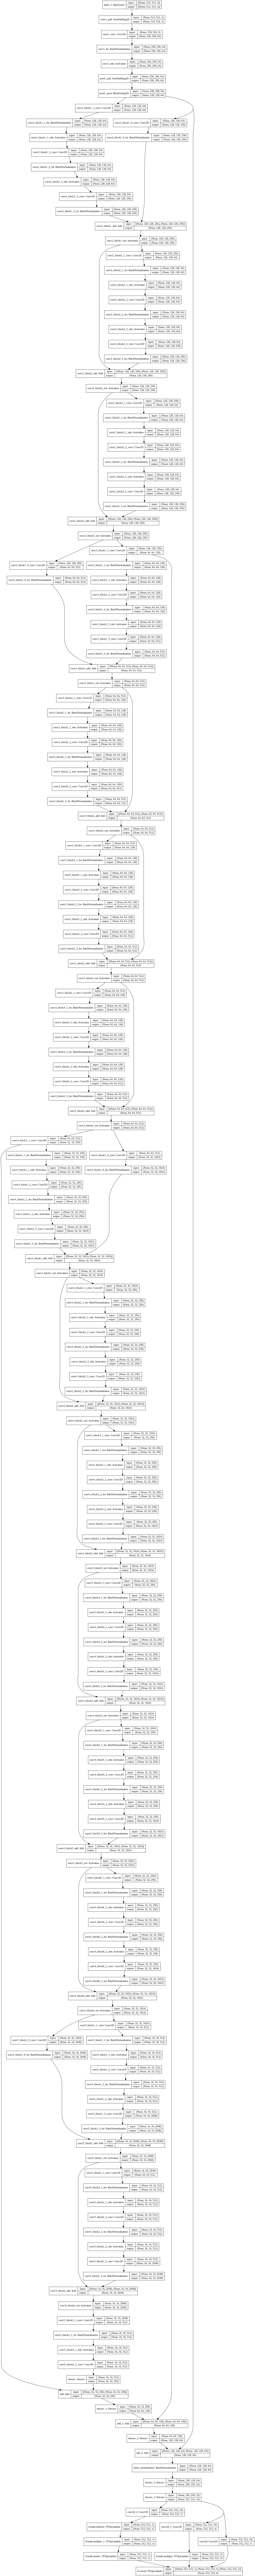

In [ ]:
tf.keras.utils.plot_model(detection_model,show_shapes=True)

In [ ]:
detection_model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Loss functions for detection training

In [ ]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS
# This is dice coefficient loss used to classify point as text and non text region 
def dice_coefficient(y_true_cls, y_pred_cls,
                     training_mask):
    '''
    dice loss
    :param y_true_cls:
    :param y_pred_cls:
    :param training_mask:x
    :return:
    '''
    eps = 10**-6
    intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)
    
    union = tf.reduce_sum(y_true_cls * training_mask) + tf.reduce_sum(y_pred_cls * training_mask) + eps
    loss = 1. - (2 * intersection / union)
    return loss

#This class contains complete loss we have used for text Detection Branch
class detection_Loss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Detection_Loss_layer'):
        super(detection_Loss, self).__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
    
      #Getting geo_map and score_maps
        y_true_cls=y_true[:,:,:,0]
        y_pred_cls=y_pred[:,:,:,0]
        y_pred_geo=y_pred[:,:,:,1:6]
        y_true_geo=y_true[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
    
       #1. Dice Loss
        classification_loss = dice_coefficient(y_true_cls, y_pred_cls, training_mask)
        # we scale classification loss by factor of 0.01 to match the iou loss part
        classification_loss *=0.01
    
        #2. IOU LOSS
        #Reference for IOU LOSS
        #https://github.com/jiangxiluning/FOTS.PyTorch/blob/master/FOTS
        # d1 -> top, d2->right, d3->bottom, d4->left
        d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
        d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)
        area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
        area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
    
        w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
        h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
        area_intersect = w_union * h_union
        area_union = area_gt + area_pred - area_intersect
    
    
        L_AABB = -tf.math.log((area_intersect + 1.0)/(area_union + 1.0))
        L_theta = 1 - tf.cos(theta_pred - theta_gt)

        L_g = L_AABB +  50*L_theta
        L_g=tf.squeeze(L_g,axis=3)
    
        #Here I have multiplied final sum of loss with 100  so that it is easy to visulatise while trianing
        return 100*(tf.reduce_mean(L_g * y_true_cls * training_mask) + classification_loss)
    

In [ ]:
%load_ext tensorboard
detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=detection_Loss())
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',patience=1,mode='min',factor=0.5,verbose=1)

In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 10,callbacks=[tensorboard_callback,reduce_lr,early])

15000
Epoch 1/10
100/100 [==============================] - 1735s 18s/step - loss: 3.9067
Epoch 2/10
100/100 [==============================] - 1642s 17s/step - loss: 3.5392
Epoch 3/10
100/100 [==============================] - 1653s 17s/step - loss: 3.5582
Epoch 4/10
100/100 [==============================] - 1746s 18s/step - loss: 3.7473
Epoch 5/10
100/100 [==============================] - 1838s 19s/step - loss: 3.6003
Epoch 6/10
100/100 [==============================] - 1644s 17s/step - loss: 3.5077
Epoch 7/10
100/100 [==============================] - 1642s 16s/step - loss: 3.4757
Epoch 8/10
100/100 [==============================] - 1684s 17s/step - loss: 3.6305
Epoch 9/10
100/100 [==============================] - 1647s 17s/step - loss: 3.7196
Epoch 10/10
100/100 [==============================] - 1608s 16s/step - loss: 3.4842


In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 5,callbacks=[reduce_lr,early])

Epoch 1/5
100/100 [==============================] - 1540s 15s/step - loss: 3.5023
Epoch 2/5
100/100 [==============================] - 1615s 16s/step - loss: 3.4346
Epoch 3/5
100/100 [==============================] - 1588s 16s/step - loss: 3.5017
Epoch 4/5
100/100 [==============================] - 1548s 16s/step - loss: 3.2746
Epoch 5/5
100/100 [==============================] - 1580s 16s/step - loss: 3.4707


In [ ]:
detection_model.load_weights('/content/drive/MyDrive/detector_synth_weights.h5')

In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 2,callbacks=[reduce_lr,early])

Epoch 1/2
100/100 [==============================] - 1665s 17s/step - loss: 3.0938
Epoch 2/2
100/100 [==============================] - 1596s 16s/step - loss: 2.9595


In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 2,callbacks=[reduce_lr,early])

Epoch 1/2
100/100 [==============================] - 1568s 16s/step - loss: 3.2552
Epoch 2/2
100/100 [==============================] - 1613s 16s/step - loss: 3.1039


In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 2,callbacks=[reduce_lr,early])

Epoch 1/2
100/100 [==============================] - 1560s 16s/step - loss: 3.0608
Epoch 2/2
100/100 [==============================] - 1564s 16s/step - loss: 2.9250


In [ ]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 2,callbacks=[reduce_lr,early])

Epoch 1/2
100/100 [==============================] - 1591s 16s/step - loss: 2.9810
Epoch 2/2
100/100 [==============================] - 1679s 17s/step - loss: 2.9583


In [29]:
detection_model.fit(detection_generator(batch_size=10),steps_per_epoch=100,epochs= 5,callbacks=[reduce_lr,early])

Epoch 1/5
100/100 [==============================] - 1640s 17s/step - loss: 2.9003
Epoch 2/5
100/100 [==============================] - 1606s 16s/step - loss: 2.9189
Epoch 3/5
100/100 [==============================] - 1741s 17s/step - loss: 3.1345
Epoch 4/5
100/100 [==============================] - 1720s 17s/step - loss: 2.9923
Epoch 5/5
100/100 [==============================] - 1550s 16s/step - loss: 2.9019


In [30]:
# Save the weights
detection_model.save_weights('detector_synth_weights.h5')

# Let's Check the detection prediction on Synthtext

In [31]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS

#These Are Function that will be used while converting geo_maps to score_maps and returns bounding boxes for image after nms

def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [32]:
# The references for the below code is taken from
# https://github.com/jiangxiluning/FOTS.PyTorch/tree/master/FOTS
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/Masao-Taketani/FOTS_OCR
# https://github.com/sugam95/FOTS

# Inference pipeline function used for generating predicted bounding boxes on image for text detection
def Pipeline_Detection(img):
  
  start_time=time.time()
  
  #1.Text Detection
  img=cv2.resize(img,(512,512))
  ii=detection_model.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]
  print(score_map.shape)
  print(geo_map.shape)

  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #2.ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]

  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  print(boxes.shape)
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)

  
  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
  
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:

    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
    
    
    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 
    
  if len(rotateParas) > 0:
      
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        pts.append(points)
    
    # 4. Labeling detected and Recognized Text in Image
    
  for i in range(len(pts)):
      cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=1)
  end_time=time.time()
  print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds") 
  return img    


(512, 512)
(512, 512, 5)
(4492, 9)
Time Taken By Pipeline=3.13189697265625 seconds


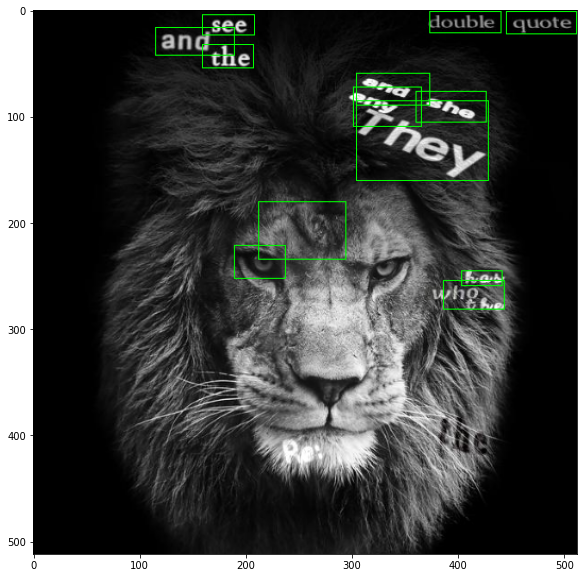

In [33]:

img=cv2.imread('/content/content/SynthText/102/lion_44_83.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im=Pipeline_Detection(img)
plt.figure(figsize=(10,10))
plt.imshow(im)